In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
import xarray as xr
import xmitgcm
import cmocean
import sys
import os

import time
from matplotlib.colors import LogNorm

from IPython.display import clear_output
import xgcm
import xrft

from dask.array import ones_like


from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap



In [2]:
plt.rcParams.update({'font.size': 16
    , 'legend.markerscale': 1., 'axes.titlesize': 20, 'axes.labelsize' : 12,
      'legend.fontsize' : 14,'legend.handlelength': 3})

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

color2 = '#6495ed'
color1 = '#ff6347'
color5 = '#8470ff'
color3 = '#3cb371'
color4 = '#ffd700'
color6 = '#ba55d3'

colors = [color1, color2, color4, color3]
plt.rcParams.update({'figure.figsize' : (15,5)})


In [3]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True

In [4]:
dir_grid = ['/central/groups/oceanphysics/anirban/grid_uniform/grid_2km/',
            '/central/groups/oceanphysics/anirban/grid_uniform/grid_4km/',
            '/central/groups/oceanphysics/anirban/grid_uniform/grid_8km/',
            '/central/groups/oceanphysics/anirban/grid_uniform/grid_16km/',
            
            ]


dirroot_s = '/central/groups/oceanphysics/anirban/smalldomain_4h/'


res = ['2km','4km','8km','16km']
deltaT = [80,200,200,300]

xs1 = [720,360,180,90]
xs2 = [1120,560,280,140]
ys1 = [120,60,30,15]
ys2 = [480,240,120,60]


zlevels = np.array([1., 2., 3., 4., 5., 6., 7., 8., 9.,10.,11.,12.,13.,14.,15.,
                    16.,17.,18.,19.,20.,21.,22.,23.,24.,25.,26.,27.,28.,29.,30.,
                    31.,32.,33.,34.,35.,36.,37.,38.,39.,40.,41.,42.,43.,44.,45.,
                    46.,47.,48.,49.,50.,51.,52.,53.,54.,55.,56.,57.,58.,])
zlevels = (zlevels -1).astype(int)


grids = {}
grids2 = {}

for it, r in enumerate(res):
    grids[r] = xmitgcm.open_mdsdataset(dir_grid[it], delta_t=deltaT[it],
                                       ref_date="2008-01-01 00:00:00", iters = None)


    grids2[r] = grids[r].isel(XC=slice(xs1[it], xs2[it]),XG=slice(xs1[it], xs2[it]),
                           YC=slice(ys1[it], ys2[it]),YG=slice(ys1[it], ys2[it]),
                           Z = zlevels, Zl = zlevels, Zu = zlevels, Zp1 = zlevels,).drop(['Zp1'])


/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/xmitgcm-0.2.2-py3.6.egg/xmitgcm/mds_store.py:807: UserWarning: Couldn't find available_diagnostics.log in /central/groups/oceanphysics/anirban/grid_uniform/grid_2km/. Using default version.
  "in %s. Using default version." % data_dir)
/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/xmitgcm-0.2.2-py3.6.egg/xmitgcm/mds_store.py:807: UserWarning: Couldn't find available_diagnostics.log in /central/groups/oceanphysics/anirban/grid_uniform/grid_4km/. Using default version.
  "in %s. Using default version." % data_dir)
/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/xmitgcm-0.2.2-py3.6.egg/xmitgcm/mds_store.py:807: UserWarning: Couldn't find available_diagnostics.log in /central/groups/oceanphysics/anirban/grid_uniform/grid_8km/. Using default version.
  "in %s. Using default version." % data_dir)
/central/grou

In [5]:
%%time

ds_b = {}
for r in res:
    ds_b[r] = xr.open_dataset(dirroot_s+'%s_timeseries_b.nc' %r)

CPU times: user 81.6 ms, sys: 14.3 ms, total: 95.9 ms
Wall time: 493 ms


In [6]:
ds2 = {}

In [7]:
%%time
ds2['8km'] = xr.open_mfdataset(dirroot_s+'8km/8km_hourly_smalldomain_0*.nc')

CPU times: user 34 s, sys: 1.25 s, total: 35.3 s
Wall time: 1min 49s


In [8]:
%%time
ds2['16km'] = xr.open_mfdataset(dirroot_s+'16km/16km_hourly_smalldomain_0*.nc')

CPU times: user 38.9 s, sys: 1.69 s, total: 40.6 s
Wall time: 3min 41s


In [9]:
%%time
ds2['2km'] = xr.open_mfdataset(dirroot_s+'2km/2km_hourly_smalldomain_0*.nc')

CPU times: user 35.3 s, sys: 1.91 s, total: 37.2 s
Wall time: 3min 42s


In [10]:
%%time
ds2['4km'] = xr.open_mfdataset(dirroot_s+'4km/4km_hourly_smalldomain_0*.nc')

CPU times: user 36.5 s, sys: 1.77 s, total: 38.2 s
Wall time: 3min 33s


In [22]:
def calc_bQsw(ds, grids2, ds_b):
    B = ds_b.b.mean(dim='time')
    b = ds.b - B
    bp = b - b.mean(dim=['XC','YC'])
    
    grid = xgcm.Grid(grids2, periodic=['X','Y','Z'])
    swpen = 0.62*np.exp(ds.Zl/0.6) + (1-0.62)*np.exp(ds.Zl/20)
    rhoConst = 1029.         # (kg/m^3)
    Cp = 3994  
    T_Qsw = -ds.oceQsw*(grid.diff(swpen, 'Z')/ grids2.drF)/(rhoConst*Cp)
    B_Qsw = -ds.oceQsw*ds.B_th*(grid.diff(swpen, 'Z')/ grids2.drF)/(rhoConst*Cp)
    t_Qsw = T_Qsw.isel(XC=slice(1,-1), YC=slice(1,-1)).mean(dim=['XC','YC'])

    
    bpQ2p = (bp * (B_Qsw - B_Qsw.isel(XC=slice(1,-1), YC=slice(1,-1)).mean(dim=['XC','YC']))).isel(XC=slice(1,-1), YC=slice(1,-1)).mean(dim=['XC','YC'])
    
    return B_Qsw, bpQ2p

In [23]:
def calc_timeseries_PEb(ds, grids2, ds_b):
    grid = xgcm.Grid(grids2, periodic=['X','Y','Z'])
    B = ds_b.b.mean(dim='time')
    b = ds.b - B
    bp = b - b.mean(dim=['XC','YC'])
    bp2 = bp**2
    
    Bp2_y = (grid.interp(grid.diff(bp2, 'Y')/grids2.dyC, 'Y'))
    Bp2_x = (grid.interp(grid.diff(bp2, 'X')/grids2.dxC, 'X'))
    Bp2_z = (grid.interp(grid.diff(bp2, 'Z')/grids2.drC.values[np.newaxis, :, np.newaxis, np.newaxis],'Z'))

    bp2_y = Bp2_y.isel(XC=slice(1,-1),YC=slice(1,-1)).mean(dim=['XC','YC'])
    bp2_x = Bp2_x.isel(XC=slice(1,-1),YC=slice(1,-1)).mean(dim=['XC','YC'])
    bp2_z = Bp2_z.isel(XC=slice(1,-1),YC=slice(1,-1)).mean(dim=['XC','YC'])
    

    gradbp2=(np.sqrt(Bp2_x**2+Bp2_y**2)).isel(XC=slice(1,-1),YC=slice(1,-1)).mean(dim=['XC','YC'])
    
    um = (grid.interp(ds.u, 'X')).isel(XC=slice(1,-1),YC=slice(1,-1)).mean(dim=['XC','YC'])
    vm = (grid.interp(ds.v, 'Y')).isel(XC=slice(1,-1),YC=slice(1,-1)).mean(dim=['XC','YC'])
    wm = (grid.interp(ds.w, 'Z')).isel(XC=slice(1,-1),YC=slice(1,-1)).mean(dim=['XC','YC'])
    
    Bp2dy = (grid.interp((grids2.dyG), 'X'))*bp2
    Bp2dx = (grid.interp((grids2.dxG), 'Y'))*bp2
    
    VBp2dx_NS = vm * (Bp2dx.isel(YC=-2, XC=slice(1,-1)).sum(dim='XC') - Bp2dx.isel(YC=1, XC=slice(1,-1)).sum(dim='XC'))
    UBp2dy_EW = um * (Bp2dy.isel(XC=-2, YC=slice(1,-1)).sum(dim='YC') - Bp2dy.isel(XC=1, YC=slice(1,-1)).sum(dim='YC'))
    
    Darea = (grid.interp(grids2.dxC, 'X')*grid.interp(grids2.dyC, 'Y')).sum(dim=['XC','YC'])
    Ugradbp2_div = 0.5*((VBp2dx_NS + UBp2dy_EW) / Darea)
    
    
    umbp2_x = 0.5*(um * bp2_x)
    vmbp2_y = 0.5*(vm * bp2_y)
    wmbp2_z = 0.5*(wm * bp2_z)
    
    Ugradbp2_h = umbp2_x + vmbp2_y
    Ugradbp2 = umbp2_x + vmbp2_y + wmbp2_z
    
    B_y = grid.diff(b,'Y')/grids2.dyC
    B_x = grid.diff(b,'X')/grids2.dxC
    B_z = -grid.diff(b,'Z')/grids2.drC.values[np.newaxis, :, np.newaxis, np.newaxis]
   
    vp = ds.v - ds.v.mean(dim=['XC','YG'])
    up = ds.u - ds.u.mean(dim=['XG','YC'])
    wp = ds.w - ds.w.mean(dim=['XC','YC'])
    
    wpbp = (grid.interp((wp* grid.interp(bp, 'Z')), 'Z')).isel(XC=slice(1,-1),YC=slice(1,-1)).mean(dim=['XC','YC'])
    
    vpbpby = (B_y*vp*grid.interp(bp, 'Y')).isel(XC=slice(1,-1),YG=slice(1,-1)).mean(dim=['XC','YG'])
    upbpbx = (B_x*up*grid.interp(bp, 'X')).isel(XG=slice(1,-1),YC=slice(1,-1)).mean(dim=['XG','YC'])
    wpbpbz = (grid.interp(B_z*wp*grid.interp(bp, 'Z'),'Z')).isel(XC=slice(1,-1),YC=slice(1,-1)).mean(dim=['XC','YC'])
    
    Upbpgradb_h = (upbpbx + vpbpby)
    
    Upbpgradb = (upbpbx + vpbpby + wpbpbz)
    
    Upbpgradb_v = (wpbpbz)
    bp2_tend = ((bp2).diff('time')/14400).isel(XC=slice(1,-1), YC=slice(1,-1)).mean(dim=['XC','YC'])
    
    ds_PEb = xr.merge([Ugradbp2.to_dataset(name='Ugradbp2'),
                       Ugradbp2_h.to_dataset(name='Ugradbp2_h'),
                       Ugradbp2_div.to_dataset(name='Ugradbp2_div'),
                       Upbpgradb.to_dataset(name='Upbpgradb'),
                       Upbpgradb_h.to_dataset(name='Upbpgradb_h'),
                       Upbpgradb_v.to_dataset(name='Upbpgradb_v'),
                       wpbp.to_dataset(name='wpbp'),
                       bp2_tend.to_dataset(name='bp2_tend'),
#                        b_z.to_dataset(name='b_z'),
#                        b_x.to_dataset(name='b_x'),
#                        b_y.to_dataset(name='b_y'), 
                     ])
    return ds_PEb

In [11]:
def calc_Upbpgradb(ds, grids2, ds_b):
    grid = xgcm.Grid(grids2, periodic=['X','Y','Z'])
    B = ds_b.b.mean(dim='time')
    b = ds.b - B
    bp = b - b.mean(dim=['XC','YC'])
    B_y = grid.diff(b,'Y')/grids2.dyC
    B_x = grid.diff(b,'X')/grids2.dxC
    B_z = -grid.diff(b,'Z')/grids2.drC.values[np.newaxis, :, np.newaxis, np.newaxis]
   
    vp = ds.v - ds.v.mean(dim=['XC','YG'])
    up = ds.u - ds.u.mean(dim=['XG','YC'])
    wp = ds.w - ds.w.mean(dim=['XC','YC'])
    
    
    vpbpby = (B_y*vp*grid.interp(bp, 'Y')).isel(XC=slice(1,-1),YG=slice(1,-1)).mean(dim=['XC','YG'])
    upbpbx = (B_x*up*grid.interp(bp, 'X')).isel(XG=slice(1,-1),YC=slice(1,-1)).mean(dim=['XG','YC'])
    Upbpgradb_h = (upbpbx + vpbpby)

    wpbpbz = (B_z*wp*grid.interp(bp, 'Z')).isel(XC=slice(1,-1),YC=slice(1,-1)).mean(dim=['XC','YC'])
    Upbpgradb_v = (grid.interp(B_z*wp*grid.interp(bp, 'Z'),'Z')).isel(XC=slice(1,-1),YC=slice(1,-1)).mean(dim=['XC','YC'])
    
    Upbpgradb2 = (upbpbx + vpbpby + grid.interp(wpbpbz, 'Z'))
    Upbpgradb = (Upbpgradb_h + Upbpgradb_v)
    
    ds_PEb_m = xr.merge([Upbpgradb.to_dataset(name='Upbpgradb'), 
                         Upbpgradb2.to_dataset(name='Upbpgradb2'),
                         Upbpgradb_h.to_dataset(name='Upbpgradb_h'),
                         Upbpgradb_v.to_dataset(name='Upbpgradb_v'),
                         upbpbx.to_dataset(name='upbpbx'),
                         vpbpby.to_dataset(name='vpbpby'),
                         wpbpbz.to_dataset(name='wpbpbz'),
                        ])
    return ds_PEb_m

In [169]:
def calc_PEb_main_wsq(ds, grids2, ds_b):
    grid = xgcm.Grid(grids2, periodic=['X','Y','Z'])
    B = ds_b.b.mean(dim='time')
    b = ds.b - B
    bp = b - b.mean(dim=['XC','YC'])
    bp2 = bp**2
    
    
    B_y = grid.diff(b,'Y')/grids2.dyC
    B_x = grid.diff(b,'X')/grids2.dxC
    B_z = -grid.diff(b,'Z')/grids2.drC.values[np.newaxis, :, np.newaxis, np.newaxis]
   
    vp = ds.v - ds.v.mean(dim=['XC','YG'])
    up = ds.u - ds.u.mean(dim=['XG','YC'])
    wp = ds.w - ds.w.mean(dim=['XC','YC'])
    
    wpbp = (grid.interp((wp* grid.interp(bp, 'Z')), 'Z')).isel(XC=slice(1,-1),YC=slice(1,-1)).mean(dim=['XC','YC'])
    wpbp_2 = ((grid.interp((wp* grid.interp(bp, 'Z')), 'Z'))**2).isel(XC=slice(1,-1),YC=slice(1,-1)).mean(dim=['XC','YC'])
    
    vpbpby = (B_y*vp*grid.interp(bp, 'Y')).isel(XC=slice(1,-1),YG=slice(1,-1)).mean(dim=['XC','YG'])
    upbpbx = (B_x*up*grid.interp(bp, 'X')).isel(XG=slice(1,-1),YC=slice(1,-1)).mean(dim=['XG','YC'])
    wpbpbz = (B_z*wp*grid.interp(bp, 'Z')).isel(XC=slice(1,-1),YC=slice(1,-1)).mean(dim=['XC','YC'])
    
    vpbpby_2 = ((B_y*vp*grid.interp(bp, 'Y'))**2).isel(XC=slice(1,-1),YG=slice(1,-1)).mean(dim=['XC','YG'])
    upbpbx_2 = ((B_x*up*grid.interp(bp, 'X'))**2).isel(XG=slice(1,-1),YC=slice(1,-1)).mean(dim=['XG','YC'])
    wpbpbz_2 = ((B_z*wp*grid.interp(bp, 'Z'))**2).isel(XC=slice(1,-1),YC=slice(1,-1)).mean(dim=['XC','YC'])
    
    Upbpgradb_h = (upbpbx + vpbpby)
    Upbpgradb_v = grid.interp(wpbpbz, 'Z')
    Upbpgradb = (upbpbx + vpbpby + grid.interp(wpbpbz, 'Z'))

    Upbpgradb_h_2 = (upbpbx_2 + vpbpby_2)
    Upbpgradb_v_2 = grid.interp(wpbpbz_2, 'Z')
    Upbpgradb_2 = (upbpbx_2 + vpbpby_2 + grid.interp(wpbpbz_2, 'Z'))

    wp_2 = (wp**2).isel(XC=slice(1,-1),YC=slice(1,-1)).mean(dim=['XC','YC'])
    bp_2 = (bp**2).isel(XC=slice(1,-1),YC=slice(1,-1)).mean(dim=['XC','YC'])
    
    ds_PEb = xr.merge([Upbpgradb.to_dataset(name='Upbpgradb'),
                       Upbpgradb_h.to_dataset(name='Upbpgradb_h'),
                       Upbpgradb_v.to_dataset(name='Upbpgradb_v'),
                       wpbp.to_dataset(name='wpbp'),
                       Upbpgradb_2.to_dataset(name='Upbpgradb_2'),
                       Upbpgradb_h_2.to_dataset(name='Upbpgradb_h_2'),
                       Upbpgradb_v_2.to_dataset(name='Upbpgradb_v_2'),
                       wpbp_2.to_dataset(name='wpbp_2'),
                       wp_2.to_dataset(name='wp_2'),
                       bp_2.to_dataset(name='bp_2'),
                     ])
    return ds_PEb

In [170]:
%%time
ds_PEb_msq = {}
for r in res:
    ds_PEb_msq[r]=calc_PEb_main_wsq(ds2[r],grids2[r], ds_b[r])
    print(r)

2km
4km
8km
16km
CPU times: user 7.5 s, sys: 113 ms, total: 7.62 s
Wall time: 7.63 s


In [171]:
%%time
for r in ['16km','8km']:
    ds_PEb_msq[r] = ds_PEb_msq[r].load()
    print('Finished loading %s' %r)
    ds_PEb_msq[r].to_netcdf(dirroot_s+'%s_areamean_PEb_mainterms_wsq.nc' %r)
    print('Finished saving %s_areamean_PEb_mainterms_wsq.nc' %r)

Finished loading 16km
Finished saving 16km_areamean_PEb_mainterms_wsq.nc
Finished loading 8km
Finished saving 8km_areamean_PEb_mainterms_wsq.nc
CPU times: user 9min 3s, sys: 2min 31s, total: 11min 34s
Wall time: 11min 23s


In [173]:
%%time
for r in ['4km']:
    ds_PEb_msq[r] = ds_PEb_msq[r].load()
    print('Finished loading %s' %r)
    ds_PEb_msq[r].to_netcdf(dirroot_s+'%s_areamean_PEb_mainterms_wsq.nc' %r)
    print('Finished saving %s_areamean_PEb_mainterms_wsq.nc' %r)

Finished loading 4km
Finished saving 4km_areamean_PEb_mainterms_wsq.nc
CPU times: user 17min 50s, sys: 12min 25s, total: 30min 16s
Wall time: 9min 2s


In [174]:
%%time
for r in ['2km']:
    ds_PEb_msq[r] = ds_PEb_msq[r].load()
    print('Finished loading %s' %r)
    ds_PEb_msq[r].to_netcdf(dirroot_s+'%s_areamean_PEb_mainterms_wsq.nc' %r)
    print('Finished saving %s_areamean_PEb_mainterms_wsq.nc' %r)

Finished loading 2km
Finished saving 2km_areamean_PEb_mainterms_wsq.nc
CPU times: user 1h 40min 46s, sys: 56min 24s, total: 2h 37min 10s
Wall time: 14min


In [180]:
ds_PEb_msq['2km'].Upbpgradb.mean(dim='time')

<xarray.DataArray 'Upbpgradb' (Z: 58)>
array([-4.335920e-13, -5.237659e-13, -7.574995e-13, -1.155345e-12,
       -1.715004e-12, -2.257176e-12, -2.582543e-12, -2.644205e-12,
       -2.520496e-12, -2.309379e-12, -2.062758e-12, -1.810748e-12,
       -1.562780e-12, -1.350436e-12, -1.189968e-12, -1.057966e-12,
       -9.365857e-13, -8.336212e-13, -7.411553e-13, -6.513893e-13,
       -5.754342e-13, -5.080949e-13, -4.465429e-13, -3.886379e-13,
       -3.358374e-13, -2.907260e-13, -2.492672e-13, -2.153464e-13,
       -1.876297e-13, -1.592215e-13, -1.330413e-13, -1.128449e-13,
       -9.200986e-14, -7.118217e-14, -5.285870e-14, -3.651095e-14,
       -2.372994e-14, -1.469431e-14, -7.853716e-15, -2.318035e-15,
        2.233236e-15,  6.416652e-15,  1.004471e-14,  1.448352e-14,
        2.003710e-14,  2.380652e-14,  2.439199e-14,  2.220785e-14,
        1.834776e-14,  1.292767e-14,  7.066232e-15,  2.549407e-15,
        1.001158e-16, -5.723106e-16, -3.350195e-16,  1.023853e-16,
        9.030287e-16, -

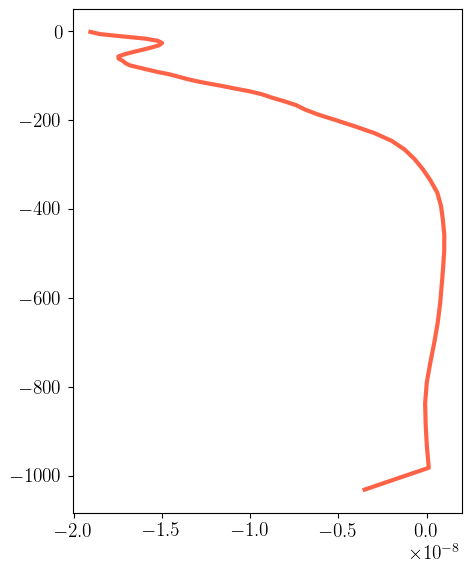

In [185]:
plt.figure(figsize=(5,6),dpi=100, tight_layout=True)
plt.plot(ds_PEb_msq['2km'].Upbpgradb.mean(dim='time')/Nsq0['2km'], ds_PEb_msq['2km'].Z, color=colours[r], linewidth=3)
plt.plot((ds_PEb_msq['2km'].Upbpgradb.mean(dim='time')+ )/Nsq0['2km'], ds_PEb_msq['2km'].Z, color=colours[r], linewidth=3)

# ds_PEb_msq['2km'].Upbpgradb.mean(dim='time')

In [12]:
%%time
ds_PEb_m = {}
for r in res:
    ds_PEb_m[r]=calc_Upbpgradb(ds2[r],grids2[r], ds_b[r])
    print(r)

2km
4km
8km
16km
CPU times: user 4.75 s, sys: 170 ms, total: 4.92 s
Wall time: 7.03 s


In [14]:
%%time
for r in ['16km','8km']:
    ds_PEb_m[r] = ds_PEb_m[r].load()
    print('Finished loading %s' %r)

Finished loading 16km
Finished loading 8km
CPU times: user 6min 38s, sys: 3min, total: 9min 38s
Wall time: 11min 23s


In [15]:
%%time
for r in ['4km']:
    ds_PEb_m[r] = ds_PEb_m[r].load()
    print('Finished loading %s' %r)

Finished loading 4km
CPU times: user 11min 48s, sys: 9min 26s, total: 21min 14s
Wall time: 15min 36s


In [16]:
%%time
for r in ['2km']:
    ds_PEb_m[r] = ds_PEb_m[r].load()
    print('Finished loading %s' %r)

Finished loading 2km
CPU times: user 1h 29s, sys: 40min 2s, total: 1h 40min 32s
Wall time: 12min 41s


In [17]:
%%time
for r in res:
    ds_PEb_m[r].to_netcdf(dirroot_s+'%s_areamean_Upbpgradb.nc' %r)
    print('Finished saving %s_areamean_Upbpgradb.nc' %r)

Finished saving 2km_areamean_Upbpgradb.nc
Finished saving 4km_areamean_Upbpgradb.nc
Finished saving 8km_areamean_Upbpgradb.nc
Finished saving 16km_areamean_Upbpgradb.nc
CPU times: user 157 ms, sys: 91.2 ms, total: 248 ms
Wall time: 1.02 s


In [12]:
%%time
ds_timeseries_PEb = {}
for r in res:
    ds_timeseries_PEb[r]=calc_timeseries_PEb(ds2[r],grids2[r], ds_b[r])
    print(r)

2km
4km


KeyError: '8km'

In [13]:
ds_timeseries_PEb['2km']

<xarray.Dataset>
Dimensions:       (Z: 58, time: 4392)
Coordinates:
  * time          (time) datetime64[ns] 2048-01-01T02:00:00 ... 2050-01-01T22:00:00
  * Z             (Z) float32 -2.5 -7.5 -12.5 ... -933.755 -982.51 -1031.635
Data variables:
    Ugradbp2      (time, Z) float64 dask.array<shape=(4392, 58), chunksize=(6, 1)>
    Ugradbp2_h    (time, Z) float64 dask.array<shape=(4392, 58), chunksize=(6, 58)>
    Ugradbp2_div  (time, Z) float64 dask.array<shape=(4392, 58), chunksize=(6, 58)>
    Upbpgradb     (time, Z) float64 dask.array<shape=(4392, 58), chunksize=(6, 1)>
    Upbpgradb_h   (time, Z) float64 dask.array<shape=(4392, 58), chunksize=(6, 58)>
    Upbpgradb_v   (time, Z) float64 dask.array<shape=(4392, 58), chunksize=(6, 1)>
    wpbp          (time, Z) float64 dask.array<shape=(4392, 58), chunksize=(6, 1)>
    bp2_tend      (time, Z) float64 dask.array<shape=(4392, 58), chunksize=(6, 58)>

In [15]:
%%time
for r in ['16km','8km']:
    ds_timeseries_PEb[r] = ds_timeseries_PEb[r].load()
    print('Finished loading %s' %r)

Finished loading 16km
Finished loading 8km
CPU times: user 14min 40s, sys: 2min 21s, total: 17min 2s
Wall time: 16min 35s


In [17]:
%%time
for r in ['16km','8km']:
    ds_timeseries_PEb[r].to_netcdf(dirroot_s+'%s_areamean_PEb.nc' %r)
    print('Finished saving %s_areamean_PEb.nc' %r)

Finished saving 16km_areamean_PEb.nc
Finished saving 8km_areamean_PEb.nc
CPU times: user 82.1 ms, sys: 19.9 ms, total: 102 ms
Wall time: 259 ms


In [ ]:
%%time
for r in ['4km']:
    ds_timeseries_PEb[r] = ds_timeseries_PEb[r].load()
    print('Finished loading %s' %r)
    ds_timeseries_PEb[r].to_netcdf(dirroot_s+'%s_areamean_PEb.nc' %r)
    print('Finished saving %s_areamean_PEb.nc' %r)

In [18]:
import pandas as pd

In [21]:
months = pd.date_range("2048-02-01", "2050-02-01", freq='M').strftime('%Y-%m')
months

Index(['2048-02', '2048-03', '2048-04', '2048-05', '2048-06', '2048-07',
       '2048-08', '2048-09', '2048-10', '2048-11', '2048-12', '2049-01',
       '2049-02', '2049-03', '2049-04', '2049-05', '2049-06', '2049-07',
       '2049-08', '2049-09', '2049-10', '2049-11', '2049-12', '2050-01'],
      dtype='object')

In [24]:
%%time
for j, mnth in enumerate(months):
    clear_output(wait=True)
    calc_timeseries_PEb(ds2['4km'].sel(time=mnth),grids2['4km'], ds_b['4km'].sel(time=mnth)).to_netcdf(dirroot_s+'4km_PEb_adia_month_%05d.nc' %j)
    print('saving 4km_PEb_adia_month_%05d.nc, month=%s' %(j, mnth))

saving 4km_PEb_adia_month_00023.nc, month=2050-01
CPU times: user 31min 23s, sys: 19min 14s, total: 50min 37s
Wall time: 11min 56s


In [25]:
ds_timeseries_PEb = {}
ds_timeseries_PEb['4km'] = xr.open_mfdataset(dirroot_s+'4km_PEb_adia_month_*.nc')
ds_timeseries_PEb

{'4km': <xarray.Dataset>
 Dimensions:       (Z: 58, time: 4386)
 Coordinates:
   * Z             (Z) float32 -2.5 -7.5 -12.5 ... -933.755 -982.51 -1031.635
   * time          (time) datetime64[ns] 2048-02-01T02:00:00 ... 2050-01-31T22:00:00
 Data variables:
     Ugradbp2      (time, Z) float64 dask.array<shape=(4386, 58), chunksize=(174, 58)>
     Ugradbp2_h    (time, Z) float64 dask.array<shape=(4386, 58), chunksize=(174, 58)>
     Ugradbp2_div  (time, Z) float64 dask.array<shape=(4386, 58), chunksize=(174, 58)>
     Upbpgradb     (time, Z) float64 dask.array<shape=(4386, 58), chunksize=(174, 58)>
     Upbpgradb_h   (time, Z) float64 dask.array<shape=(4386, 58), chunksize=(174, 58)>
     Upbpgradb_v   (time, Z) float64 dask.array<shape=(4386, 58), chunksize=(174, 58)>
     wpbp          (time, Z) float64 dask.array<shape=(4386, 58), chunksize=(174, 58)>
     bp2_tend      (time, Z) float64 dask.array<shape=(4386, 58), chunksize=(174, 58)>}

In [26]:
%%time
for r in ['4km']:
    ds_timeseries_PEb[r] = ds_timeseries_PEb[r].load()
    print('Finished loading %s' %r)
    ds_timeseries_PEb[r].to_netcdf(dirroot_s+'%s_areamean_PEb.nc' %r)
    print('Finished saving %s_areamean_PEb.nc' %r)

Finished loading 4km
Finished saving 4km_areamean_PEb.nc
CPU times: user 460 ms, sys: 139 ms, total: 598 ms
Wall time: 593 ms


In [18]:
%%time

ds_PE_dia = {}
ds_PEb = {}

for r in ['2km','16km']:

    ds_PE_dia[r] = xr.open_dataset(dirroot_s+'%s_areamean_PE_budget_tend_diabatic.nc' %r)
    ds_PEb[r] = xr.open_dataset(dirroot_s+'%s_area_mean_PE_budget_adiabatic_wo_tend.nc' %r)

CPU times: user 115 ms, sys: 23.9 ms, total: 139 ms
Wall time: 578 ms


In [19]:
ds_PE = {}
for r in ['2km', '16km']:
    ds_PE[r] = xr.merge([ds_PEb[r], ds_PE_dia[r]])

In [20]:
for r in ['4km', '8km']:
    ds_PE[r] = xr.open_dataset(dirroot_s+'%s_areamean_PEb.nc' %r)

In [21]:
Nsq0 = {}
for r in res:
    Nsq0[r] = ds_b[r].b_z.mean(dim='time')

In [22]:
ds_PE_all = {}
for r in res:
    ds_PE_all[r] = ds_PE[r].copy()
    ds_PE_all[r]['LHS'] = (0.5*ds_PE_all[r]['bp2_tend']/Nsq0[r] + 
                           ds_PE_all[r]['wpbp'] + 
                           ds_PE_all[r]['Upbpgradb']/Nsq0[r] +  
                           ds_PE_all[r]['Ugradbp2']/Nsq0[r])
    ds_PE_all[r]['LHS0'] = (0.5*ds_PE_all[r]['bp2_tend']/Nsq0[r] + 
                           ds_PE_all[r]['wpbp'] + 
                           ds_PE_all[r]['Upbpgradb_h']/Nsq0[r] +  
                           ds_PE_all[r]['Ugradbp2']/Nsq0[r])

In [23]:
time_mean_PE = {}
clim_PE = {}
for r in res:
    time_mean_PE[r] = ds_PE_all[r].mean(dim='time')
    clim_PE[r] = ds_PE_all[r].groupby('time.month').mean(dim='time')
    

In [24]:
time_mean_PE_m = {}
clim_PE_m = {}
for r in res:
    time_mean_PE_m[r] = ds_PEb_m[r].mean(dim='time')
    clim_PE_m[r] = ds_PEb_m[r].groupby('time.month').mean(dim='time')
    

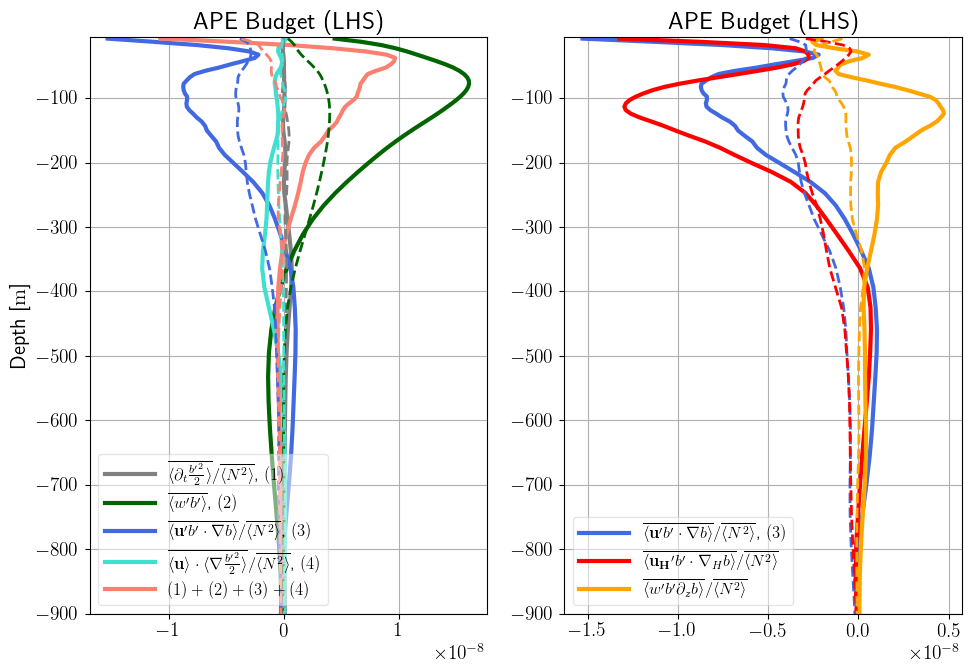

In [25]:
fig = plt.figure(figsize=(10,7), dpi=100, tight_layout=True)
colours = ['grey', 'darkgreen','royalblue','turquoise','salmon','royalblue', 'red', 'orange']

labells = [r'$\overline{\langle  \partial_t\frac{{b^{\prime}}^{2}}{2} \rangle}/ \overline{\langle N^2 \rangle}$, $(1)$' , 
           r'$\overline{\langle w^{\prime}b^{\prime} \rangle}$, $(2)$', 
           r'$\overline{\langle \mathbf{u}^{\prime}b^{\prime} \cdot \nabla b \rangle}/\overline{\langle N^2 \rangle}$, $(3)$', 
           r'$\overline{\langle \mathbf{u} \rangle \cdot \langle \nabla \frac{{b^{\prime}}^{2}}{2} \rangle}/ \overline{\langle N^2 \rangle}$, $(4)$', 
           r'$(1)+ (2)+(3)+(4)$',
           r'$\overline{\langle \mathbf{u}^{\prime}b^{\prime} \cdot \nabla b \rangle}/\overline{\langle N^2 \rangle}$, $(3)$', 
           r'$\overline{\langle \mathbf{u_{H}}^{\prime}b^{\prime} \cdot \nabla_{H} b \rangle}/\overline{\langle N^2 \rangle}$', 
           r'$\overline{\langle w^{\prime}b^{\prime} \partial_z b \rangle}/\overline{\langle N^2 \rangle}$', 
           ]
plt.subplot(121)
plt.plot((time_mean_PE['2km'].bp2_tend/(2*Nsq0['2km'])).sel(Z=slice(-5,-1000)), time_mean_PE['2km'].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[0],label=labells[0])
plt.plot(time_mean_PE['2km'].wpbp.sel(Z=slice(-5,-1000)), time_mean_PE['2km'].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[1],label=labells[1])
plt.plot((time_mean_PE['2km'].Upbpgradb/Nsq0['2km']).sel(Z=slice(-5,-1000)), time_mean_PE['2km'].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[2],label=labells[2])
plt.plot((time_mean_PE['2km'].Ugradbp2/Nsq0['2km']).sel(Z=slice(-5,-1000)), time_mean_PE['2km'].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[3],label=labells[3])
plt.plot(time_mean_PE['2km'].LHS.sel(Z=slice(-5,-1000)), time_mean_PE['2km'].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[4],label=labells[4])

plt.plot((time_mean_PE['16km'].bp2_tend/(2*Nsq0['16km'])).sel(Z=slice(-5,-1000)), time_mean_PE['16km'].sel(Z=slice(-5,-1000)).Z, linewidth=2,linestyle='dashed', color = colours[0])
plt.plot(time_mean_PE['16km'].wpbp.sel(Z=slice(-5,-1000)), time_mean_PE['16km'].sel(Z=slice(-5,-1000)).Z, linewidth=2,linestyle='dashed', color = colours[1])
plt.plot((time_mean_PE['16km'].Upbpgradb/Nsq0['16km']).sel(Z=slice(-5,-1000)), time_mean_PE['16km'].sel(Z=slice(-5,-1000)).Z, linewidth=2,linestyle='dashed', color = colours[2])
plt.plot((time_mean_PE['16km'].Ugradbp2/Nsq0['16km']).sel(Z=slice(-5,-1000)), time_mean_PE['2km'].sel(Z=slice(-5,-1000)).Z, linewidth=2,linestyle='dashed', color = colours[3])
plt.plot(time_mean_PE['16km'].LHS.sel(Z=slice(-5,-1000)), time_mean_PE['16km'].sel(Z=slice(-5,-1000)).Z, linewidth=2,linestyle='dashed', color = colours[4])

plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.title(r'APE Budget (LHS)', fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(122)
plt.plot((time_mean_PE['2km'].Upbpgradb/Nsq0['2km']).sel(Z=slice(-5,-1000)), time_mean_PE['2km'].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[2],label=labells[2])
plt.plot((time_mean_PE['2km'].Upbpgradb_h/Nsq0['2km']).sel(Z=slice(-5,-1000)), time_mean_PE['2km'].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[6],label=labells[6])
plt.plot((time_mean_PE['2km'].Upbpgradb_v/Nsq0['2km']).sel(Z=slice(-5,-1000)), time_mean_PE['2km'].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[7],label=labells[7])

plt.plot((time_mean_PE['16km'].Upbpgradb/Nsq0['16km']).sel(Z=slice(-5,-1000)), time_mean_PE['16km'].sel(Z=slice(-5,-1000)).Z, linewidth=2,linestyle='dashed', color = colours[2],)
plt.plot((time_mean_PE['16km'].Upbpgradb_h/Nsq0['16km']).sel(Z=slice(-5,-1000)), time_mean_PE['16km'].sel(Z=slice(-5,-1000)).Z, linewidth=2,linestyle='dashed', color = colours[6])
plt.plot((time_mean_PE['16km'].Upbpgradb_v/Nsq0['16km']).sel(Z=slice(-5,-1000)), time_mean_PE['16km'].sel(Z=slice(-5,-1000)).Z, linewidth=2,linestyle='dashed', color = colours[7])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('', fontsize=15)
plt.title(r'APE Budget (LHS)', fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()


In [54]:
colors

['#ff6347', '#6495ed', '#ffd700', '#3cb371']

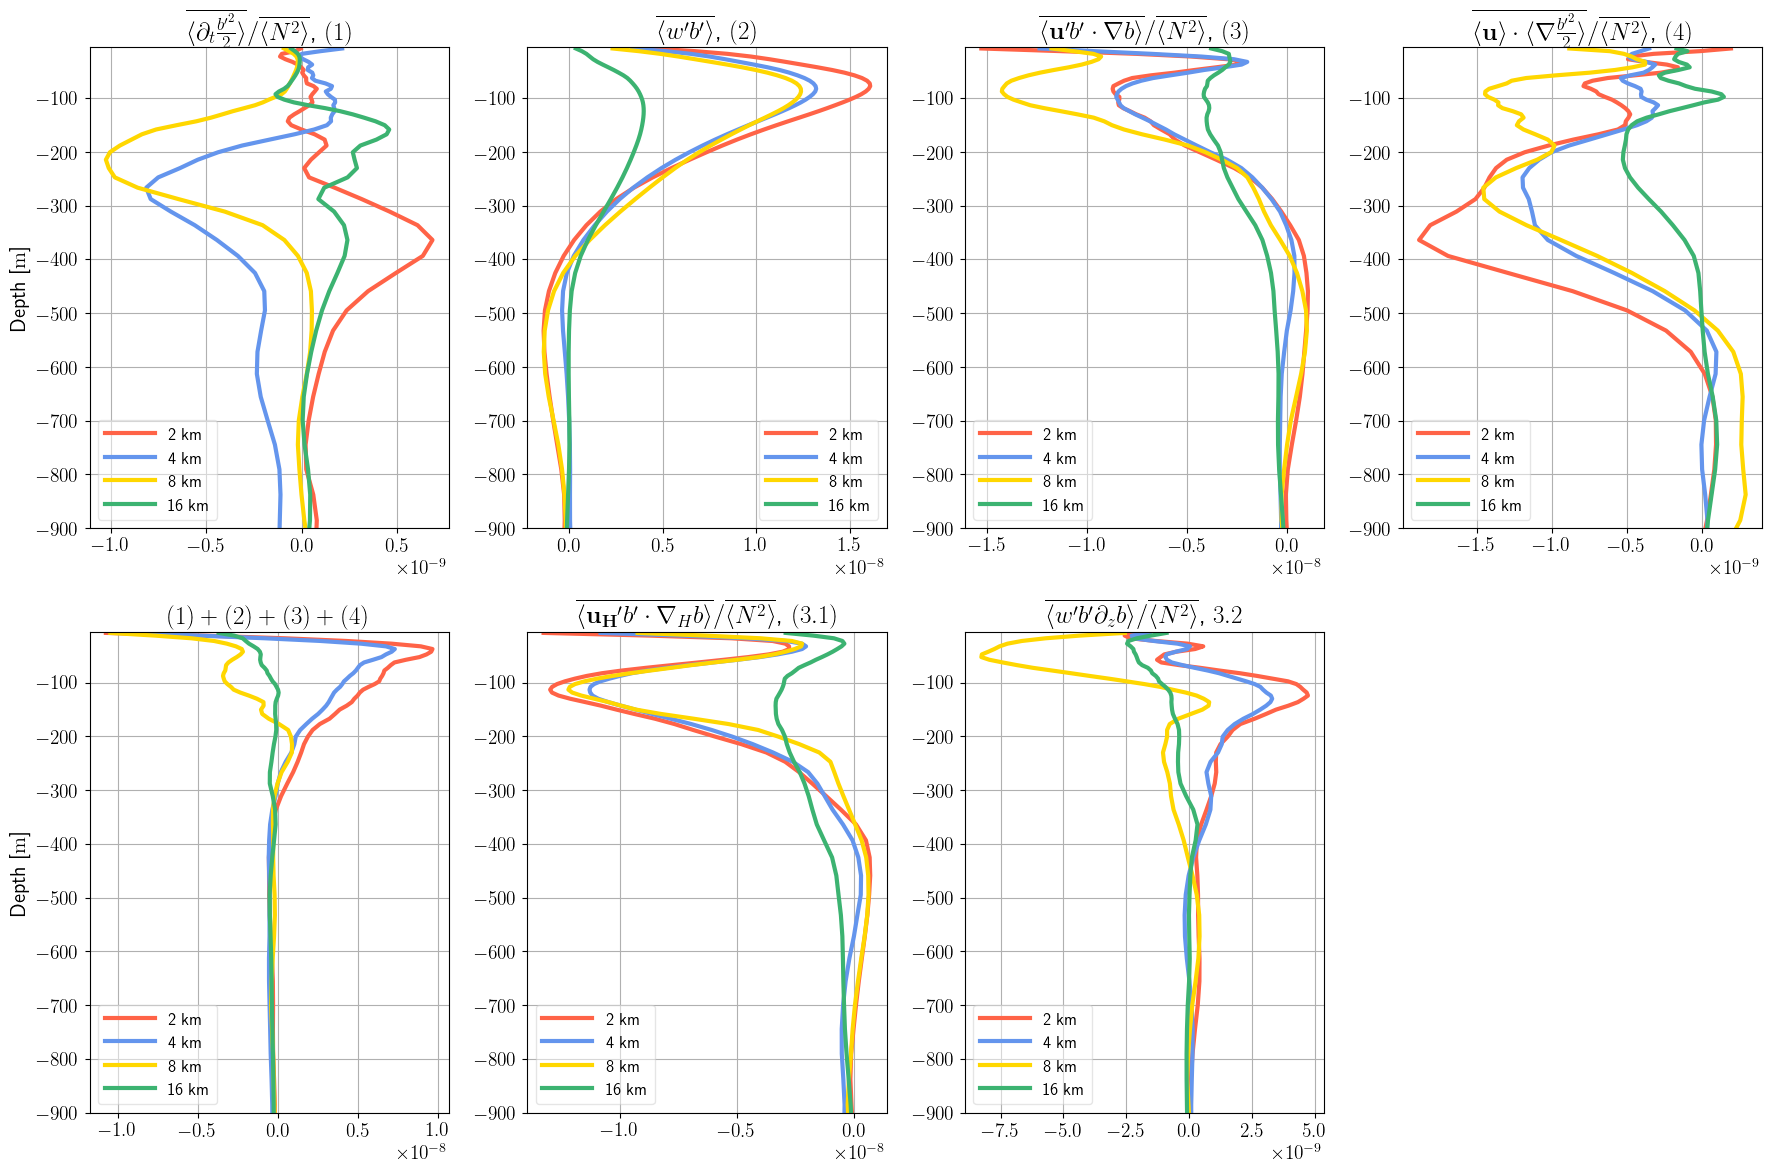

In [32]:
fig = plt.figure(figsize=(18,12), dpi=100, tight_layout=True)
# colours = ['grey', 'darkgreen','royalblue','turquoise','salmon','royalblue', 'red', 'orange']

titles = [r'$\overline{\langle  \partial_t\frac{{b^{\prime}}^{2}}{2} \rangle}/ \overline{\langle N^2 \rangle}$, $(1)$' , 
          r'$\overline{\langle w^{\prime}b^{\prime} \rangle}$, $(2)$', 
          r'$\overline{\langle \mathbf{u}^{\prime}b^{\prime} \cdot \nabla b \rangle}/\overline{\langle N^2 \rangle}$, $(3)$', 
          r'$\overline{\langle \mathbf{u} \rangle \cdot \langle \nabla \frac{{b^{\prime}}^{2}}{2} \rangle}/ \overline{\langle N^2 \rangle}$, $(4)$', 
          r'$(1)+(2)+(3)+(4)$',
          r'$\overline{\langle \mathbf{u_{H}}^{\prime}b^{\prime} \cdot \nabla_{H} b \rangle}/\overline{\langle N^2 \rangle}$, $(3.1)$' ,
          r'$\overline{\langle w^{\prime}b^{\prime} \partial_z b \rangle}/\overline{\langle N^2 \rangle}$, $3.2$', 
           ]

labels = {'2km': '2 km','4km': '4 km','8km': '8 km','16km': '16 km',}
colours = {'2km': colors[0],'4km': colors[1],'8km': colors[2],'16km': colors[3]}
plt.subplot(241)
for i, r in enumerate(res):
    plt.plot((time_mean_PE[r].bp2_tend/(2*Nsq0[r])).sel(Z=slice(-5,-1000)), time_mean_PE[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.title(titles[0], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(242)
for i, r in enumerate(res):
    plt.plot(time_mean_PE[r].wpbp.sel(Z=slice(-5,-1000)), time_mean_PE[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[1], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(243)
for i, r in enumerate(res):
    plt.plot((time_mean_PE[r].Upbpgradb/Nsq0[r]).sel(Z=slice(-5,-1000)), time_mean_PE[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[2], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(244)
for i, r in enumerate(res):
    plt.plot((time_mean_PE[r].Ugradbp2/Nsq0[r]).sel(Z=slice(-5,-1000)), time_mean_PE[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[3], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(245)
for i, r in enumerate(res):
    plt.plot(time_mean_PE[r].LHS.sel(Z=slice(-5,-1000)), time_mean_PE[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.title(titles[4], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(246)
for i, r in enumerate(res):
    plt.plot((time_mean_PE[r].Upbpgradb_h/Nsq0[r]).sel(Z=slice(-5,-1000)), time_mean_PE[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[5], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(247)
for i, r in enumerate(res):
    plt.plot((time_mean_PE[r].Upbpgradb_v/Nsq0[r]).sel(Z=slice(-5,-1000)), time_mean_PE[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[6], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()








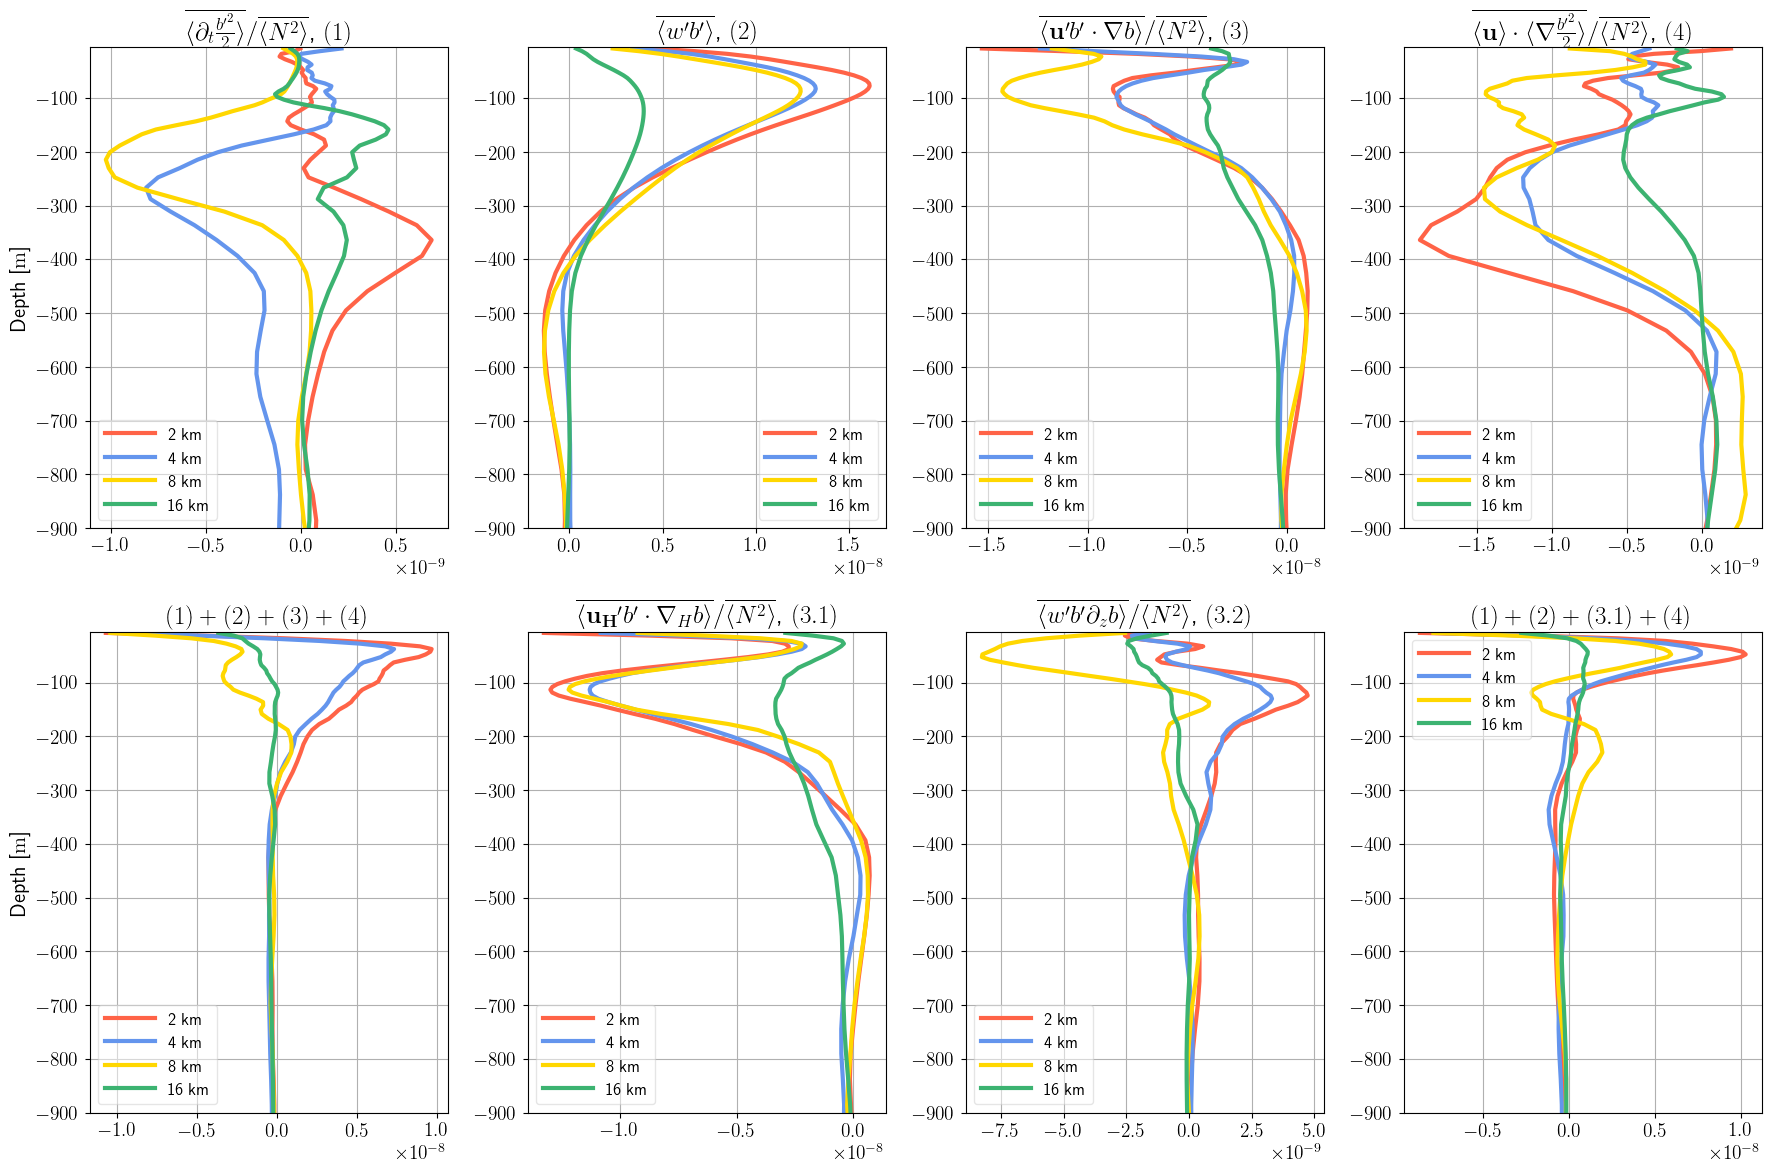

In [27]:
fig = plt.figure(figsize=(18,12), dpi=100, tight_layout=True)
# colours = ['grey', 'darkgreen','royalblue','turquoise','salmon','royalblue', 'red', 'orange']

titles = [r'$\overline{\langle  \partial_t\frac{{b^{\prime}}^{2}}{2} \rangle}/ \overline{\langle N^2 \rangle}$, $(1)$' , 
          r'$\overline{\langle w^{\prime}b^{\prime} \rangle}$, $(2)$', 
          r'$\overline{\langle \mathbf{u}^{\prime}b^{\prime} \cdot \nabla b \rangle}/\overline{\langle N^2 \rangle}$, $(3)$', 
          r'$\overline{\langle \mathbf{u} \rangle \cdot \langle \nabla \frac{{b^{\prime}}^{2}}{2} \rangle}/ \overline{\langle N^2 \rangle}$, $(4)$', 
          r'$(1)+(2)+(3)+(4)$',
          r'$\overline{\langle \mathbf{u_{H}}^{\prime}b^{\prime} \cdot \nabla_{H} b \rangle}/\overline{\langle N^2 \rangle}$, $(3.1)$' ,
          r'$\overline{\langle w^{\prime}b^{\prime} \partial_z b \rangle}/\overline{\langle N^2 \rangle}$, $(3.2)$', 
          r'$(1)+(2)+(3.1)+(4)$',
           ]

labels = {'2km': '2 km','4km': '4 km','8km': '8 km','16km': '16 km',}
colours = {'2km': colors[0],'4km': colors[1],'8km': colors[2],'16km': colors[3]}
plt.subplot(241)
for i, r in enumerate(res):
    plt.plot((time_mean_PE[r].bp2_tend/(2*Nsq0[r])).sel(Z=slice(-5,-1000)), time_mean_PE[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.title(titles[0], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(242)
for i, r in enumerate(res):
    plt.plot(time_mean_PE[r].wpbp.sel(Z=slice(-5,-1000)), time_mean_PE[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[1], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(243)
for i, r in enumerate(res):
    plt.plot((time_mean_PE[r].Upbpgradb/Nsq0[r]).sel(Z=slice(-5,-1000)), time_mean_PE[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[2], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(244)
for i, r in enumerate(res):
    plt.plot((time_mean_PE[r].Ugradbp2/Nsq0[r]).sel(Z=slice(-5,-1000)), time_mean_PE[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[3], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(245)
for i, r in enumerate(res):
    plt.plot(time_mean_PE[r].LHS.sel(Z=slice(-5,-1000)), time_mean_PE[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.title(titles[4], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(246)
for i, r in enumerate(res):
    plt.plot((time_mean_PE[r].Upbpgradb_h/Nsq0[r]).sel(Z=slice(-5,-1000)), time_mean_PE[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[5], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(247)
for i, r in enumerate(res):
    plt.plot((time_mean_PE[r].Upbpgradb_v/Nsq0[r]).sel(Z=slice(-5,-1000)), time_mean_PE[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[6], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(248)
for i, r in enumerate(res):
    plt.plot(time_mean_PE[r].LHS0.sel(Z=slice(-5,-1000)), time_mean_PE[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[7], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()



In [83]:
ds2['2km'].b

<xarray.DataArray 'b' (time: 4392, Z: 58, YC: 360, XC: 400)>
dask.array<shape=(4392, 58, 360, 400), dtype=float64, chunksize=(6, 58, 360, 400)>
Coordinates:
  * Z        (Z) float32 -2.5 -7.5 -12.5 -17.5 ... -933.755 -982.51 -1031.635
  * XC       (XC) float32 -63.16115 -63.135586 ... -52.984848 -52.95928
  * YC       (YC) float32 29.36571 29.386543 29.407377 ... 36.824043 36.844875
  * time     (time) datetime64[ns] 2048-01-01T02:00:00 ... 2050-01-01T22:00:00

In [94]:
def calc_wpbpBz(ds, grids2):
    grid = xgcm.Grid(grids2, periodic=['X','Y','Z'])
    wp = ds.w - ds.w.mean(dim=['XC','YC'])
    bp = ds.b - ds.b.mean(dim=['XC','YC'])
    B_z = -grid.diff(ds.b,'Z')/grids2.drC.values[np.newaxis, :, np.newaxis, np.newaxis]
    wpbpBz = (B_z*wp*grid.interp(bp, 'Z')).isel(XC=slice(1,-1),YC=slice(1,-1)).mean(dim=['XC','YC'])
    wpbp = (wp*grid.interp(bp, 'Z')).isel(XC=slice(1,-1),YC=slice(1,-1)).mean(dim=['XC','YC'])
    ds_wpBp = xr.merge([wpbp.to_dataset(name='wpbp'), wpbpBz.to_dataset(name='wpbpBz'), ])
    return ds_wpBp


In [95]:
%%time
ds_wpBp = {}
for r in res:
    ds_wpBp[r] = calc_wpbpBz(ds2[r], grids2[r])
    print(r)
    ds_wpBp[r] = ds_wpBp[r].load()
    print('Finished loading, ', r)

2km
Finished loading,  2km
4km
Finished loading,  4km
8km
Finished loading,  8km
16km
Finished loading,  16km
CPU times: user 31min 31s, sys: 21min 49s, total: 53min 20s
Wall time: 25min 50s


In [132]:
Nsq1_ts = {}
Nsq1 = {}
Nsq2 = {}
for r in res:
    Nsq1_ts[r] = (ds_wpBp[r].wpbpBz)/(ds_wpBp[r].wpbp)
    Nsq2[r] = (ds_wpBp[r].wpbpBz.mean(dim='time'))/(ds_wpBp[r].wpbp.mean(dim='time'))
    Nsq1[r] = Nsq1_ts[r].mean(dim='time')

In [144]:
grid = {}
Nsq1 = {}
for r in res:
    grid[r] = xgcm.Grid(grids2[r], periodic=['X','Y','Z'])
    Nsq1[r] = grid[r].interp((ds_wpBp[r].wpbpBz.mean(dim='time'))/(ds_wpBp[r].wpbp.mean(dim='time')), 'Z')


In [116]:
inv_Nsq = {}
grid = {}
for r in res:
    grid[r] = xgcm.Grid(grids2[r], periodic=['X','Y','Z'])
    inv_Nsq[r] = grid[r].interp((ds_wpBp[r].wpbp.mean(dim='time'))/(ds_wpBp[r].wpbpBz.mean(dim='time')), 'Z')


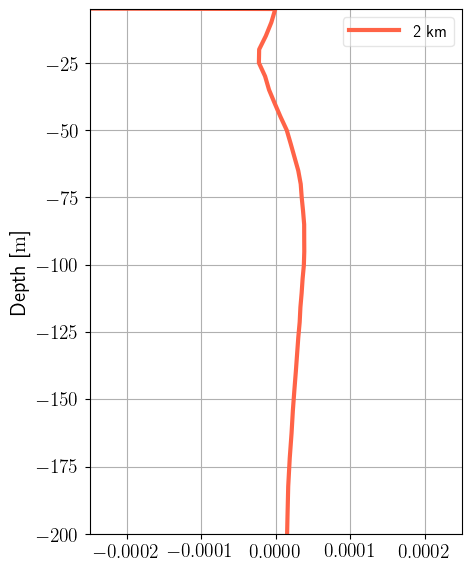

In [126]:
fig = plt.figure(figsize=(5,6), dpi=100, tight_layout=True)

plt.plot((ds_wpBp['2km'].wpbpBz.mean(dim='time'))/(ds_wpBp['2km'].wpbp.mean(dim='time')), ds_wpBp['2km'].Zl, linewidth=3, color = colours['2km'],label=labels['2km'])
plt.ylim([-200,-5])
plt.xlim([-2.5e-4,2.5e-4])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

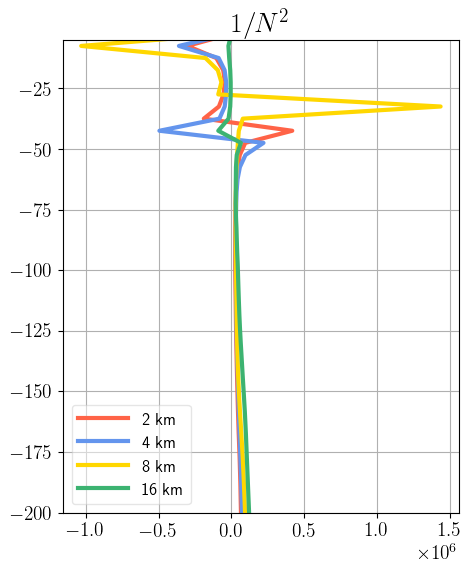

In [141]:
fig = plt.figure(figsize=(5,6), dpi=100, tight_layout=True)
for r in res:
    plt.plot((1/ Nsq1[r]), time_mean_PE_m[r].Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-200,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(r'$1/N^2$')
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()


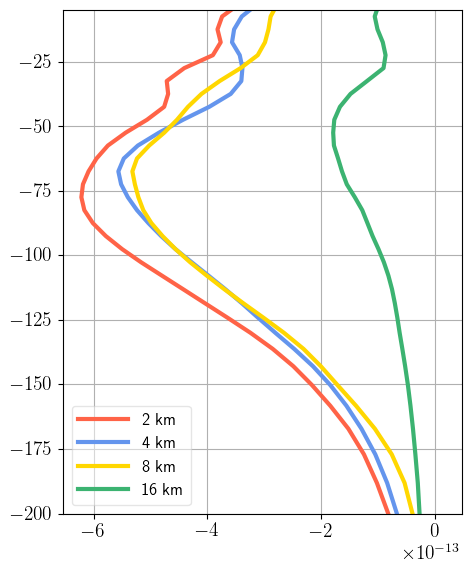

In [129]:
fig = plt.figure(figsize=(5,6), dpi=100, tight_layout=True)
for i, r in enumerate(res):
    plt.plot((time_mean_PE_m[r].Upbpgradb_h), time_mean_PE_m[r].Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-200,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
# plt.title(titles[5], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()


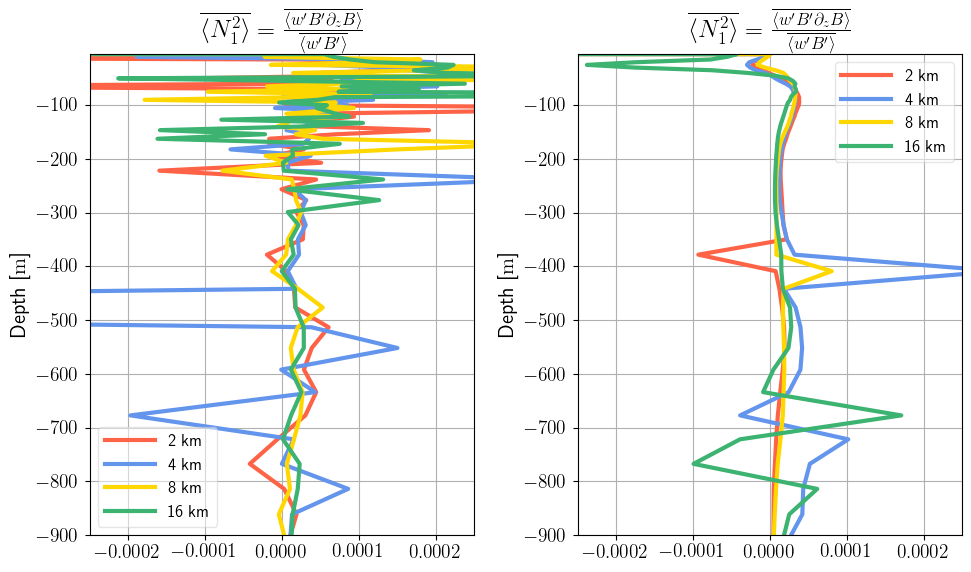

In [111]:
fig = plt.figure(figsize=(10,6), dpi=100, tight_layout=True)
plt.subplot(121)

for i, r in enumerate(res):
    plt.plot(Nsq1[r], Nsq1[r].Zl, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
plt.xlim([-2.5e-4,2.5e-4])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.title(titles[3], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(122)

for i, r in enumerate(res):
    plt.plot(Nsq2[r], Nsq2[r].Zl, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
plt.xlim([-2.5e-4,2.5e-4])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.title(titles[3], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()


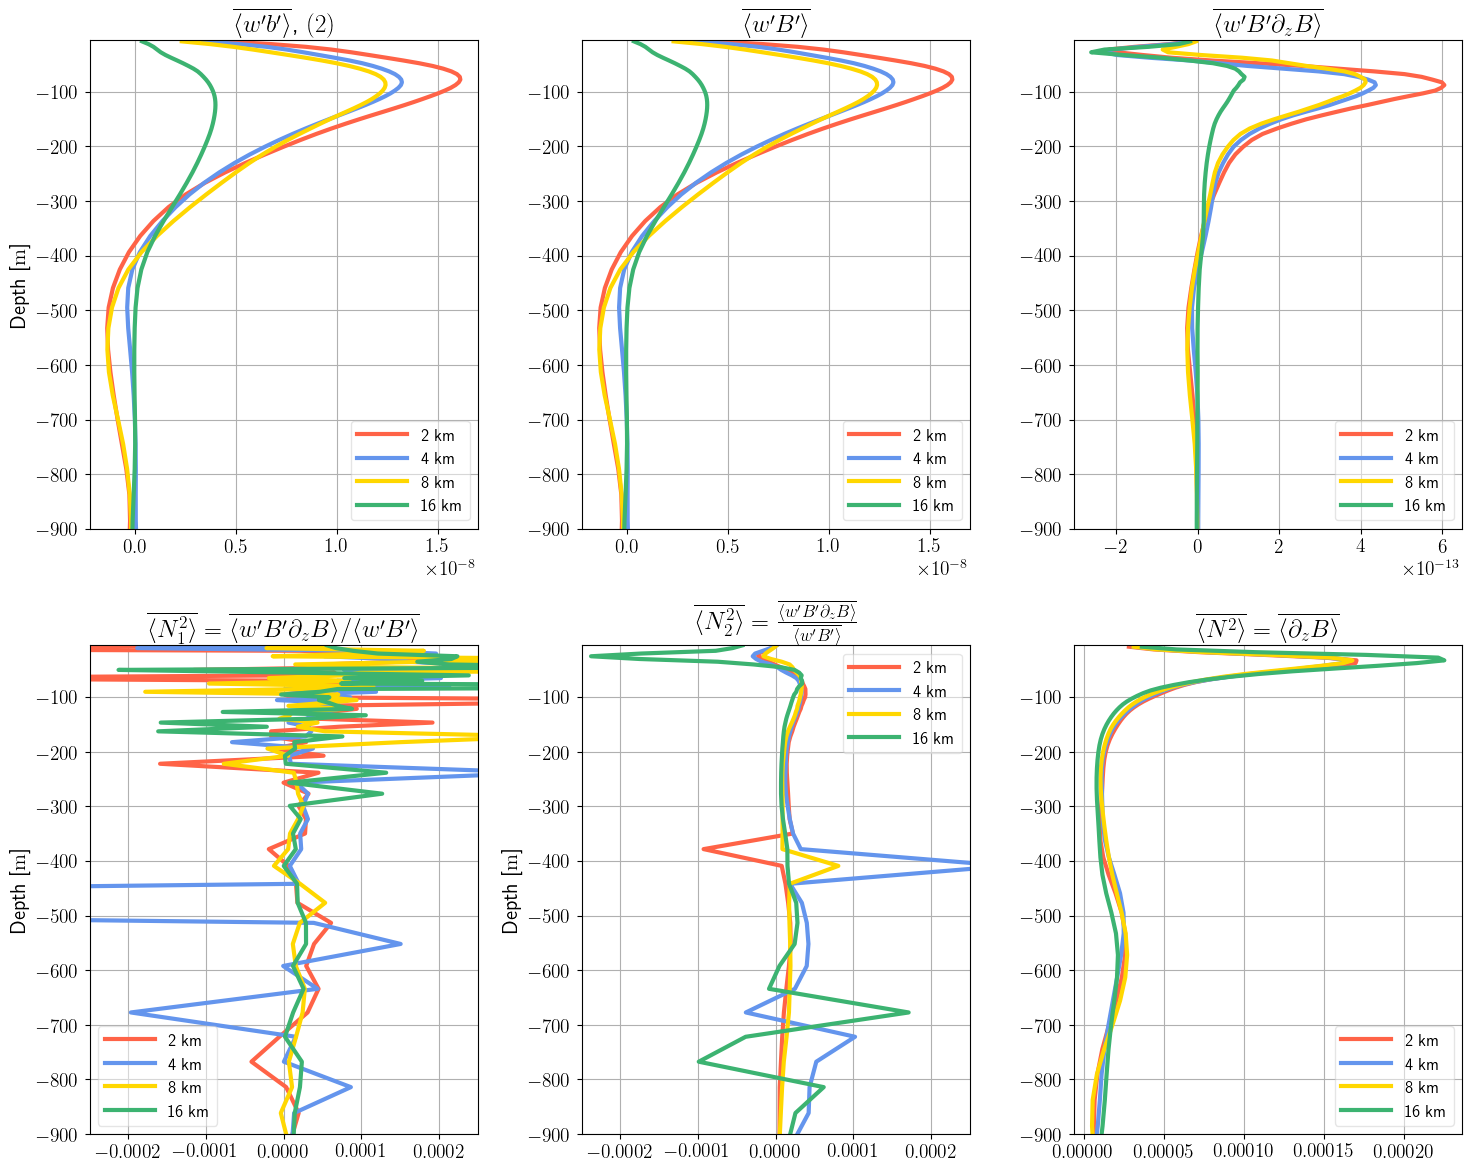

In [135]:
fig = plt.figure(figsize=(15,12), dpi=100, tight_layout=True)
# colours = ['grey', 'darkgreen','royalblue','turquoise','salmon','royalblue', 'red', 'orange']

titles = [r'$\overline{\langle w^{\prime}b^{\prime} \rangle}$, $(2)$', 
          r'$\overline{\langle w^{\prime}B^{\prime} \rangle}$', 
          r'$\overline{\langle w^{\prime}B^{\prime} \partial_z B\rangle}$', 
          r'$\overline{\langle N_1^2 \rangle} = \overline{\langle w^{\prime}B^{\prime} \partial_z B\rangle / \langle w^{\prime}B^{\prime} \rangle}$',
          r'$\overline{\langle N_2^2 \rangle} = \frac{\overline{\langle w^{\prime}B^{\prime} \partial_z B\rangle}}{\overline{\langle w^{\prime}B^{\prime} \rangle}}$',
          r'$\overline{\langle N^2 \rangle} = \overline{\langle \partial_z B \rangle}$',
          r'$\overline{\langle \mathbf{u_{H}}^{\prime}b^{\prime} \cdot \nabla_{H} b \rangle}/\overline{\langle N^2 \rangle}$, $(3.1)$' ,
           ]

labels = {'2km': '2 km','4km': '4 km','8km': '8 km','16km': '16 km',}
colours = {'2km': colors[0],'4km': colors[1],'8km': colors[2],'16km': colors[3]}
plt.subplot(231)
for i, r in enumerate(res):
    plt.plot(time_mean_PE_2[r].wpbp.sel(Z=slice(-5,-1000)), time_mean_PE_2[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.title(titles[0], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(232)
for i, r in enumerate(res):
    plt.plot(wpbp[r].mean(dim='time').sel(Z=slice(-5,-1000)), wpbp[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[1], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(233)
for i, r in enumerate(res):
    plt.plot(wpbpBz[r].mean(dim='time').sel(Z=slice(-5,-1000)), wpbpBz[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[2], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(234)
for i, r in enumerate(res):
    plt.plot(Nsq1[r].sel(Zl=slice(-5,-1000)), Nsq1[r].sel(Zl=slice(-5,-1000)).Zl, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
plt.xlim([-2.5e-4,2.5e-4])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.title(titles[3], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(235)
for i, r in enumerate(res):
    plt.plot(Nsq2[r].sel(Zl=slice(-5,-1000)), Nsq2[r].sel(Zl=slice(-5,-1000)).Zl, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
plt.xlim([-2.5e-4,2.5e-4])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.title(titles[4], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(236)
for i, r in enumerate(res):
    plt.plot(Nsq0[r].sel(Z=slice(-5,-1000)), Nsq0[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[5], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()


# plt.subplot(236)
# for i, r in enumerate(res):
#     plt.plot((time_mean_PE_m[r].Upbpgradb_h/Nsq1[r]).sel(Z=slice(-5,-1000)), time_mean_PE_m[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
# plt.ylim([-900,-5])
# # plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
# plt.ylabel('')
# plt.title(titles[5], fontsize=18)
# plt.legend(fontsize=12, loc=0, framealpha=0.5)
# plt.grid()



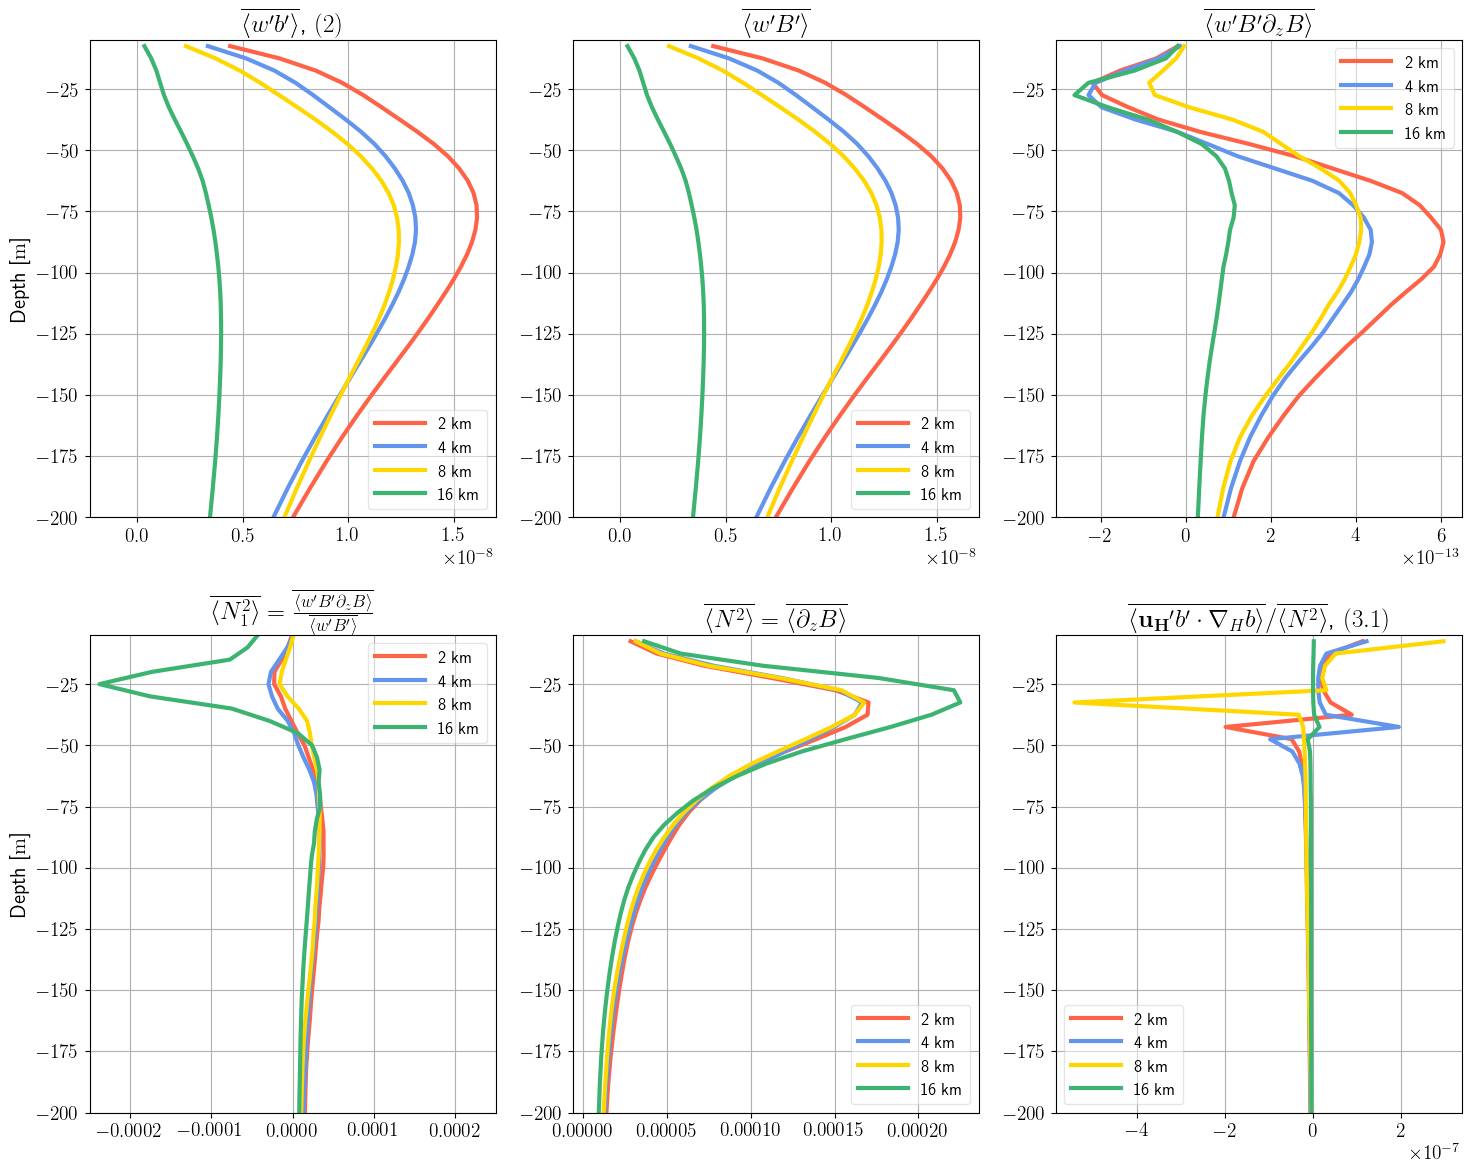

In [142]:
fig = plt.figure(figsize=(15,12), dpi=100, tight_layout=True)
# colours = ['grey', 'darkgreen','royalblue','turquoise','salmon','royalblue', 'red', 'orange']

titles = [r'$\overline{\langle w^{\prime}b^{\prime} \rangle}$, $(2)$', 
          r'$\overline{\langle w^{\prime}B^{\prime} \rangle}$', 
          r'$\overline{\langle w^{\prime}B^{\prime} \partial_z B\rangle}$', 
          r'$\overline{\langle N_1^2 \rangle} = \overline{\frac{\langle w^{\prime}B^{\prime} \partial_z B\rangle}{\overline{\langle w^{\prime}B^{\prime} \rangle}}}$',
#           r'$\overline{\langle N_2^2 \rangle} = \frac{\overline{\langle w^{\prime}B^{\prime} \partial_z B\rangle}}{\overline{\langle w^{\prime}B^{\prime} \rangle}}$',
          r'$\overline{\langle N^2 \rangle} = \overline{\langle \partial_z B \rangle}$',
          r'$\overline{\langle \mathbf{u_{H}}^{\prime}b^{\prime} \cdot \nabla_{H} b \rangle}/\overline{\langle N^2 \rangle}$, $(3.1)$' ,
           ]

labels = {'2km': '2 km','4km': '4 km','8km': '8 km','16km': '16 km',}
colours = {'2km': colors[0],'4km': colors[1],'8km': colors[2],'16km': colors[3]}
plt.subplot(231)
for i, r in enumerate(res):
    plt.plot(time_mean_PE_2[r].wpbp.sel(Z=slice(-5,-1000)), time_mean_PE_2[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-200,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.title(titles[0], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(232)
for i, r in enumerate(res):
    plt.plot(wpbp[r].mean(dim='time').sel(Z=slice(-5,-1000)), wpbp[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-200,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[1], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(233)
for i, r in enumerate(res):
    plt.plot(wpbpBz[r].mean(dim='time').sel(Z=slice(-5,-1000)), wpbpBz[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-200,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[2], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()


plt.subplot(234)
for i, r in enumerate(res):
    plt.plot(Nsq2[r].sel(Zl=slice(-5,-1000)), Nsq2[r].sel(Zl=slice(-5,-1000)).Zl, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-200,-5])
plt.xlim([-2.5e-4,2.5e-4])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.title(titles[3], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(235)
for i, r in enumerate(res):
    plt.plot(Nsq0[r].sel(Z=slice(-5,-1000)), Nsq0[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-200,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[4], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()


plt.subplot(236)
for i, r in enumerate(res):
    plt.plot((time_mean_PE_m[r].Upbpgradb_h/Nsq1[r]).sel(Z=slice(-5,-1000)), time_mean_PE_m[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-200,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[5], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()



In [143]:
Nsq1w = {}
for r in res:
    
    Nsq1w[r] = grid[r].interp((ds_wpBp[r].wpbpBz.sel(time=is_jfm(ds_b[r]['time.month'])).mean(dim='time'))/(ds_wpBp[r].wpbp.sel(time=is_jfm(ds_b[r]['time.month'])).mean(dim='time')), 'Z')


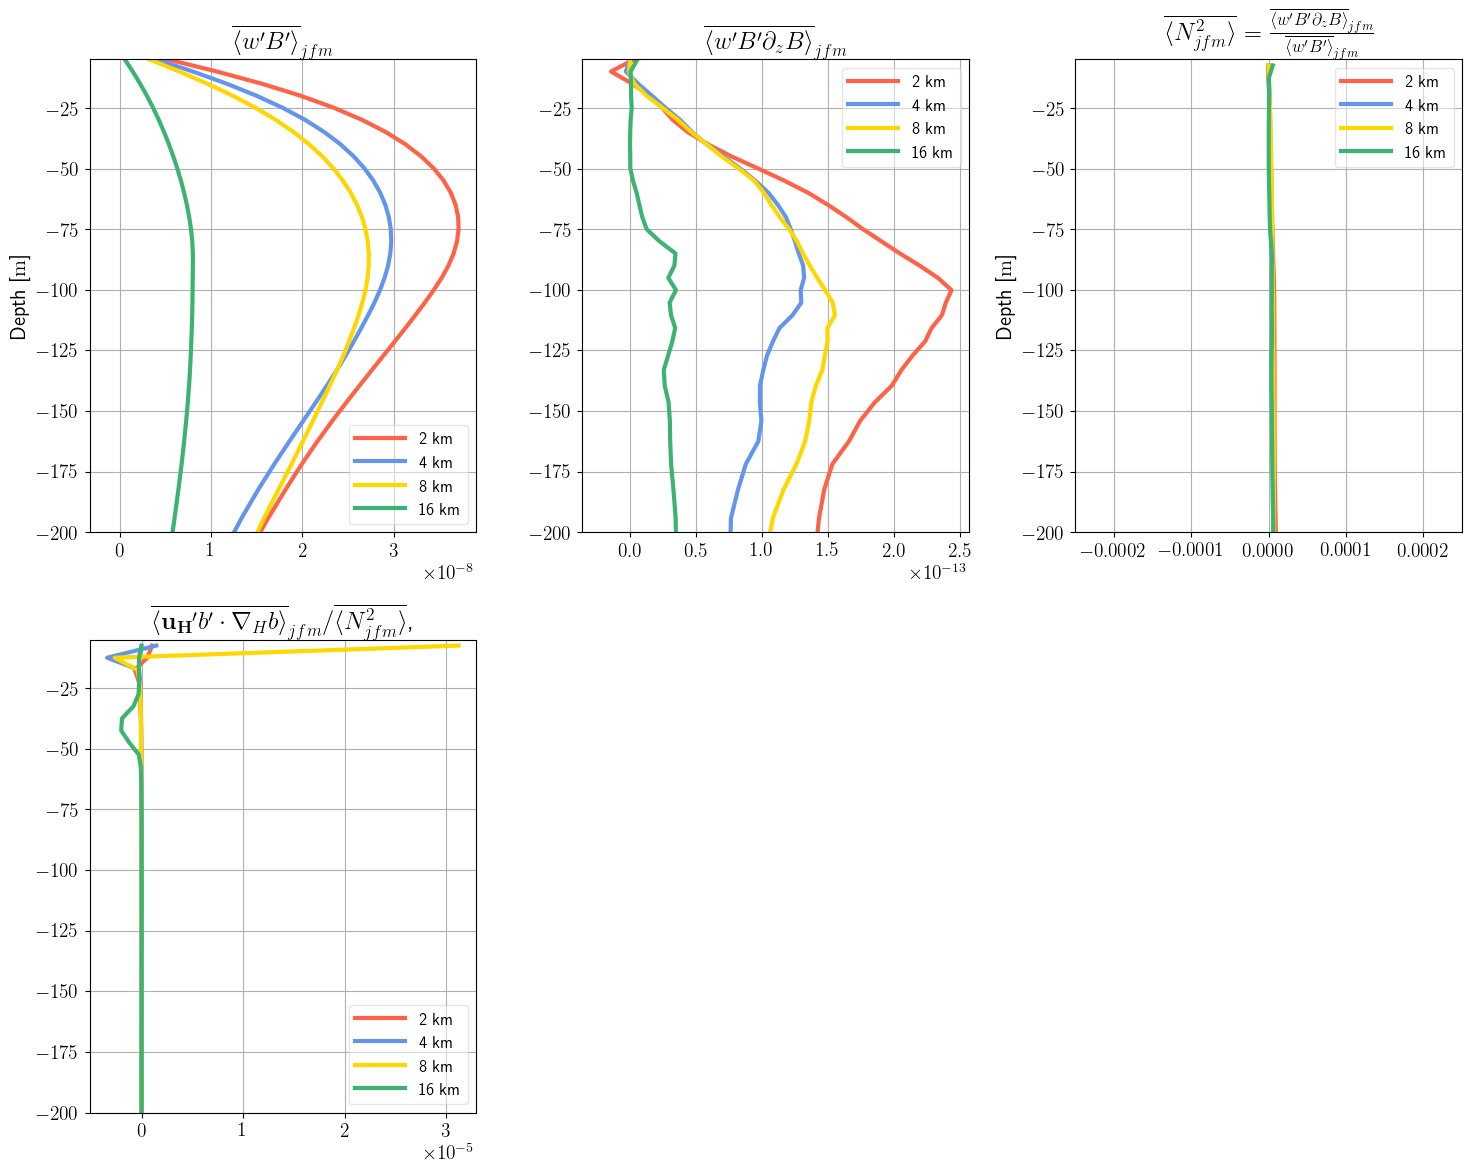

In [152]:
fig = plt.figure(figsize=(15,12), dpi=100, tight_layout=True)
# colours = ['grey', 'darkgreen','royalblue','turquoise','salmon','royalblue', 'red', 'orange']

titles = [r'$\overline{\langle w^{\prime}B^{\prime} \rangle}_{jfm}$', 
          r'$\overline{\langle w^{\prime}B^{\prime} \partial_z B\rangle}_{jfm}$', 
          r'$\overline{\langle N_{jfm}^2 \rangle} =\frac{ \overline{\langle w^{\prime}B^{\prime} \partial_z B\rangle}_{jfm}}{\overline{\langle w^{\prime}B^{\prime} \rangle}_{jfm}}$',
#           r'$\overline{\langle N_2^2 \rangle} = \frac{\overline{\langle w^{\prime}B^{\prime} \partial_z B\rangle}}{\overline{\langle w^{\prime}B^{\prime} \rangle}}$',
          r'$\overline{\langle \mathbf{u_{H}}^{\prime}b^{\prime} \cdot \nabla_{H} b \rangle}_{jfm}/\overline{\langle N_{jfm}^2 \rangle}$,' ,
           ]

labels = {'2km': '2 km','4km': '4 km','8km': '8 km','16km': '16 km',}
colours = {'2km': colors[0],'4km': colors[1],'8km': colors[2],'16km': colors[3]}
plt.subplot(231)
for i, r in enumerate(res):
    plt.plot(ds_wpBp[r].wpbp.sel(time=is_jfm(ds_b[r]['time.month'])).mean(dim='time').sel(Zl=slice(-5,-1000)), ds_wpBp[r].sel(Zl=slice(-5,-1000)).Zl, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-200,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.title(titles[0], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()


plt.subplot(232)
for i, r in enumerate(res):
    plt.plot(ds_wpBp[r].wpbpBz.sel(time=is_jfm(ds_b[r]['time.month'])).mean(dim='time').sel(Zl=slice(-5,-1000)), ds_wpBp[r].sel(Zl=slice(-5,-1000)).Zl, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-200,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[1], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()


plt.subplot(233)
for i, r in enumerate(res):
    plt.plot(Nsq1w[r].sel(Z=slice(-5,-1000)), Nsq1w[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-200,-5])
plt.xlim([-2.5e-4,2.5e-4])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.title(titles[2], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()


plt.subplot(234)
for i, r in enumerate(res):
    plt.plot((ds_PEb_m[r].Upbpgradb_h.sel(time=is_jfm(ds_b[r]['time.month'])).mean(dim='time')/Nsq1w[r]).sel(Z=slice(-5,-1000)), ds_PEb_m[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-200,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[3], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()



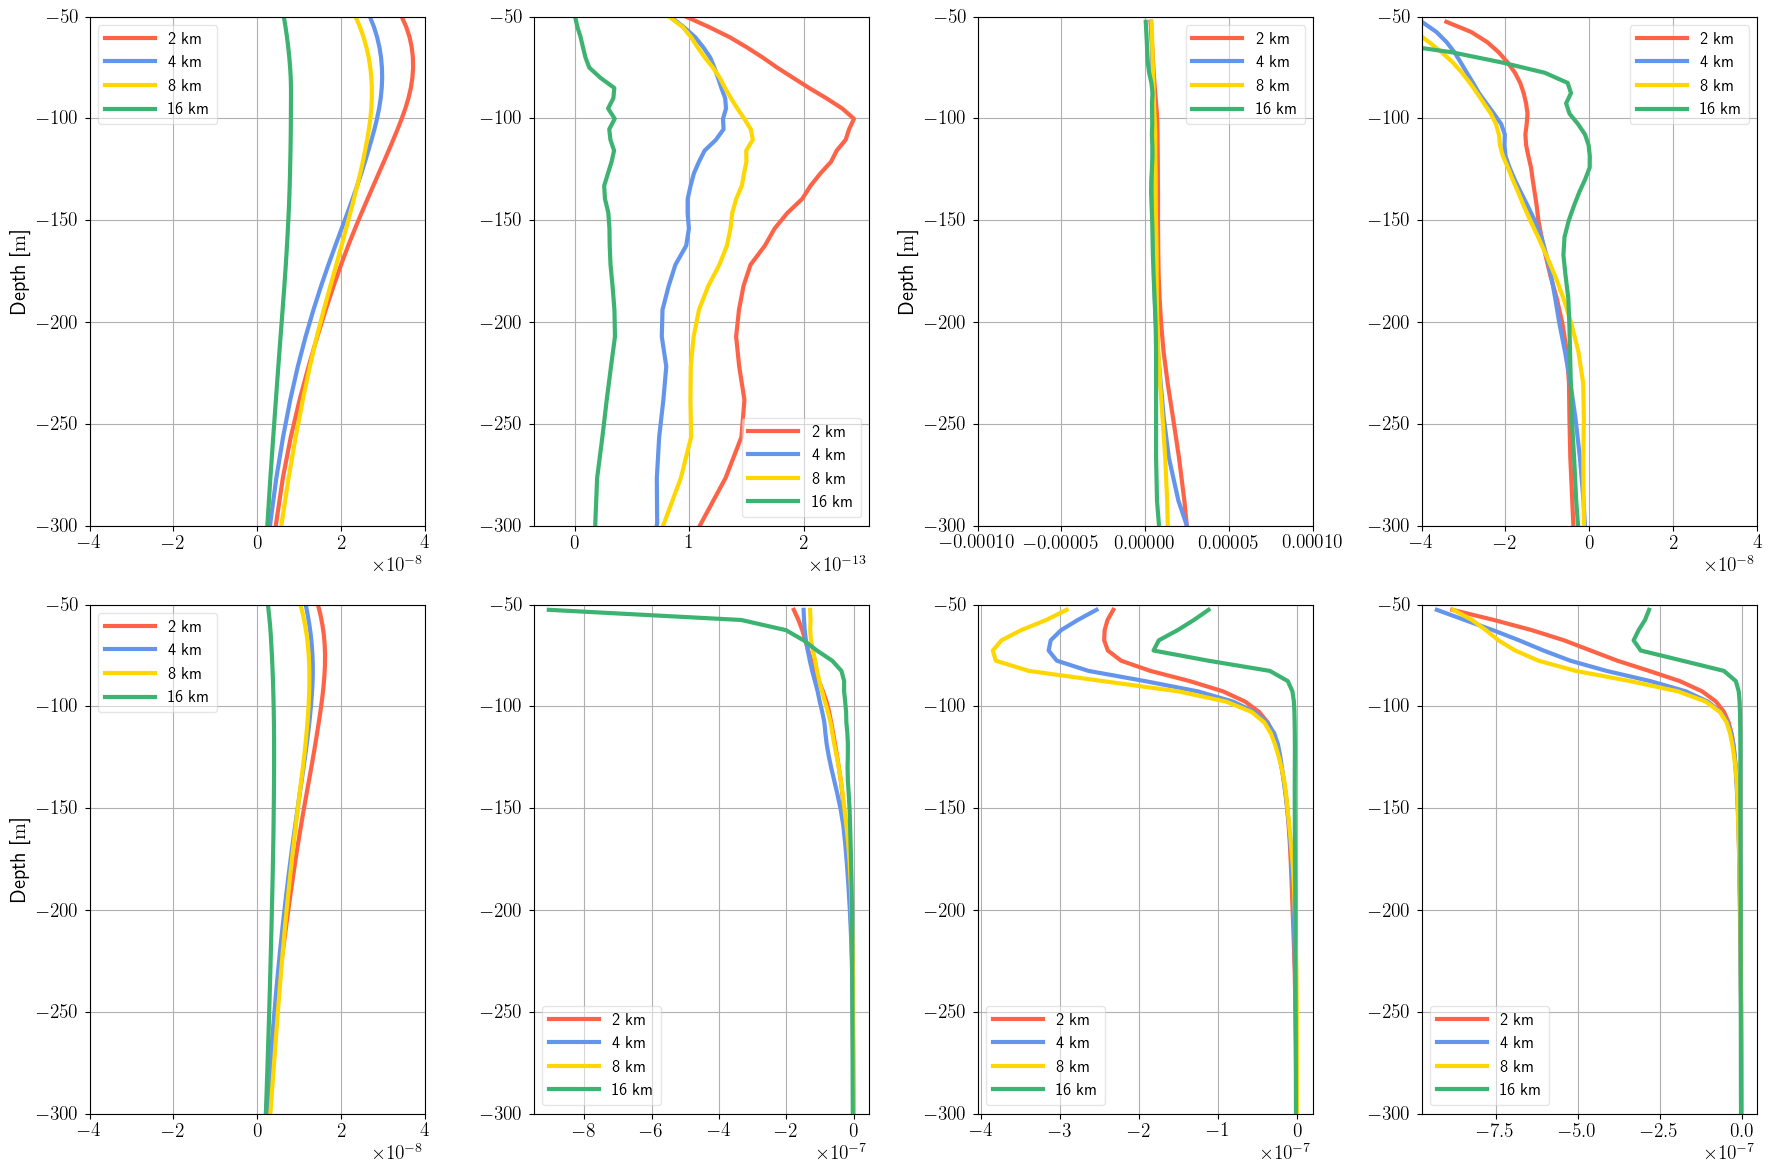

In [166]:
fig = plt.figure(figsize=(18,12), dpi=100, tight_layout=True)
# colours = ['grey', 'darkgreen','royalblue','turquoise','salmon','royalblue', 'red', 'orange']

# titles = [r'$\overline{\langle w^{\prime}B^{\prime} \rangle}_{jfm}$', 
#           r'$\overline{\langle w^{\prime}B^{\prime} \partial_z B\rangle}_{jfm}$', 
#           r'$\overline{\langle N^2 \rangle}_{jfm} =\frac{ \overline{\langle w^{\prime}B^{\prime} \partial_z B\rangle}_{jfm}}{\overline{\langle w^{\prime}B^{\prime} \rangle}_{jfm}}$',
#           r'$\overline{\langle \mathbf{u_{H}}^{\prime}b^{\prime} \cdot \nabla_{H} b \rangle}_{jfm}/\overline{\langle N^2 \rangle}_{jfm}$,' ,
#            r'$\overline{\langle w^{\prime}B^{\prime} \rangle}$', 
#         r'$\overline{\langle \mathbf{u_{H}}^{\prime}b^{\prime} \cdot \nabla_{H} b \rangle}/\overline{\langle N^2 \rangle}_{jfm}$,'
#         r'$\overline{\langle \mathbf{u_{H}}^{\prime}b^{\prime} \cdot \nabla_{H} b \rangle}/\overline{\langle N^2 \rangle}_{jfm}$,'
#         r'$\overline{\langle \mathbf{u^{\prime}b^{\prime} \cdot \nabla b \rangle}/\overline{\langle N^2 \rangle}_{jfm}$,'
#          ]

labels = {'2km': '2 km','4km': '4 km','8km': '8 km','16km': '16 km',}
colours = {'2km': colors[0],'4km': colors[1],'8km': colors[2],'16km': colors[3]}
plt.subplot(241)
for i, r in enumerate(res):
    plt.plot(ds_wpBp[r].wpbp.sel(time=is_jfm(ds_b[r]['time.month'])).mean(dim='time').sel(Zl=slice(-50,-1000)), ds_wpBp[r].sel(Zl=slice(-50,-1000)).Zl, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-300,-50])
plt.xlim([-4e-8,4e-8])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
# plt.title(titles[0], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()


plt.subplot(242)
for i, r in enumerate(res):
    plt.plot(ds_wpBp[r].wpbpBz.sel(time=is_jfm(ds_b[r]['time.month'])).mean(dim='time').sel(Zl=slice(-50,-1000)), ds_wpBp[r].sel(Zl=slice(-50,-1000)).Zl, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-300,-50])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
# plt.title(titles[1], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()


plt.subplot(243)
for i, r in enumerate(res):
    plt.plot(Nsq1w[r].sel(Z=slice(-50,-1000)), Nsq1w[r].sel(Z=slice(-50,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-300,-50])
plt.xlim([-1e-4,1e-4])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
# plt.title(titles[2], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()


plt.subplot(244)
for i, r in enumerate(res):
    plt.plot((ds_PEb_m[r].Upbpgradb_h.sel(time=is_jfm(ds_b[r]['time.month'])).mean(dim='time')/Nsq1w[r]).sel(Z=slice(-50,-1000)), ds_PEb_m[r].sel(Z=slice(-50,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-300,-50])
plt.xlim([-4e-8,4e-8])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
# plt.title(titles[3], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(245)
for i, r in enumerate(res):
    plt.plot(ds_wpBp[r].wpbp.mean(dim='time').sel(Zl=slice(-50,-1000)), ds_wpBp[r].sel(Zl=slice(-50,-1000)).Zl, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-300,-50])
plt.xlim([-4e-8,4e-8])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
# plt.title(titles[4], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(246)
for i, r in enumerate(res):
    plt.plot((ds_PEb_m[r].Upbpgradb_h.mean(dim='time')/Nsq1w[r]).sel(Z=slice(-50,-1000)), ds_PEb_m[r].sel(Z=slice(-50,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-300,-50])
# plt.xlim([-4e-8,4e-8])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
# plt.title(titles[5], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(247)
for i, r in enumerate(res):
    plt.plot((ds_PEb_m[r].Upbpgradb_h.mean(dim='time')/Nsqw[r]).sel(Z=slice(-50,-1000)), ds_PEb_m[r].sel(Z=slice(-50,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-300,-50])
# plt.xlim([-4e-8,4e-8])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
# plt.title(titles[6], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(248)
for i, r in enumerate(res):
    plt.plot((ds_PEb_m[r].Upbpgradb.mean(dim='time')/Nsqw[r]).sel(Z=slice(-50,-1000)), ds_PEb_m[r].sel(Z=slice(-50,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-300,-50])
# plt.xlim([-4e-8,4e-8])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
# plt.title(titles[7], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()


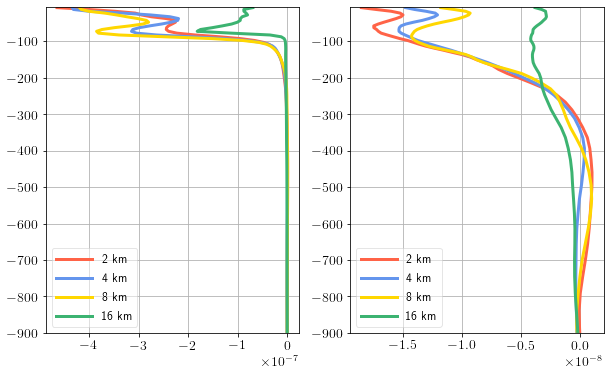

In [168]:
plt.figure(figsize=(10,6))
plt.subplot(121)
for i, r in enumerate(res):
    plt.plot((ds_PEb_m[r].Upbpgradb_h.mean(dim='time')/Nsqw[r]).sel(Z=slice(-5,-1000)), ds_PEb_m[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.xlim([-4e-8,4e-8])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
# plt.title(titles[6], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(122)
for i, r in enumerate(res):
    plt.plot((ds_PEb_m[r].Upbpgradb.mean(dim='time')/Nsq0[r]).sel(Z=slice(-5,-1000)), ds_PEb_m[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.xlim([-4e-8,4e-8])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
# plt.title(titles[6], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()


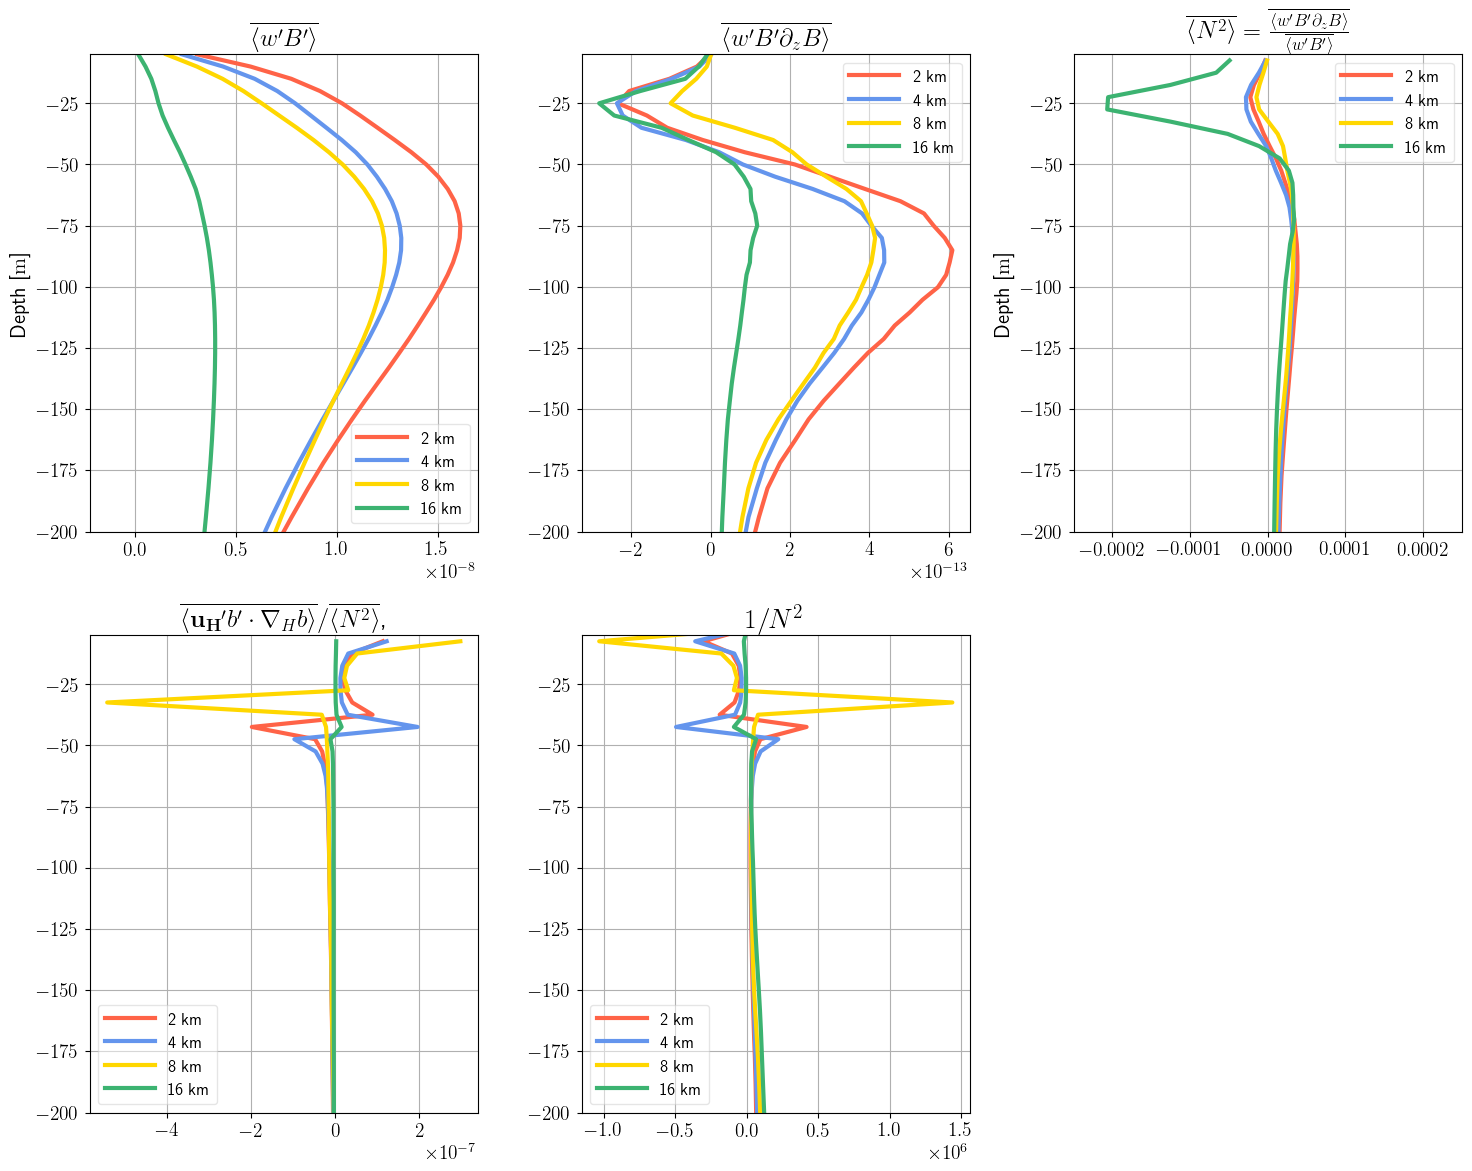

In [160]:
fig = plt.figure(figsize=(15,12), dpi=100, tight_layout=True)
# colours = ['grey', 'darkgreen','royalblue','turquoise','salmon','royalblue', 'red', 'orange']

titles = [r'$\overline{\langle w^{\prime}B^{\prime} \rangle}$', 
          r'$\overline{\langle w^{\prime}B^{\prime} \partial_z B\rangle}$', 
          r'$\overline{\langle N^2 \rangle} = \overline{\frac{\langle w^{\prime}B^{\prime} \partial_z B\rangle}{\overline{\langle w^{\prime}B^{\prime} \rangle}}}$',
          r'$\overline{\langle \mathbf{u_{H}}^{\prime}b^{\prime} \cdot \nabla_{H} b \rangle}/\overline{\langle N^2 \rangle}$,' ,
           ]


labels = {'2km': '2 km','4km': '4 km','8km': '8 km','16km': '16 km',}
colours = {'2km': colors[0],'4km': colors[1],'8km': colors[2],'16km': colors[3]}
plt.subplot(231)
for i, r in enumerate(res):
    plt.plot(ds_wpBp[r].wpbp.mean(dim='time').sel(Zl=slice(-5,-1000)), ds_wpBp[r].sel(Zl=slice(-5,-1000)).Zl, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-200,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.title(titles[0], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()


plt.subplot(232)
for i, r in enumerate(res):
    plt.plot(ds_wpBp[r].wpbpBz.mean(dim='time').sel(Zl=slice(-5,-1000)), ds_wpBp[r].sel(Zl=slice(-5,-1000)).Zl, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-200,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[1], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()


plt.subplot(233)
for i, r in enumerate(res):
    plt.plot(Nsq1[r].sel(Z=slice(-5,-1000)), Nsq1[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-200,-5])
plt.xlim([-2.5e-4,2.5e-4])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.title(titles[2], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()


plt.subplot(234)
for i, r in enumerate(res):
    plt.plot((time_mean_PE_m[r].Upbpgradb_h/Nsq1[r]).sel(Z=slice(-5,-1000)), time_mean_PE_m[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-200,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[3], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(235)

for r in res:
    plt.plot((1/ Nsq1[r]), time_mean_PE_m[r].Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-200,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(r'$1/N^2$')
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()


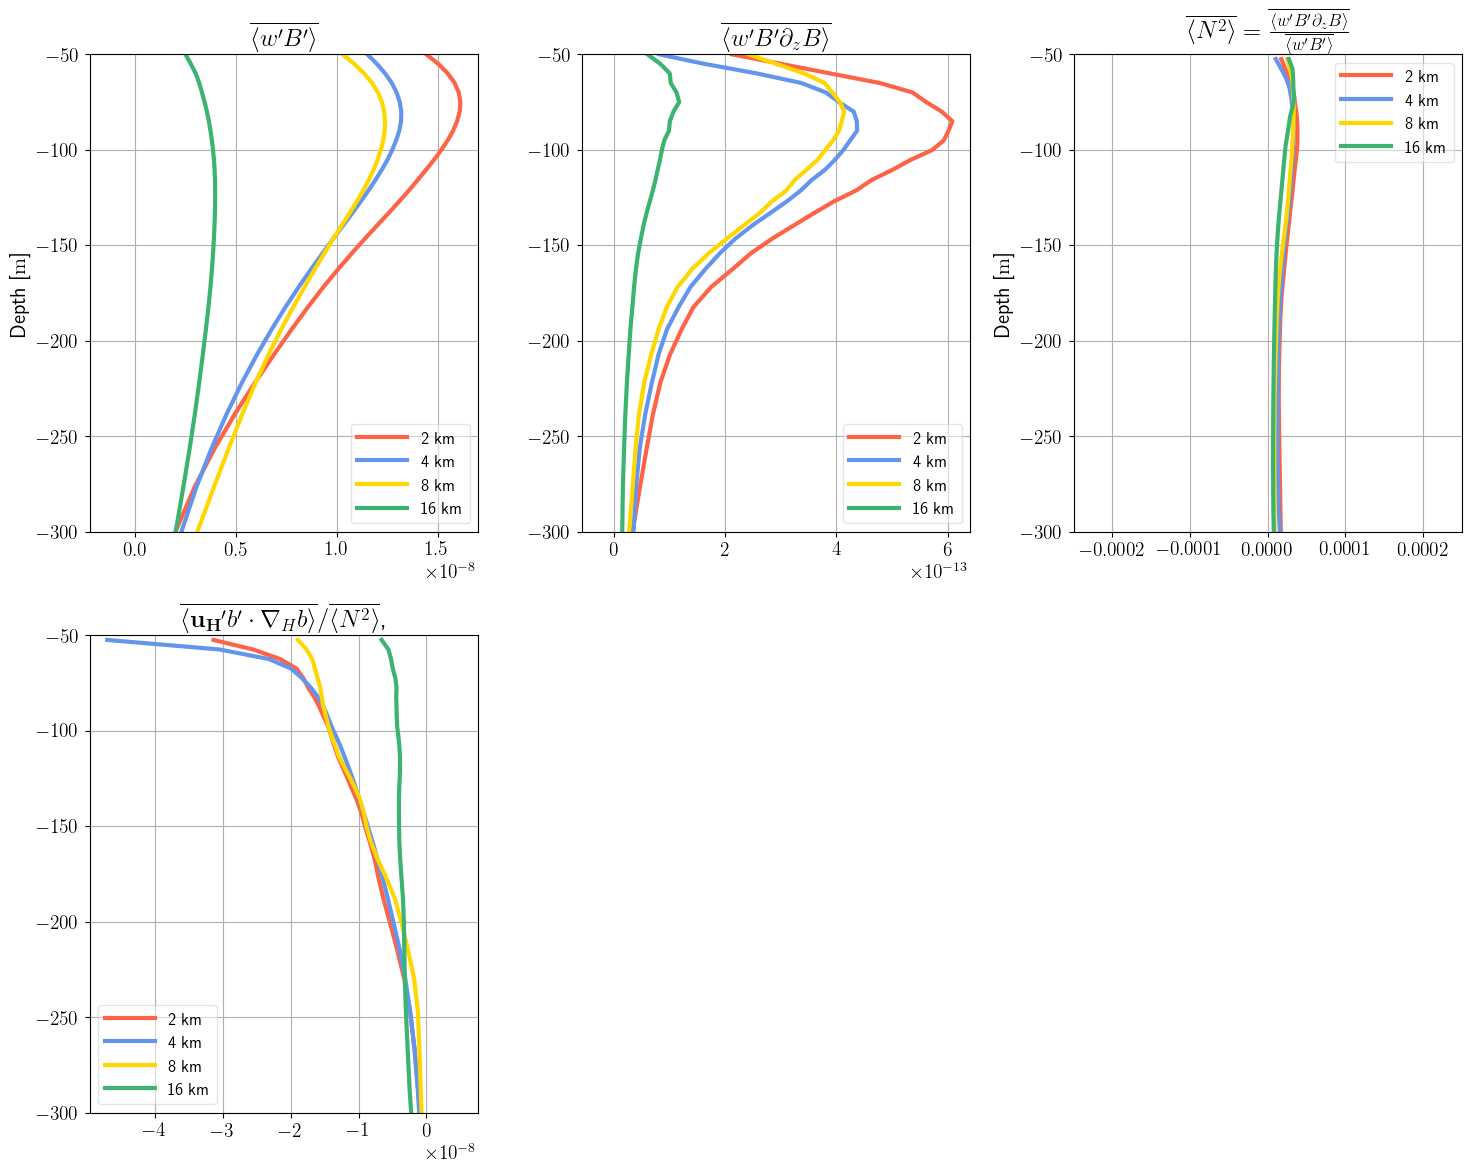

In [158]:
fig = plt.figure(figsize=(15,12), dpi=100, tight_layout=True)
# colours = ['grey', 'darkgreen','royalblue','turquoise','salmon','royalblue', 'red', 'orange']

titles = [r'$\overline{\langle w^{\prime}B^{\prime} \rangle}$', 
          r'$\overline{\langle w^{\prime}B^{\prime} \partial_z B\rangle}$', 
          r'$\overline{\langle N^2 \rangle} = \overline{\frac{\langle w^{\prime}B^{\prime} \partial_z B\rangle}{\overline{\langle w^{\prime}B^{\prime} \rangle}}}$',
          r'$\overline{\langle \mathbf{u_{H}}^{\prime}b^{\prime} \cdot \nabla_{H} b \rangle}/\overline{\langle N^2 \rangle}$,' ,
           ]


labels = {'2km': '2 km','4km': '4 km','8km': '8 km','16km': '16 km',}
colours = {'2km': colors[0],'4km': colors[1],'8km': colors[2],'16km': colors[3]}
plt.subplot(231)
for i, r in enumerate(res):
    plt.plot(ds_wpBp[r].wpbp.mean(dim='time').sel(Zl=slice(-50,-1000)), ds_wpBp[r].sel(Zl=slice(-50,-1000)).Zl, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-300,-50])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.title(titles[0], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()


plt.subplot(232)
for i, r in enumerate(res):
    plt.plot(ds_wpBp[r].wpbpBz.mean(dim='time').sel(Zl=slice(-50,-1000)), ds_wpBp[r].sel(Zl=slice(-50,-1000)).Zl, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-300,-50])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[1], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()


plt.subplot(233)
for i, r in enumerate(res):
    plt.plot(Nsq1[r].sel(Z=slice(-50,-1000)), Nsq1[r].sel(Z=slice(-50,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-300,-50])
plt.xlim([-2.5e-4,2.5e-4])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.title(titles[2], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()


plt.subplot(234)
for i, r in enumerate(res):
    plt.plot((time_mean_PE_m[r].Upbpgradb_h/Nsq1[r]).sel(Z=slice(-50,-1000)), time_mean_PE_m[r].sel(Z=slice(-50,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-300,-50])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[3], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()



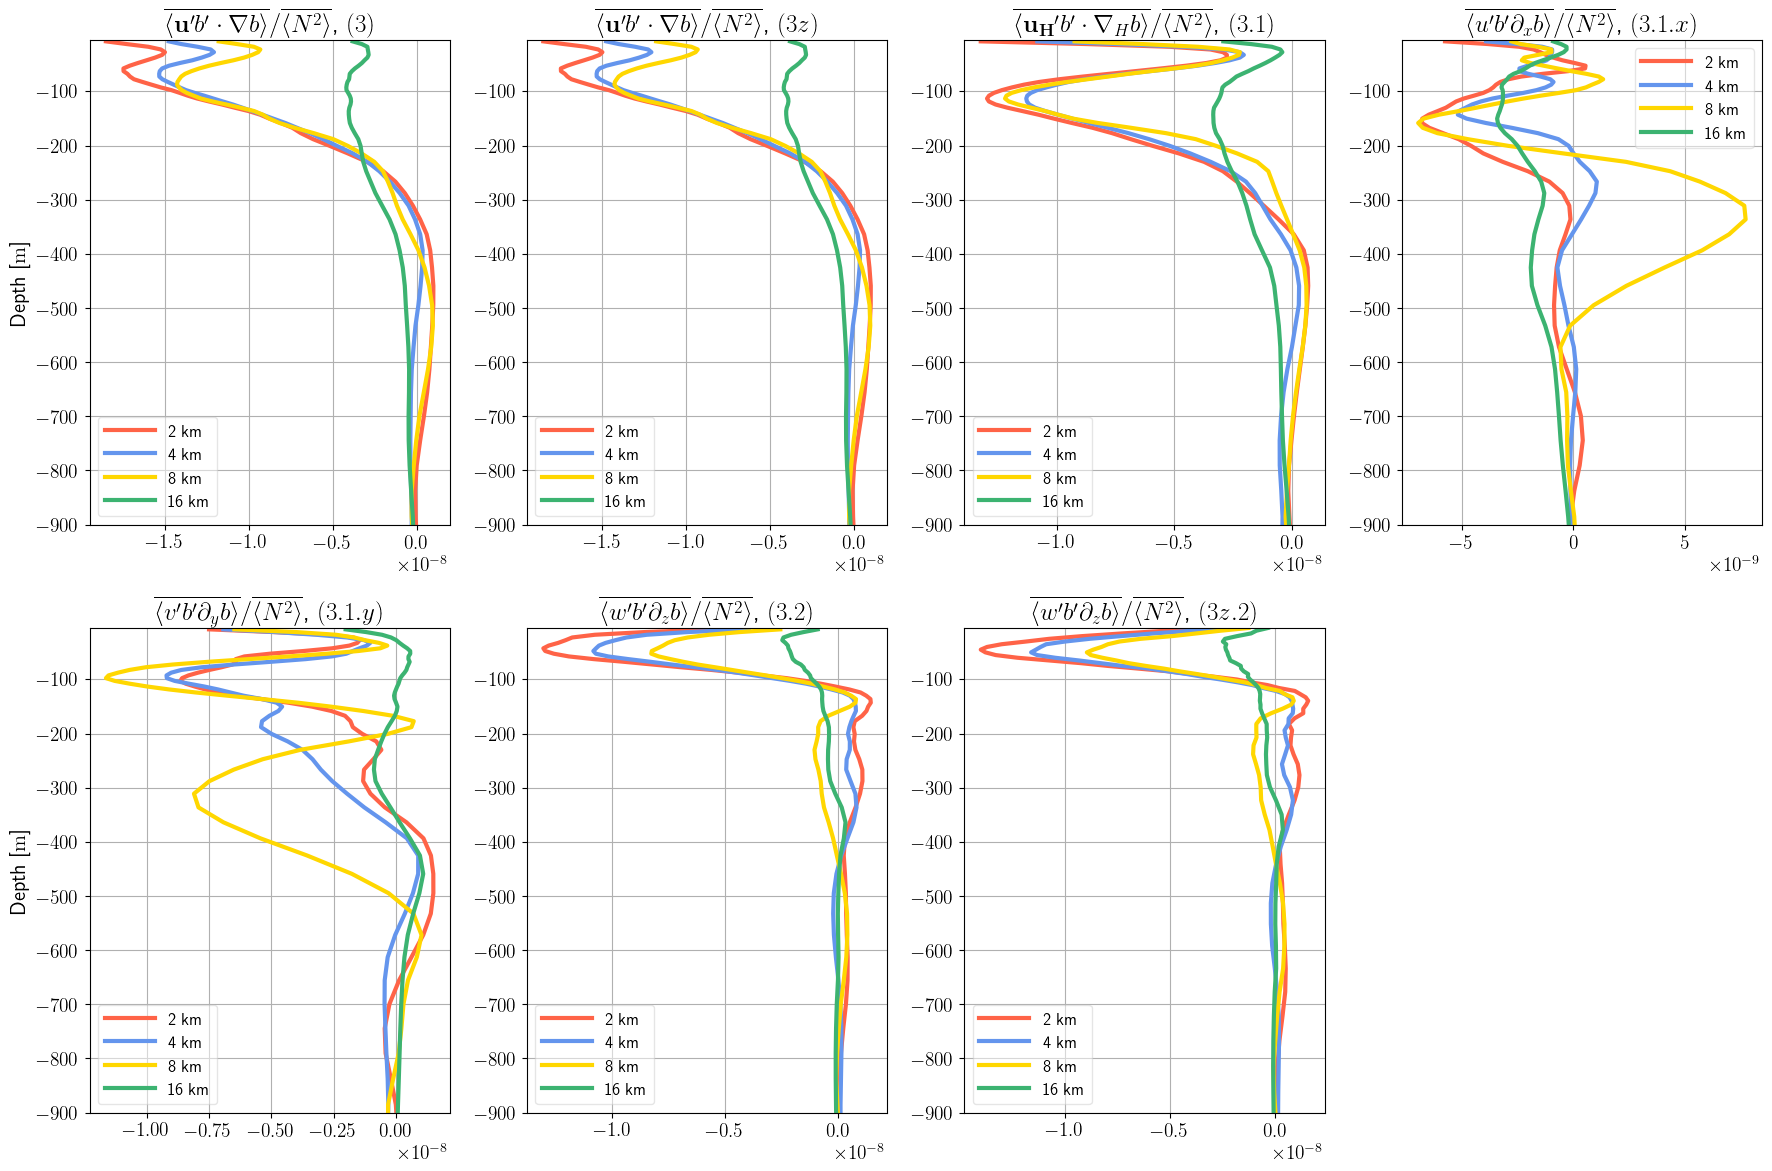

In [36]:
fig = plt.figure(figsize=(18,12), dpi=100, tight_layout=True)
# colours = ['grey', 'darkgreen','royalblue','turquoise','salmon','royalblue', 'red', 'orange']

titles = [r'$\overline{\langle \mathbf{u}^{\prime}b^{\prime} \cdot \nabla b \rangle}/\overline{\langle N^2 \rangle}$, $(3)$', 
          r'$\overline{\langle \mathbf{u}^{\prime}b^{\prime} \cdot \nabla b \rangle}/\overline{\langle N^2 \rangle}$, $(3z)$', 
          r'$\overline{\langle \mathbf{u_{H}}^{\prime}b^{\prime} \cdot \nabla_{H} b \rangle}/\overline{\langle N^2 \rangle}$, $(3.1)$' ,
          r'$\overline{\langle u^{\prime}b^{\prime} \partial_x b \rangle}/\overline{\langle N^2 \rangle}$, $(3.1.x)$' ,
          r'$\overline{\langle v^{\prime}b^{\prime} \partial_y b \rangle}/\overline{\langle N^2 \rangle}$, $(3.1.y)$' ,
          r'$\overline{\langle w^{\prime}b^{\prime} \partial_z b \rangle}/\overline{\langle N^2 \rangle}$, $(3.2)$',
          r'$\overline{\langle w^{\prime}b^{\prime} \partial_z b \rangle}/\overline{\langle N^2 \rangle}$, $(3z.2)$', 
           ]

labels = {'2km': '2 km','4km': '4 km','8km': '8 km','16km': '16 km',}
colours = {'2km': colors[0],'4km': colors[1],'8km': colors[2],'16km': colors[3]}
plt.subplot(241)
for i, r in enumerate(res):
    plt.plot((time_mean_PE_m[r].Upbpgradb/Nsq0[r]).sel(Z=slice(-5,-1000)), time_mean_PE_m[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.title(titles[0], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(242)
for i, r in enumerate(res):
    plt.plot((time_mean_PE_m[r].Upbpgradb2/Nsq0[r]).sel(Z=slice(-5,-1000)), time_mean_PE_m[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[1], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(243)
for i, r in enumerate(res):
    plt.plot((time_mean_PE_m[r].Upbpgradb_h/Nsq0[r]).sel(Z=slice(-5,-1000)), time_mean_PE_m[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[2], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(244)
for i, r in enumerate(res):
    plt.plot((time_mean_PE_m[r].upbpbx/Nsq0[r]).sel(Z=slice(-5,-1000)), time_mean_PE_m[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[3], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(245)
for i, r in enumerate(res):
    plt.plot((time_mean_PE_m[r].vpbpby/Nsq0[r]).sel(Z=slice(-5,-1000)), time_mean_PE_m[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.title(titles[4], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(246)
for i, r in enumerate(res):
    plt.plot((time_mean_PE_m[r].Upbpgradb_v/Nsq0[r]).sel(Z=slice(-5,-1000)), time_mean_PE_m[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[5], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(247)
for i, r in enumerate(res):
    plt.plot((time_mean_PE_m[r].wpbpbz/Nsq0[r].values).sel(Zl=slice(-5,-1000)), time_mean_PE_m[r].sel(Zl=slice(-5,-1000)).Zl, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[6], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()





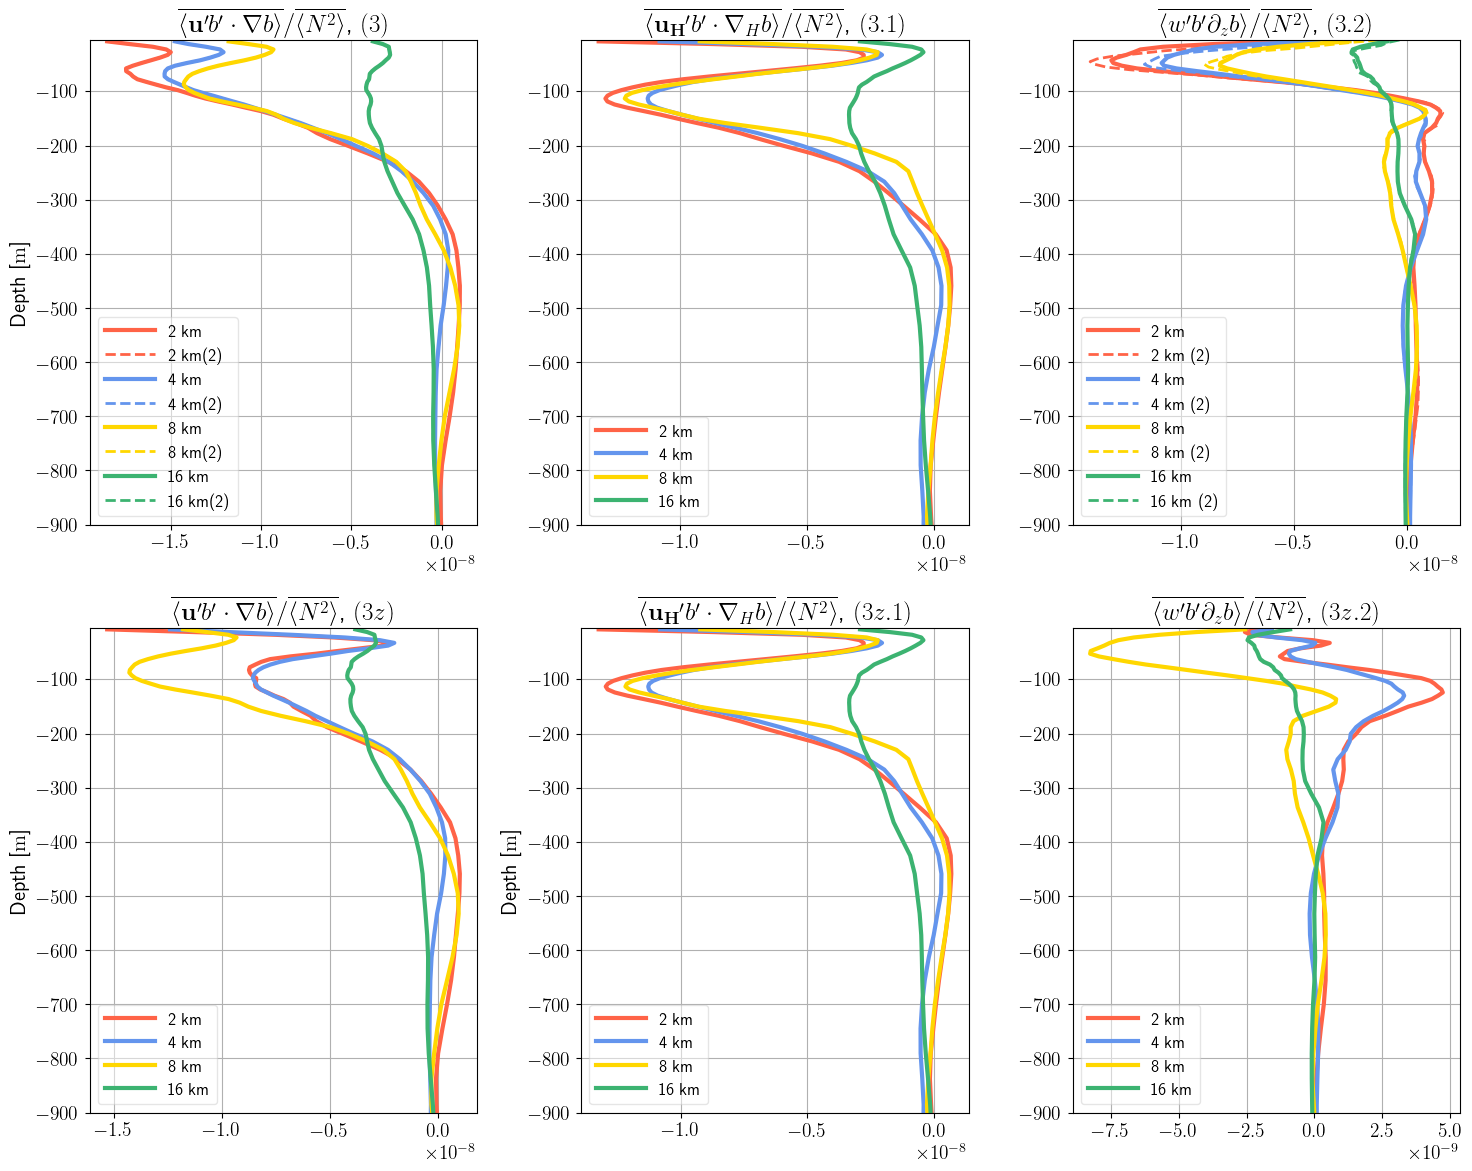

In [40]:
fig = plt.figure(figsize=(15,12), dpi=100, tight_layout=True)
# colours = ['grey', 'darkgreen','royalblue','turquoise','salmon','royalblue', 'red', 'orange']
titles = [r'$\overline{\langle \mathbf{u}^{\prime}b^{\prime} \cdot \nabla b \rangle}/\overline{\langle N^2 \rangle}$, $(3)$', 
          r'$\overline{\langle \mathbf{u}^{\prime}b^{\prime} \cdot \nabla b \rangle}/\overline{\langle N^2 \rangle}$, $(3z)$', 
          r'$\overline{\langle \mathbf{u_{H}}^{\prime}b^{\prime} \cdot \nabla_{H} b \rangle}/\overline{\langle N^2 \rangle}$, $(3.1)$' ,
          r'$\overline{\langle \mathbf{u_{H}}^{\prime}b^{\prime} \cdot \nabla_{H} b \rangle}/\overline{\langle N^2 \rangle}$, $(3z.1)$' ,
          r'$\overline{\langle w^{\prime}b^{\prime} \partial_z b \rangle}/\overline{\langle N^2 \rangle}$, $(3.2)$',
          r'$\overline{\langle w^{\prime}b^{\prime} \partial_z b \rangle}/\overline{\langle N^2 \rangle}$, $(3z.2)$', 
           ]
labels = {'2km': '2 km','4km': '4 km','8km': '8 km','16km': '16 km',}
colours = {'2km': colors[0],'4km': colors[1],'8km': colors[2],'16km': colors[3]}
plt.subplot(231)
for i, r in enumerate(res):
    plt.plot((time_mean_PE_m[r].Upbpgradb/Nsq0[r]).sel(Z=slice(-5,-1000)), time_mean_PE_m[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
    plt.plot((time_mean_PE_m[r].Upbpgradb2/Nsq0[r]).sel(Z=slice(-5,-1000)), time_mean_PE_m[r].sel(Z=slice(-5,-1000)).Z, linewidth=2, linestyle='dashed', color = colours[r],label=labels[r]+ '(2)')
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.title(titles[0], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(234)
for i, r in enumerate(res):
    plt.plot((time_mean_PE[r].Upbpgradb/Nsq0[r]).sel(Z=slice(-5,-1000)), time_mean_PE[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.title(titles[1], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(232)
for i, r in enumerate(res):
    plt.plot((time_mean_PE_m[r].Upbpgradb_h/Nsq0[r]).sel(Z=slice(-5,-1000)), time_mean_PE_m[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[2], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(235)
for i, r in enumerate(res):
    plt.plot((time_mean_PE[r].Upbpgradb_h/Nsq0[r]).sel(Z=slice(-5,-1000)), time_mean_PE[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.title(titles[3], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(233)
for i, r in enumerate(res):
    plt.plot((time_mean_PE_m[r].Upbpgradb_v/Nsq0[r]).sel(Z=slice(-5,-1000)), time_mean_PE_m[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
    plt.plot((time_mean_PE_m[r].wpbpbz/Nsq0[r].values).sel(Zl=slice(-5,-1000)), time_mean_PE_m[r].sel(Zl=slice(-5,-1000)).Zl, linewidth=2, linestyle='dashed', color = colours[r],label=labels[r] + ' (2)')
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[4], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(236)
for i, r in enumerate(res):
    plt.plot((time_mean_PE[r].Upbpgradb_v/Nsq0[r]).sel(Z=slice(-5,-1000)), time_mean_PE[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[5], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

In [48]:
ds_PE_2 = {}
for r in res:
    ds_PE_2[r] = ds_PE[r].copy()
    ds_PE_2[r]['Upbpgradb'] = ds_PEb_m[r]['Upbpgradb']
    ds_PE_2[r]['Upbpgradb_h'] = ds_PEb_m[r]['Upbpgradb_h']
    ds_PE_2[r]['Upbpgradb_v'] = ds_PEb_m[r]['Upbpgradb_v']
    ds_PE_2[r]['LHS'] = (0.5*ds_PE_2[r]['bp2_tend']/Nsq0[r] + 
                           ds_PE_2[r]['wpbp'] + 
                           ds_PE_2[r]['Upbpgradb']/Nsq0[r] +  
                           ds_PE_2[r]['Ugradbp2']/Nsq0[r])
    ds_PE_2[r]['LHS0'] = (0.5*ds_PE_2[r]['bp2_tend']/Nsq0[r] + 
                           ds_PE_2[r]['wpbp'] + 
                           ds_PE_2[r]['Upbpgradb_h']/Nsq0[r] +  
                           ds_PE_2[r]['Ugradbp2']/Nsq0[r])

In [50]:
time_mean_PE_2 = {}
clim_PE_2 = {}
for r in res:
    time_mean_PE_2[r] = ds_PE_2[r].mean(dim='time')
    clim_PE_2[r] = ds_PE_2[r].groupby('time.month').mean(dim='time')
    

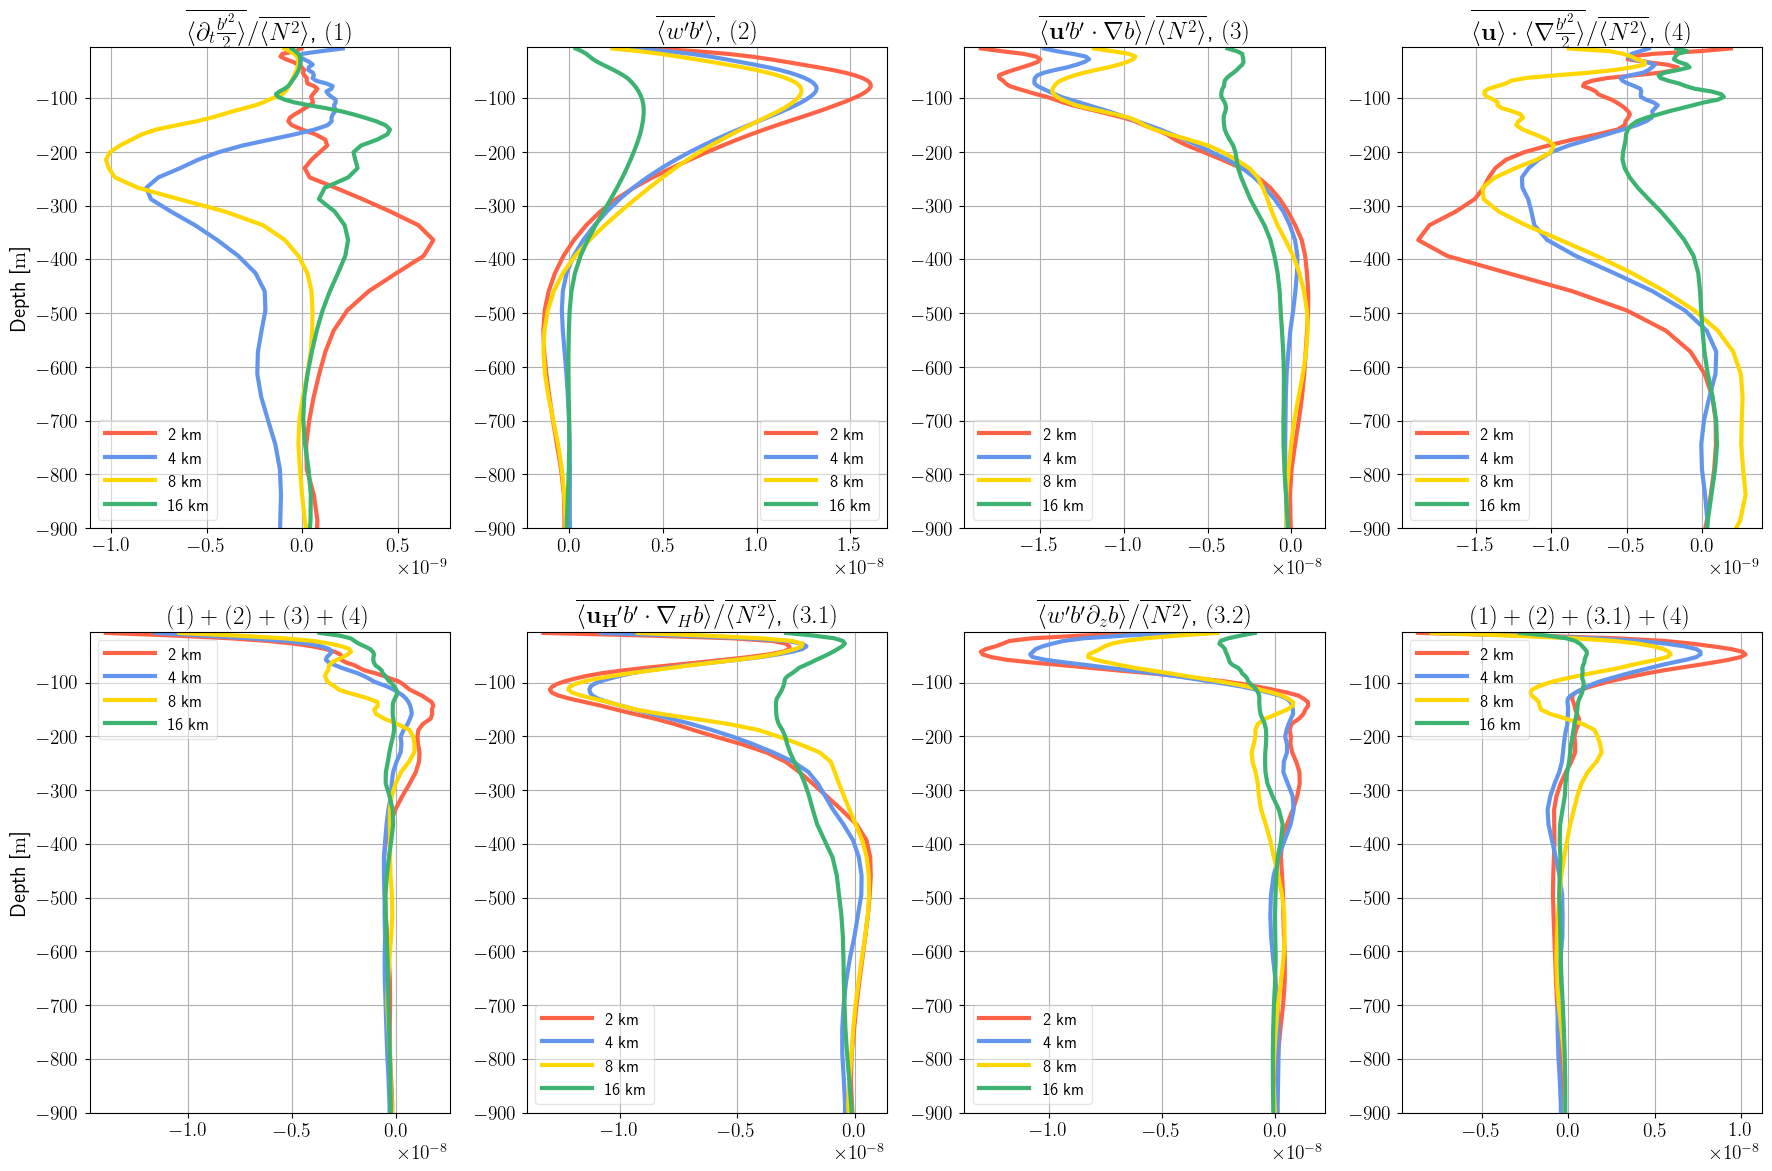

In [51]:
fig = plt.figure(figsize=(18,12), dpi=100, tight_layout=True)
# colours = ['grey', 'darkgreen','royalblue','turquoise','salmon','royalblue', 'red', 'orange']

titles = [r'$\overline{\langle  \partial_t\frac{{b^{\prime}}^{2}}{2} \rangle}/ \overline{\langle N^2 \rangle}$, $(1)$' , 
          r'$\overline{\langle w^{\prime}b^{\prime} \rangle}$, $(2)$', 
          r'$\overline{\langle \mathbf{u}^{\prime}b^{\prime} \cdot \nabla b \rangle}/\overline{\langle N^2 \rangle}$, $(3)$', 
          r'$\overline{\langle \mathbf{u} \rangle \cdot \langle \nabla \frac{{b^{\prime}}^{2}}{2} \rangle}/ \overline{\langle N^2 \rangle}$, $(4)$', 
          r'$(1)+(2)+(3)+(4)$',
          r'$\overline{\langle \mathbf{u_{H}}^{\prime}b^{\prime} \cdot \nabla_{H} b \rangle}/\overline{\langle N^2 \rangle}$, $(3.1)$' ,
          r'$\overline{\langle w^{\prime}b^{\prime} \partial_z b \rangle}/\overline{\langle N^2 \rangle}$, $(3.2)$', 
          r'$(1)+(2)+(3.1)+(4)$',
           ]

labels = {'2km': '2 km','4km': '4 km','8km': '8 km','16km': '16 km',}
colours = {'2km': colors[0],'4km': colors[1],'8km': colors[2],'16km': colors[3]}
plt.subplot(241)
for i, r in enumerate(res):
    plt.plot((time_mean_PE_2[r].bp2_tend/(2*Nsq0[r])).sel(Z=slice(-5,-1000)), time_mean_PE_2[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.title(titles[0], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(242)
for i, r in enumerate(res):
    plt.plot(time_mean_PE_2[r].wpbp.sel(Z=slice(-5,-1000)), time_mean_PE_2[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[1], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(243)
for i, r in enumerate(res):
    plt.plot((time_mean_PE_2[r].Upbpgradb/Nsq0[r]).sel(Z=slice(-5,-1000)), time_mean_PE_2[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[2], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(244)
for i, r in enumerate(res):
    plt.plot((time_mean_PE_2[r].Ugradbp2/Nsq0[r]).sel(Z=slice(-5,-1000)), time_mean_PE_2[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[3], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(245)
for i, r in enumerate(res):
    plt.plot(time_mean_PE_2[r].LHS.sel(Z=slice(-5,-1000)), time_mean_PE_2[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.title(titles[4], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(246)
for i, r in enumerate(res):
    plt.plot((time_mean_PE_2[r].Upbpgradb_h/Nsq0[r]).sel(Z=slice(-5,-1000)), time_mean_PE_2[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[5], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(247)
for i, r in enumerate(res):
    plt.plot((time_mean_PE_2[r].Upbpgradb_v/Nsq0[r]).sel(Z=slice(-5,-1000)), time_mean_PE_2[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[6], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(248)
for i, r in enumerate(res):
    plt.plot(time_mean_PE_2[r].LHS0.sel(Z=slice(-5,-1000)), time_mean_PE_2[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[7], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()



In [73]:
def is_jfm(month):
    return (month >= 1) & (month <= 3)

In [78]:
Nsq0 = {}
Nsqw = {}

for r in res:
    Nsq0[r] = ds_b[r].b_z.mean(dim='time')
    Nsqw[r] = ds_b[r].b_z.sel(time=is_jfm(ds_b[r]['time.month'])).mean(dim='time')



In [79]:
for r in res:

    ds_PE_2[r]['LHS1'] = (0.5*ds_PE_2[r]['bp2_tend']/Nsqw[r] + 
                           ds_PE_2[r]['wpbp'] + 
                           ds_PE_2[r]['Upbpgradb']/Nsqw[r] +  
                           ds_PE_2[r]['Ugradbp2']/Nsqw[r])
    

In [81]:
time_mean_PE_2 = {}
clim_PE_2 = {}
for r in res:
    time_mean_PE_2[r] = ds_PE_2[r].mean(dim='time')
    clim_PE_2[r] = ds_PE_2[r].groupby('time.month').mean(dim='time')
    

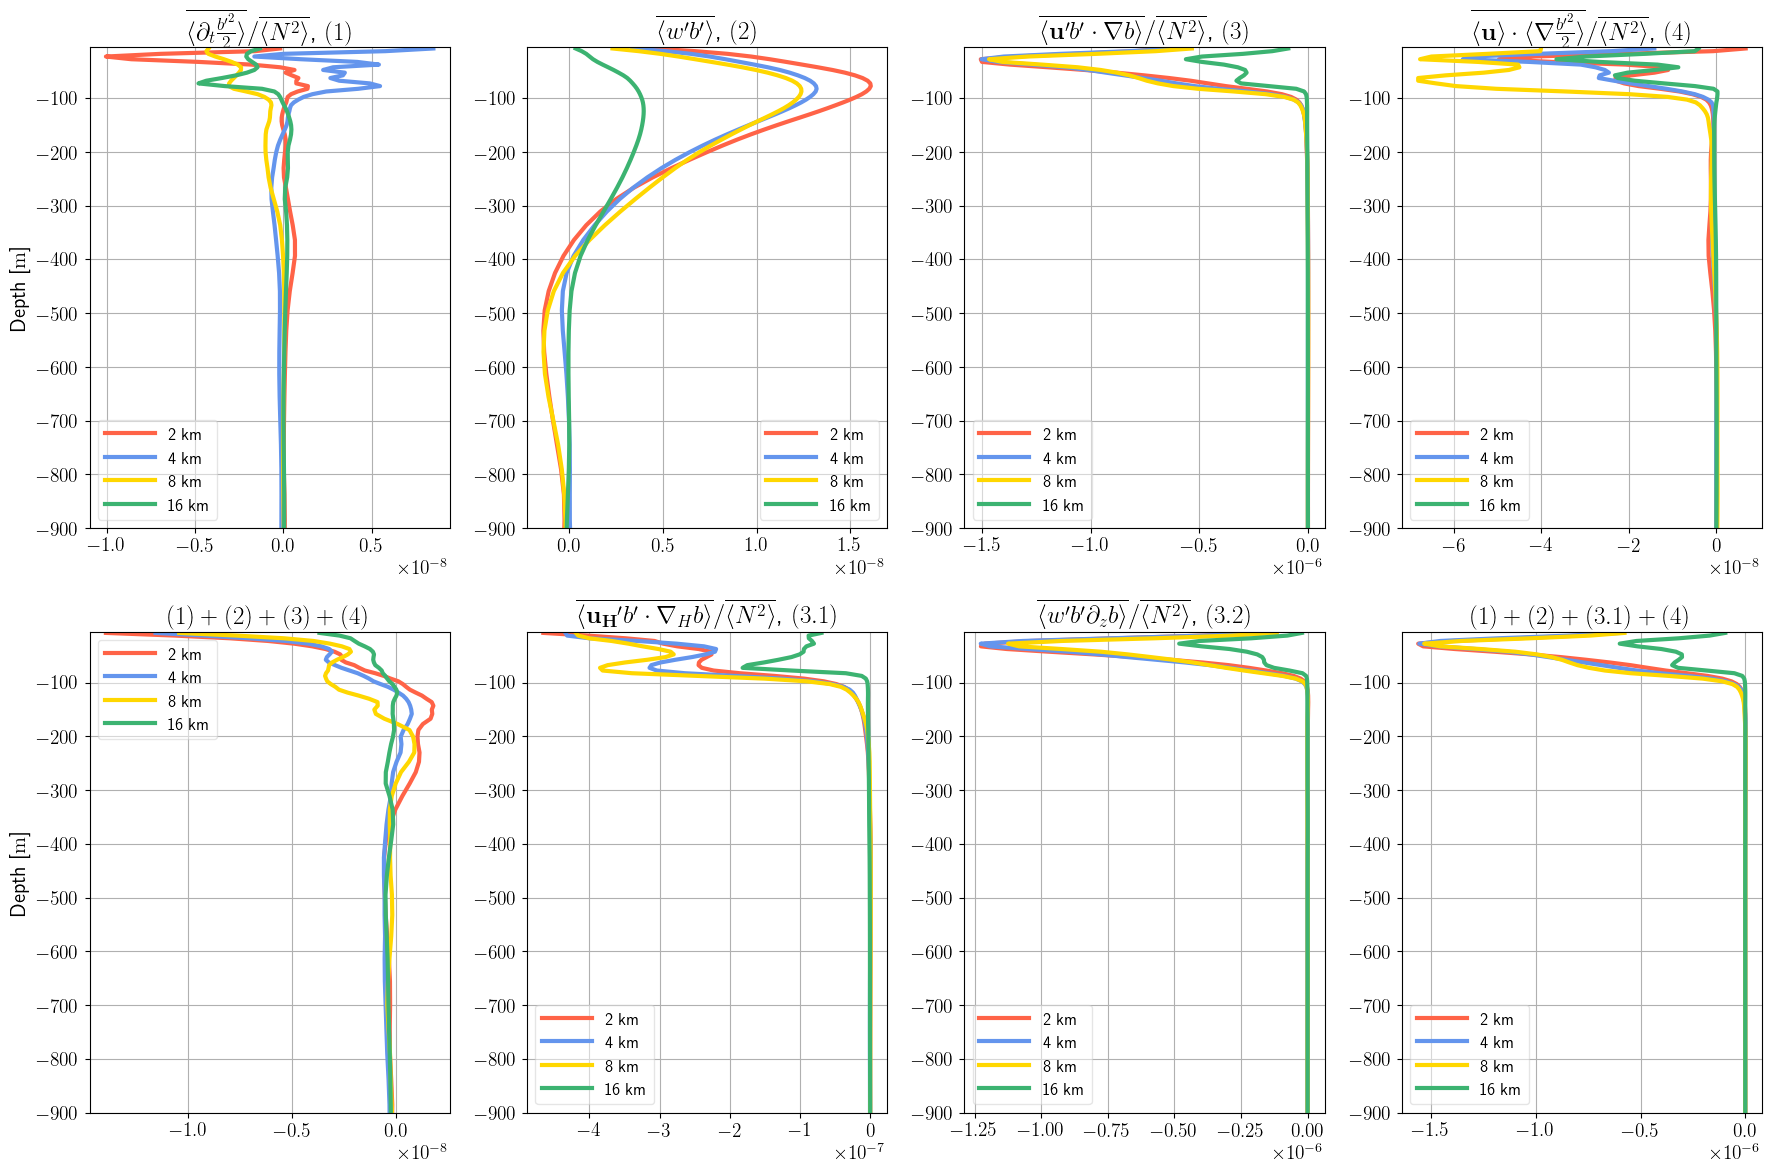

In [82]:
fig = plt.figure(figsize=(18,12), dpi=100, tight_layout=True)
# colours = ['grey', 'darkgreen','royalblue','turquoise','salmon','royalblue', 'red', 'orange']

titles = [r'$\overline{\langle  \partial_t\frac{{b^{\prime}}^{2}}{2} \rangle}/ \overline{\langle N^2 \rangle}$, $(1)$' , 
          r'$\overline{\langle w^{\prime}b^{\prime} \rangle}$, $(2)$', 
          r'$\overline{\langle \mathbf{u}^{\prime}b^{\prime} \cdot \nabla b \rangle}/\overline{\langle N^2 \rangle}$, $(3)$', 
          r'$\overline{\langle \mathbf{u} \rangle \cdot \langle \nabla \frac{{b^{\prime}}^{2}}{2} \rangle}/ \overline{\langle N^2 \rangle}$, $(4)$', 
          r'$(1)+(2)+(3)+(4)$',
          r'$\overline{\langle \mathbf{u_{H}}^{\prime}b^{\prime} \cdot \nabla_{H} b \rangle}/\overline{\langle N^2 \rangle}$, $(3.1)$' ,
          r'$\overline{\langle w^{\prime}b^{\prime} \partial_z b \rangle}/\overline{\langle N^2 \rangle}$, $(3.2)$', 
          r'$(1)+(2)+(3.1)+(4)$',
           ]

labels = {'2km': '2 km','4km': '4 km','8km': '8 km','16km': '16 km',}
colours = {'2km': colors[0],'4km': colors[1],'8km': colors[2],'16km': colors[3]}
plt.subplot(241)
for i, r in enumerate(res):
    plt.plot((time_mean_PE_2[r].bp2_tend/(2*Nsqw[r])).sel(Z=slice(-5,-1000)), time_mean_PE_2[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.title(titles[0], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(242)
for i, r in enumerate(res):
    plt.plot(time_mean_PE_2[r].wpbp.sel(Z=slice(-5,-1000)), time_mean_PE_2[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[1], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(243)
for i, r in enumerate(res):
    plt.plot((time_mean_PE_2[r].Upbpgradb/Nsqw[r]).sel(Z=slice(-5,-1000)), time_mean_PE_2[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[2], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(244)
for i, r in enumerate(res):
    plt.plot((time_mean_PE_2[r].Ugradbp2/Nsqw[r]).sel(Z=slice(-5,-1000)), time_mean_PE_2[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[3], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(245)
for i, r in enumerate(res):
    plt.plot(time_mean_PE_2[r].LHS.sel(Z=slice(-5,-1000)), time_mean_PE_2[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.title(titles[4], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(246)
for i, r in enumerate(res):
    plt.plot((time_mean_PE_2[r].Upbpgradb_h/Nsqw[r]).sel(Z=slice(-5,-1000)), time_mean_PE_2[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[5], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(247)
for i, r in enumerate(res):
    plt.plot((time_mean_PE_2[r].Upbpgradb_v/Nsqw[r]).sel(Z=slice(-5,-1000)), time_mean_PE_2[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[6], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(248)
for i, r in enumerate(res):
    plt.plot(time_mean_PE_2[r].LHS1.sel(Z=slice(-5,-1000)), time_mean_PE_2[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[7], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()



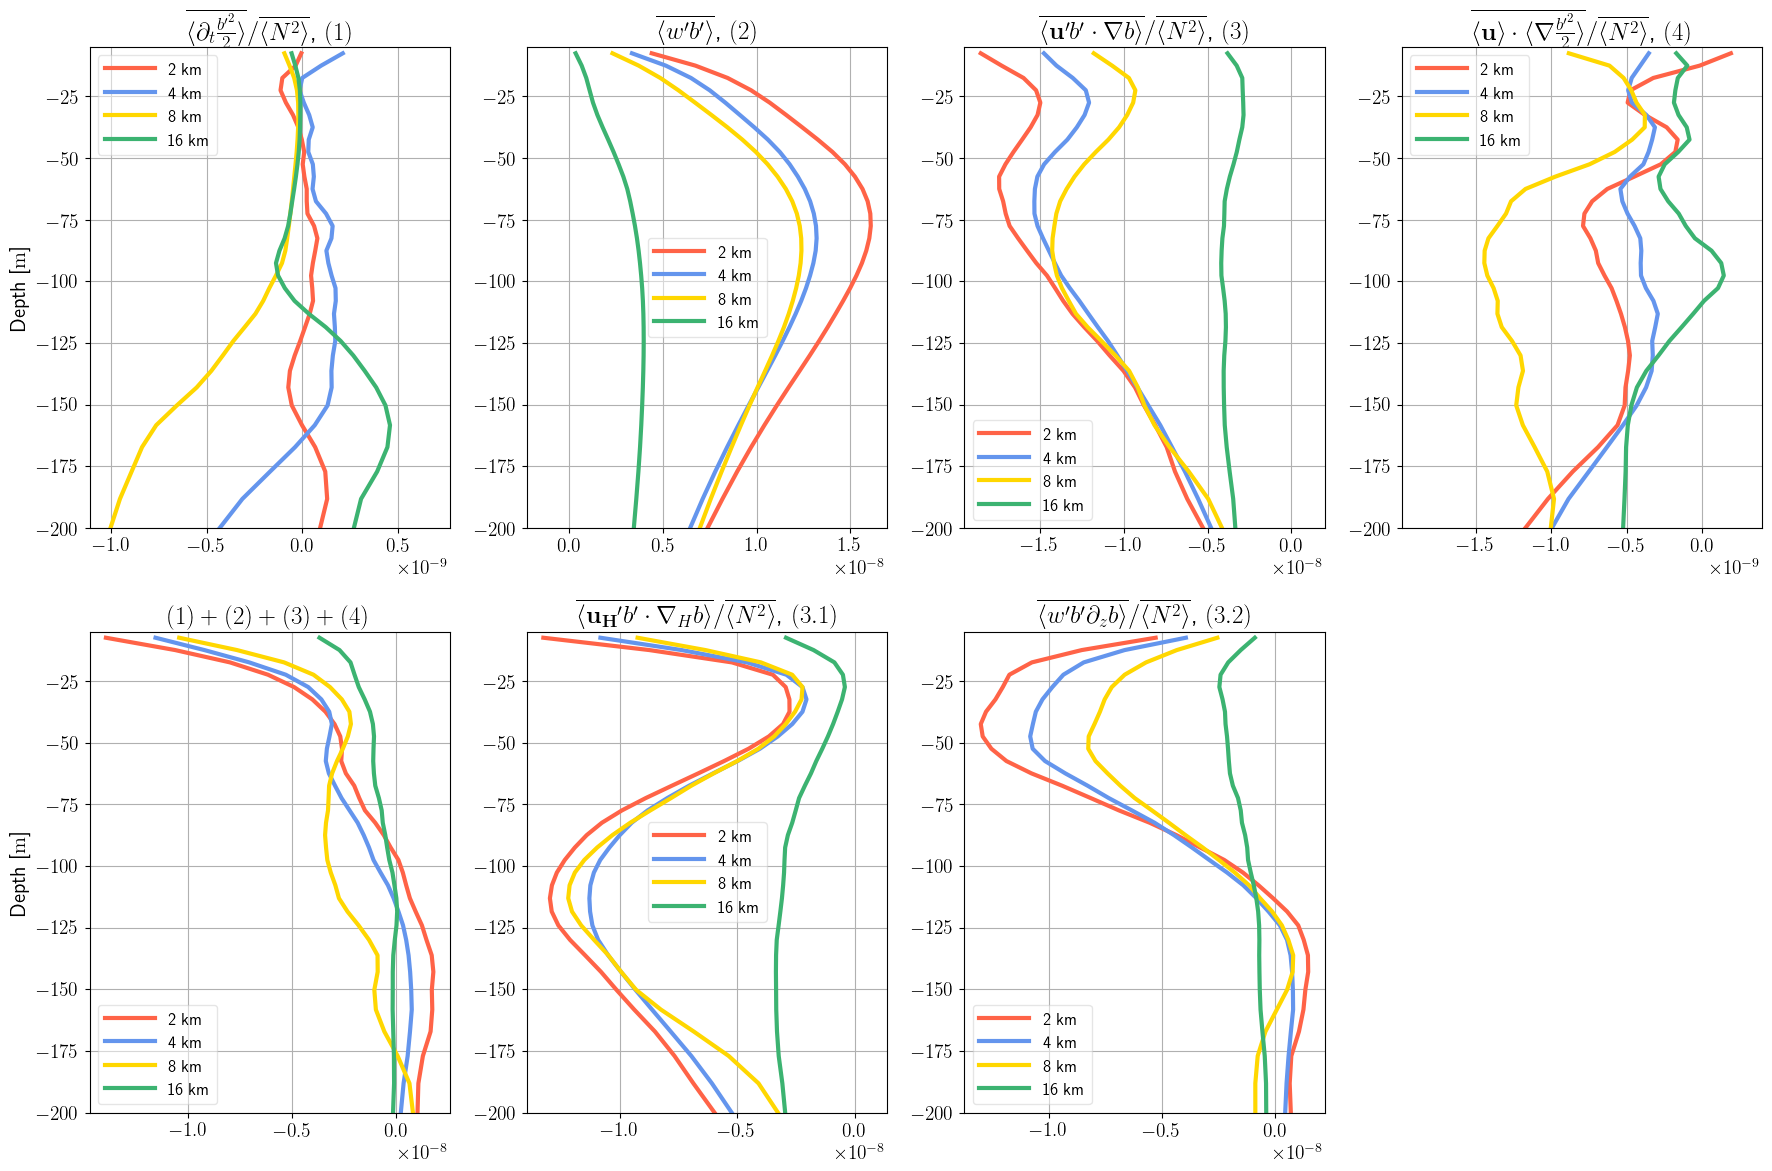

In [60]:
fig = plt.figure(figsize=(18,12), dpi=100, tight_layout=True)
# colours = ['grey', 'darkgreen','royalblue','turquoise','salmon','royalblue', 'red', 'orange']

titles = [r'$\overline{\langle  \partial_t\frac{{b^{\prime}}^{2}}{2} \rangle}/ \overline{\langle N^2 \rangle}$, $(1)$' , 
          r'$\overline{\langle w^{\prime}b^{\prime} \rangle}$, $(2)$', 
          r'$\overline{\langle \mathbf{u}^{\prime}b^{\prime} \cdot \nabla b \rangle}/\overline{\langle N^2 \rangle}$, $(3)$', 
          r'$\overline{\langle \mathbf{u} \rangle \cdot \langle \nabla \frac{{b^{\prime}}^{2}}{2} \rangle}/ \overline{\langle N^2 \rangle}$, $(4)$', 
          r'$(1)+(2)+(3)+(4)$',
          r'$\overline{\langle \mathbf{u_{H}}^{\prime}b^{\prime} \cdot \nabla_{H} b \rangle}/\overline{\langle N^2 \rangle}$, $(3.1)$' ,
          r'$\overline{\langle w^{\prime}b^{\prime} \partial_z b \rangle}/\overline{\langle N^2 \rangle}$, $(3.2)$', 
          r'$(1)+(2)+(3.1)+(4)$',
           ]

labels = {'2km': '2 km','4km': '4 km','8km': '8 km','16km': '16 km',}
colours = {'2km': colors[0],'4km': colors[1],'8km': colors[2],'16km': colors[3]}
plt.subplot(241)
for i, r in enumerate(res):
    plt.plot((time_mean_PE_2[r].bp2_tend/(2*Nsq0[r])).sel(Z=slice(-5,-1000)), time_mean_PE_2[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-200,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.title(titles[0], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(242)
for i, r in enumerate(res):
    plt.plot(time_mean_PE_2[r].wpbp.sel(Z=slice(-5,-1000)), time_mean_PE_2[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-200,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[1], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(243)
for i, r in enumerate(res):
    plt.plot((time_mean_PE_2[r].Upbpgradb/Nsq0[r]).sel(Z=slice(-5,-1000)), time_mean_PE_2[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-200,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[2], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(244)
for i, r in enumerate(res):
    plt.plot((time_mean_PE_2[r].Ugradbp2/Nsq0[r]).sel(Z=slice(-5,-1000)), time_mean_PE_2[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-200,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[3], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(245)
for i, r in enumerate(res):
    plt.plot(time_mean_PE_2[r].LHS.sel(Z=slice(-5,-1000)), time_mean_PE_2[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-200,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.title(titles[4], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(246)
for i, r in enumerate(res):
    plt.plot((time_mean_PE_2[r].Upbpgradb_h/Nsq0[r]).sel(Z=slice(-5,-1000)), time_mean_PE_2[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-200,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[5], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(247)
for i, r in enumerate(res):
    plt.plot((time_mean_PE_2[r].Upbpgradb_v/Nsq0[r]).sel(Z=slice(-5,-1000)), time_mean_PE_2[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-200,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[6], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

# plt.subplot(248)
# for i, r in enumerate(res):
#     plt.plot(time_mean_PE_2[r].LHS0.sel(Z=slice(-5,-1000)), time_mean_PE_2[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
# plt.ylim([-200,-5])
# # plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
# plt.ylabel('')
# plt.title(titles[7], fontsize=18)
# plt.legend(fontsize=12, loc=0, framealpha=0.5)
# plt.grid()



/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/xarray/plot/plot.py:869: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(primitive, **cbar_kwargs)


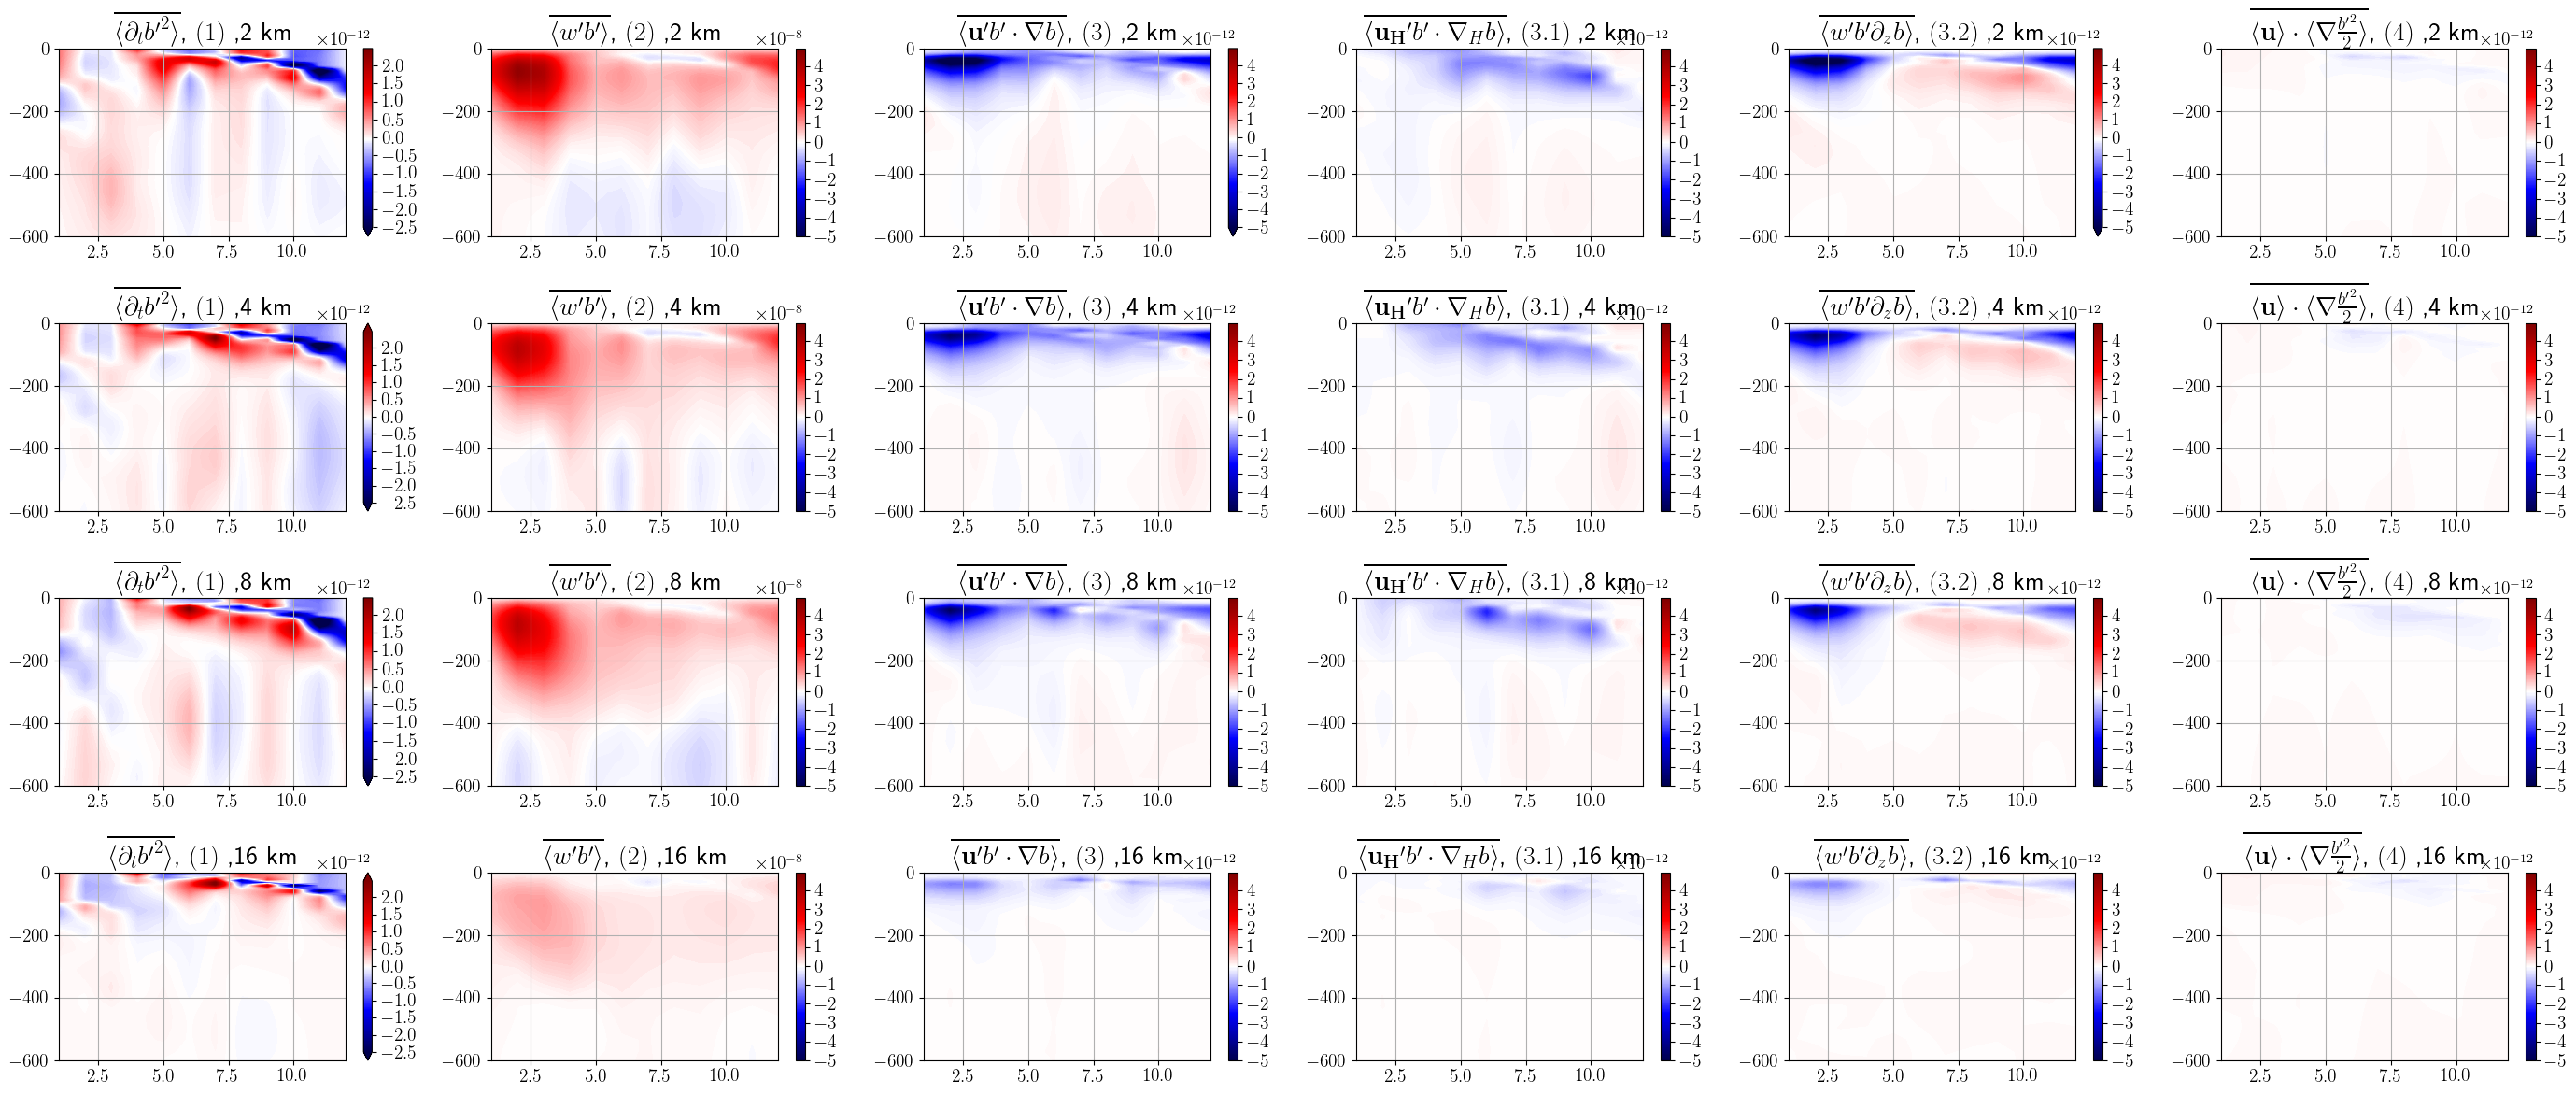

In [63]:
fig = plt.figure(figsize=(28,12), dpi=100, tight_layout=True)
# colours = ['grey', 'darkgreen','royalblue','turquoise','salmon','royalblue', 'red', 'orange']

titles = [r'$\overline{\langle  \partial_t{b^{\prime}}^{2} \rangle}$, $(1)$' , 
          r'$\overline{\langle w^{\prime}b^{\prime} \rangle}$, $(2)$', 
          r'$\overline{\langle \mathbf{u}^{\prime}b^{\prime} \cdot \nabla b \rangle}$, $(3)$', 
          r'$\overline{\langle \mathbf{u_{H}}^{\prime}b^{\prime} \cdot \nabla_{H} b \rangle}$, $(3.1)$' ,
          r'$\overline{\langle w^{\prime}b^{\prime} \partial_z b \rangle}$, $(3.2)$', 
          r'$\overline{\langle \mathbf{u} \rangle \cdot \langle \nabla \frac{{b^{\prime}}^{2}}{2} \rangle}$, $(4)$', 
           ]
variables = ['bp2_tend', 
             'wpbp', 
             'Upbpgradb', 
             'Upbpgradb_h', 
             'Upbpgradb_v', 
             'Ugradbp2', 
            ]
levels_c = [np.arange(-2.5e-12,2.5e-12,2.5e-14), 
            np.arange(-5e-8,5e-8,5e-10), 
            np.arange(-5e-12,5e-12,5e-14), 
            np.arange(-5e-12,5e-12,5e-14), 
            np.arange(-5e-12,5e-12,5e-14), 
            np.arange(-5e-12,5e-12,5e-14), 
           ]
labels = {'2km': '2 km','4km': '4 km','8km': '8 km','16km': '16 km',}
for j, v in enumerate(variables):
    for i, r in enumerate(res):
        plt.subplot2grid((4,6),(i,j))
        clim_PE_2[r][v].T.plot.contourf(levels=levels_c[j], cmap='seismic', add_labels=False)
        plt.ylim([-600,0])
        plt.ylabel('')
        plt.grid()
        plt.title(titles[j]+' ,'+labels[r])


In [70]:
ds_ts = {}
mxld = {}
for r in res:
    ds_ts[r] = xr.open_dataset(dirroot_s+'timeseries/%s_timeseries.nc' %r)
    mxld[r] = ds_ts[r].mxld


In [71]:
mxld_clim = {}
for r in res:
    mxld_clim[r] = mxld[r].groupby('time.month').mean(dim='time')

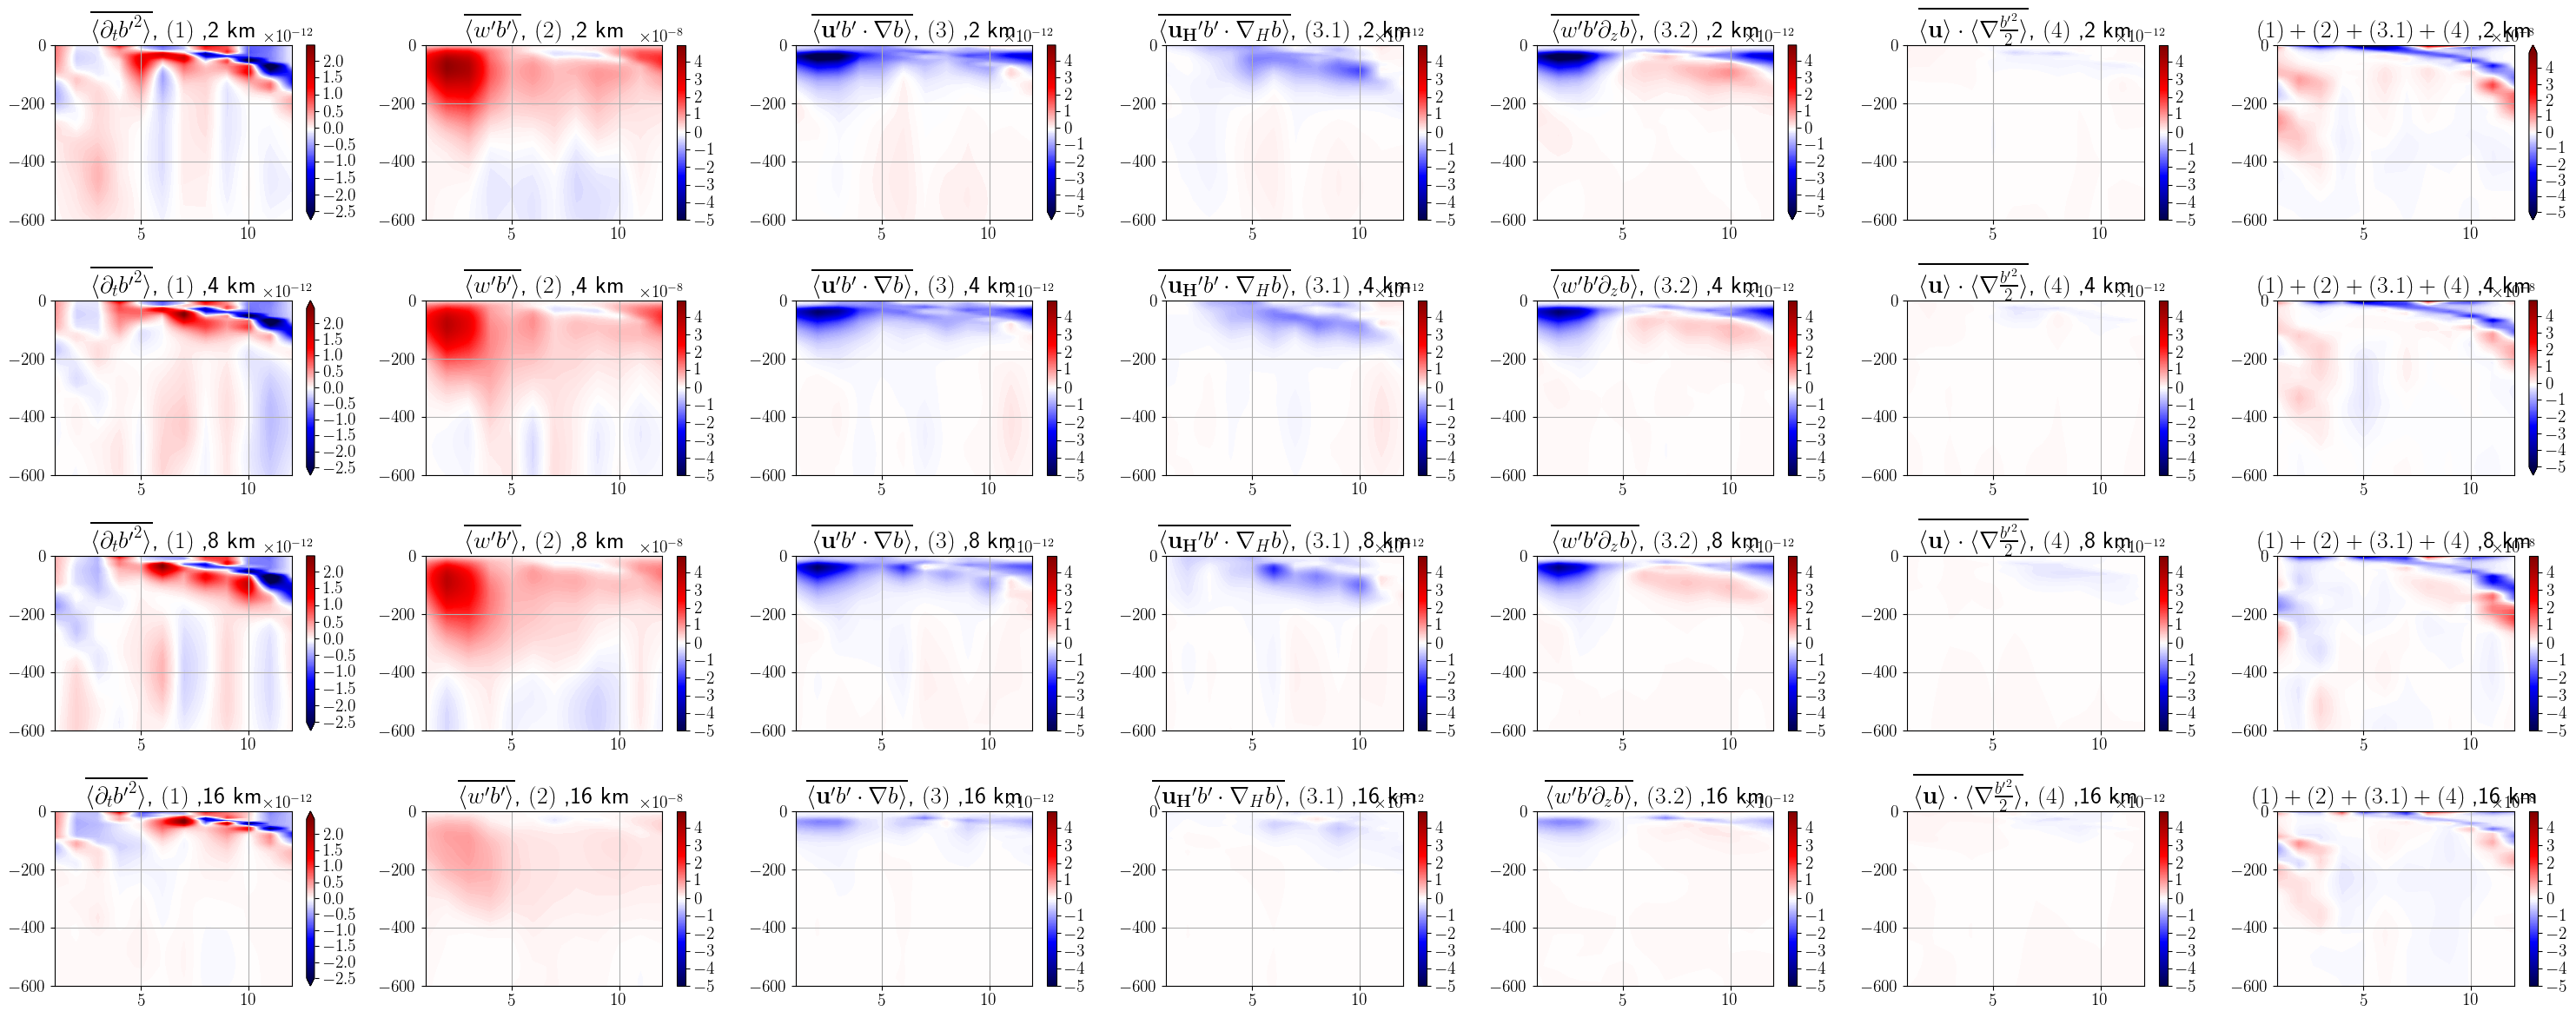

In [64]:
fig = plt.figure(figsize=(30,12), dpi=100, tight_layout=True)
# colours = ['grey', 'darkgreen','royalblue','turquoise','salmon','royalblue', 'red', 'orange']

titles = [r'$\overline{\langle  \partial_t{b^{\prime}}^{2} \rangle}$, $(1)$' , 
          r'$\overline{\langle w^{\prime}b^{\prime} \rangle}$, $(2)$', 
          r'$\overline{\langle \mathbf{u}^{\prime}b^{\prime} \cdot \nabla b \rangle}$, $(3)$', 
          r'$\overline{\langle \mathbf{u_{H}}^{\prime}b^{\prime} \cdot \nabla_{H} b \rangle}$, $(3.1)$' ,
          r'$\overline{\langle w^{\prime}b^{\prime} \partial_z b \rangle}$, $(3.2)$', 
          r'$\overline{\langle \mathbf{u} \rangle \cdot \langle \nabla \frac{{b^{\prime}}^{2}}{2} \rangle}$, $(4)$', 
          r'$(1)+(2)+(3.1)+(4)$',
           ]
variables = ['bp2_tend', 
             'wpbp', 
             'Upbpgradb', 
             'Upbpgradb_h', 
             'Upbpgradb_v', 
             'Ugradbp2', 
             'LHS'
            ]
levels_c = [np.arange(-2.5e-12,2.5e-12,2.5e-14), 
            np.arange(-5e-8,5e-8,5e-10), 
            np.arange(-5e-12,5e-12,5e-14), 
            np.arange(-5e-12,5e-12,5e-14), 
            np.arange(-5e-12,5e-12,5e-14), 
            np.arange(-5e-12,5e-12,5e-14), 
            np.arange(-5e-8,5e-8,5e-10), 
           ]
labels = {'2km': '2 km','4km': '4 km','8km': '8 km','16km': '16 km',}
for j, v in enumerate(variables):
    for i, r in enumerate(res):
        plt.subplot2grid((4,7),(i,j))
        clim_PE_2[r][v].T.plot.contourf(levels=levels_c[j], cmap='seismic', add_labels=False)
        plt.ylim([-600,0])
        plt.ylabel('')
        plt.grid()
        plt.title(titles[j]+' ,'+labels[r])


/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/xarray/plot/plot.py:869: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(primitive, **cbar_kwargs)
/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/xarray/plot/plot.py:869: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(primitive, **cbar_kwargs)
/central/groups/oceanphysics/anirban/miniconda/envs/mypythonenv1/lib/python3.6/site-packages/xarray/plot/plot.py:869: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be re

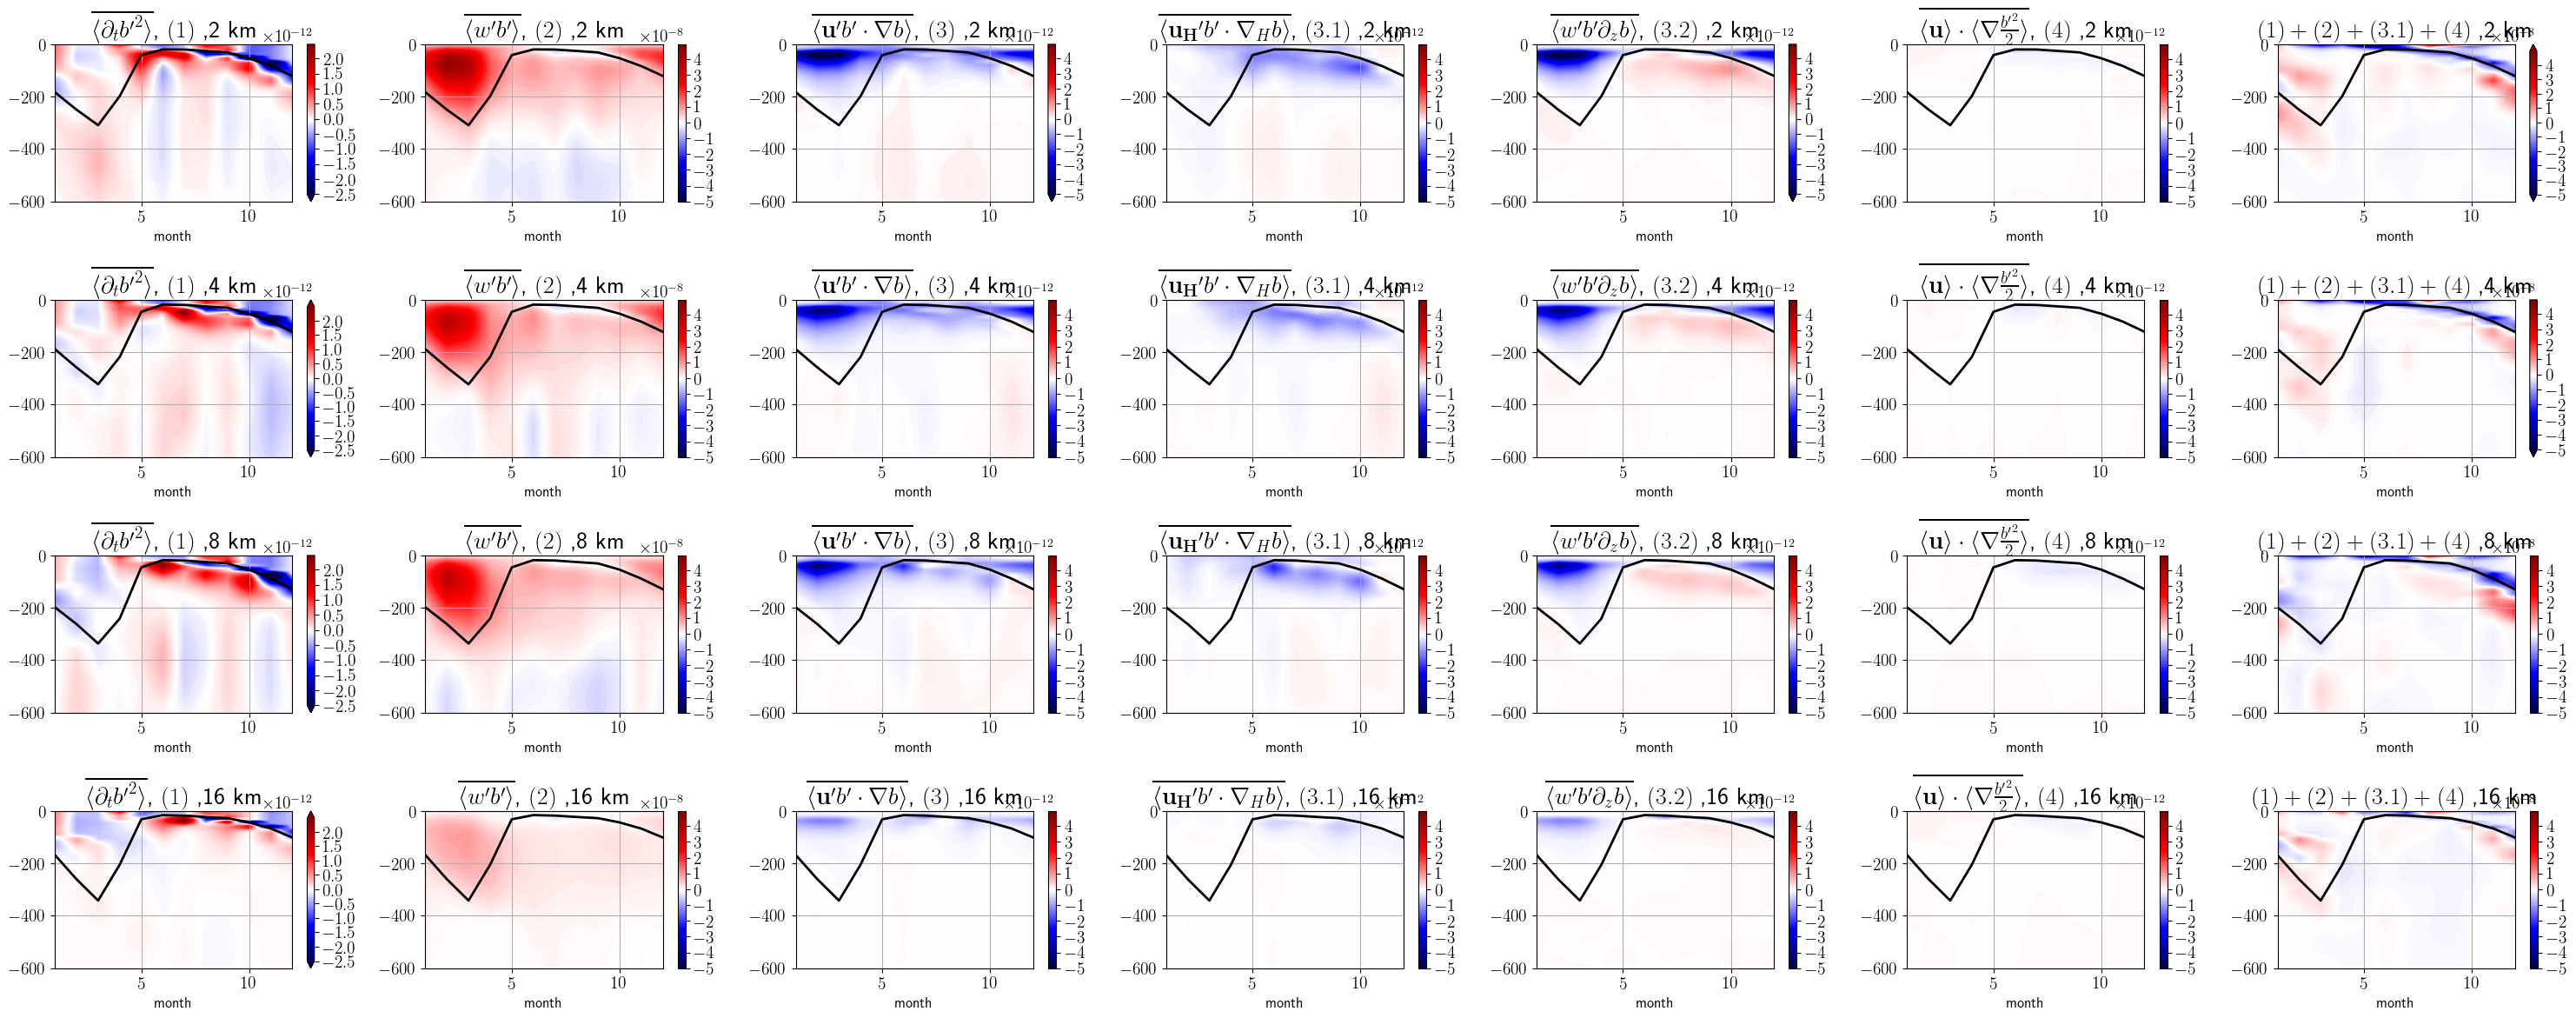

In [72]:
fig = plt.figure(figsize=(30,12), dpi=100, tight_layout=True)
# colours = ['grey', 'darkgreen','royalblue','turquoise','salmon','royalblue', 'red', 'orange']

titles = [r'$\overline{\langle  \partial_t{b^{\prime}}^{2} \rangle}$, $(1)$' , 
          r'$\overline{\langle w^{\prime}b^{\prime} \rangle}$, $(2)$', 
          r'$\overline{\langle \mathbf{u}^{\prime}b^{\prime} \cdot \nabla b \rangle}$, $(3)$', 
          r'$\overline{\langle \mathbf{u_{H}}^{\prime}b^{\prime} \cdot \nabla_{H} b \rangle}$, $(3.1)$' ,
          r'$\overline{\langle w^{\prime}b^{\prime} \partial_z b \rangle}$, $(3.2)$', 
          r'$\overline{\langle \mathbf{u} \rangle \cdot \langle \nabla \frac{{b^{\prime}}^{2}}{2} \rangle}$, $(4)$', 
          r'$(1)+(2)+(3.1)+(4)$',
           ]
variables = ['bp2_tend', 
             'wpbp', 
             'Upbpgradb', 
             'Upbpgradb_h', 
             'Upbpgradb_v', 
             'Ugradbp2', 
             'LHS'
            ]
levels_c = [np.arange(-2.5e-12,2.5e-12,2.5e-14), 
            np.arange(-5e-8,5e-8,5e-10), 
            np.arange(-5e-12,5e-12,5e-14), 
            np.arange(-5e-12,5e-12,5e-14), 
            np.arange(-5e-12,5e-12,5e-14), 
            np.arange(-5e-12,5e-12,5e-14), 
            np.arange(-5e-8,5e-8,5e-10), 
           ]
labels = {'2km': '2 km','4km': '4 km','8km': '8 km','16km': '16 km',}
for j, v in enumerate(variables):
    for i, r in enumerate(res):
        plt.subplot2grid((4,7),(i,j))
        clim_PE_2[r][v].T.plot.contourf(levels=levels_c[j], cmap='seismic', add_labels=False)
        (-mxld_clim[r]).plot(linewidth=2, color='k')
        plt.ylim([-600,0])
        plt.ylabel('')
        plt.grid()
        plt.title(titles[j]+' ,'+labels[r])


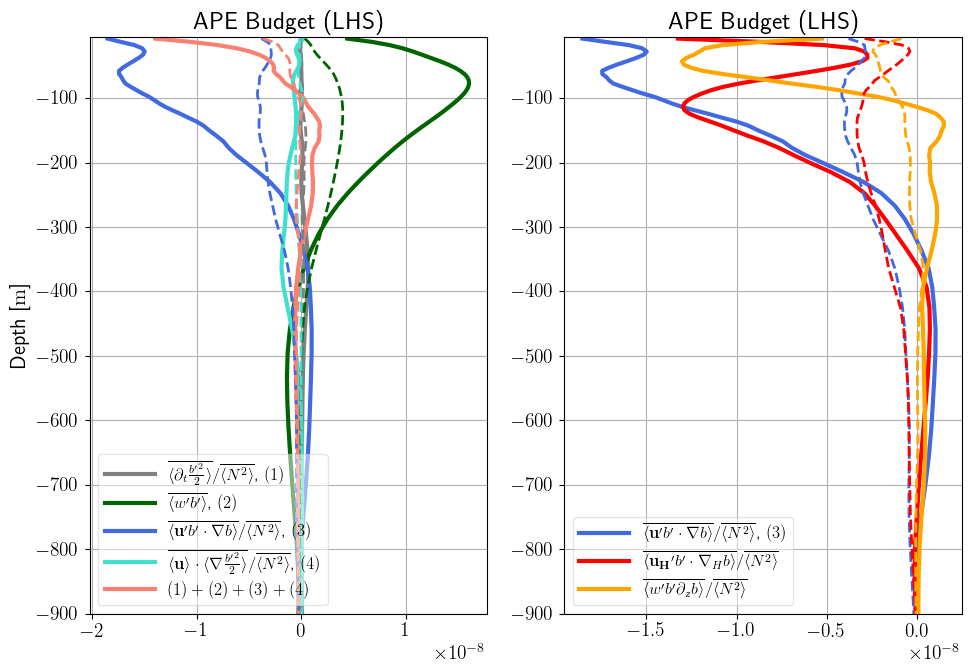

In [52]:
fig = plt.figure(figsize=(10,7), dpi=100, tight_layout=True)
colours = ['grey', 'darkgreen','royalblue','turquoise','salmon','royalblue', 'red', 'orange']

labells = [r'$\overline{\langle  \partial_t\frac{{b^{\prime}}^{2}}{2} \rangle}/ \overline{\langle N^2 \rangle}$, $(1)$' , 
           r'$\overline{\langle w^{\prime}b^{\prime} \rangle}$, $(2)$', 
           r'$\overline{\langle \mathbf{u}^{\prime}b^{\prime} \cdot \nabla b \rangle}/\overline{\langle N^2 \rangle}$, $(3)$', 
           r'$\overline{\langle \mathbf{u} \rangle \cdot \langle \nabla \frac{{b^{\prime}}^{2}}{2} \rangle}/ \overline{\langle N^2 \rangle}$, $(4)$', 
           r'$(1)+ (2)+(3)+(4)$',
           r'$\overline{\langle \mathbf{u}^{\prime}b^{\prime} \cdot \nabla b \rangle}/\overline{\langle N^2 \rangle}$, $(3)$', 
           r'$\overline{\langle \mathbf{u_{H}}^{\prime}b^{\prime} \cdot \nabla_{H} b \rangle}/\overline{\langle N^2 \rangle}$', 
           r'$\overline{\langle w^{\prime}b^{\prime} \partial_z b \rangle}/\overline{\langle N^2 \rangle}$', 
           ]
plt.subplot(121)
plt.plot((time_mean_PE_2['2km'].bp2_tend/(2*Nsq0['2km'])).sel(Z=slice(-5,-1000)), time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[0],label=labells[0])
plt.plot(time_mean_PE_2['2km'].wpbp.sel(Z=slice(-5,-1000)), time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[1],label=labells[1])
plt.plot((time_mean_PE_2['2km'].Upbpgradb/Nsq0['2km']).sel(Z=slice(-5,-1000)), time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[2],label=labells[2])
plt.plot((time_mean_PE_2['2km'].Ugradbp2/Nsq0['2km']).sel(Z=slice(-5,-1000)), time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[3],label=labells[3])
plt.plot(time_mean_PE_2['2km'].LHS.sel(Z=slice(-5,-1000)), time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[4],label=labells[4])

plt.plot((time_mean_PE['16km'].bp2_tend/(2*Nsq0['16km'])).sel(Z=slice(-5,-1000)), time_mean_PE['16km'].sel(Z=slice(-5,-1000)).Z, linewidth=2,linestyle='dashed', color = colours[0])
plt.plot(time_mean_PE['16km'].wpbp.sel(Z=slice(-5,-1000)), time_mean_PE['16km'].sel(Z=slice(-5,-1000)).Z, linewidth=2,linestyle='dashed', color = colours[1])
plt.plot((time_mean_PE['16km'].Upbpgradb/Nsq0['16km']).sel(Z=slice(-5,-1000)), time_mean_PE['16km'].sel(Z=slice(-5,-1000)).Z, linewidth=2,linestyle='dashed', color = colours[2])
plt.plot((time_mean_PE['16km'].Ugradbp2/Nsq0['16km']).sel(Z=slice(-5,-1000)), time_mean_PE['2km'].sel(Z=slice(-5,-1000)).Z, linewidth=2,linestyle='dashed', color = colours[3])
plt.plot(time_mean_PE['16km'].LHS.sel(Z=slice(-5,-1000)), time_mean_PE['16km'].sel(Z=slice(-5,-1000)).Z, linewidth=2,linestyle='dashed', color = colours[4])

plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.title(r'APE Budget (LHS)', fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(122)
plt.plot((time_mean_PE_2['2km'].Upbpgradb/Nsq0['2km']).sel(Z=slice(-5,-1000)), time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[2],label=labells[2])
plt.plot((time_mean_PE_2['2km'].Upbpgradb_h/Nsq0['2km']).sel(Z=slice(-5,-1000)), time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[6],label=labells[6])
plt.plot((time_mean_PE_2['2km'].Upbpgradb_v/Nsq0['2km']).sel(Z=slice(-5,-1000)), time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[7],label=labells[7])

plt.plot((time_mean_PE['16km'].Upbpgradb/Nsq0['16km']).sel(Z=slice(-5,-1000)), time_mean_PE['16km'].sel(Z=slice(-5,-1000)).Z, linewidth=2,linestyle='dashed', color = colours[2],)
plt.plot((time_mean_PE['16km'].Upbpgradb_h/Nsq0['16km']).sel(Z=slice(-5,-1000)), time_mean_PE['16km'].sel(Z=slice(-5,-1000)).Z, linewidth=2,linestyle='dashed', color = colours[6])
plt.plot((time_mean_PE['16km'].Upbpgradb_v/Nsq0['16km']).sel(Z=slice(-5,-1000)), time_mean_PE['16km'].sel(Z=slice(-5,-1000)).Z, linewidth=2,linestyle='dashed', color = colours[7])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('', fontsize=15)
plt.title(r'APE Budget (LHS)', fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()


In [53]:

for r in ['2km', '16km']:

    ds_PE_2[r]['RHS0'] = (ds_PE_2[r]['bpQ1p']/Nsq0[r] + 
                           ds_PE_2[r]['bpQ2p']/Nsq0[r] +  
                           ds_PE_2[r]['bpQ3p']/Nsq0[r] + 
                           ds_PE_2[r]['bpQ4p']/Nsq0[r] + 
                           ds_PE_2[r]['bpQ5p']/Nsq0[r])
    ds_PE_2[r]['RHS1'] = (ds_PE_2[r]['bpQ1p']/Nsq0[r] + 
                           ds_PE_2[r]['bpQ2p']/Nsq0[r] +  
                           ds_PE_2[r]['bpQ3p']/Nsq0[r] + 
                           ds_PE_2[r]['bpQ4p']/Nsq0[r])

    time_mean_PE_2[r] = ds_PE_2[r].mean(dim='time')
    clim_PE_2[r] = ds_PE_2[r].groupby('time.month').mean(dim='time')
    

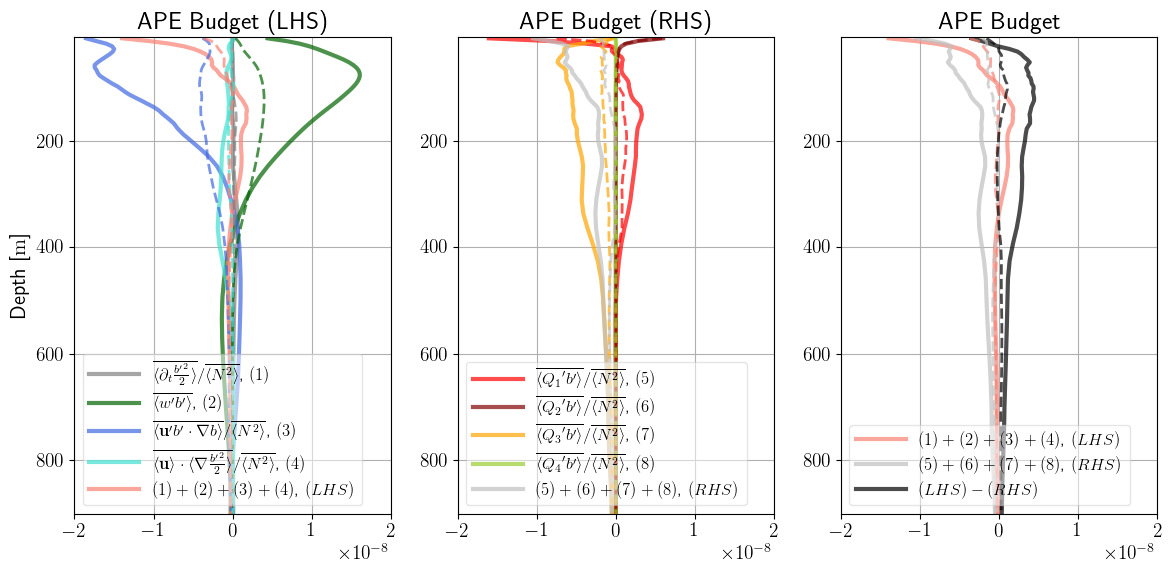

In [56]:
fig = plt.figure(figsize=(12,6), dpi=100, tight_layout=True)
colours = ['grey', 'darkgreen','royalblue','turquoise','salmon','red','maroon', 'orange', 'yellowgreen', 'silver', 'black']

labells = [r'$\overline{\langle  \partial_t\frac{{b^{\prime}}^{2}}{2} \rangle}/ \overline{\langle N^2 \rangle}$, $(1)$' ,
           r'$\overline{\langle w^{\prime}b^{\prime} \rangle}$, $(2)$',
           r'$\overline{\langle \mathbf{u}^{\prime}b^{\prime} \cdot \nabla b \rangle}/\overline{\langle N^2 \rangle}$, $(3)$',
           r'$\overline{\langle \mathbf{u} \rangle \cdot \langle \nabla \frac{{b^{\prime}}^{2}}{2} \rangle}/ \overline{\langle N^2 \rangle}$, $(4)$',
           r'$(1)+ (2)+(3)+(4)$, $(LHS)$ ',
           r'$\overline{\langle {Q_1}^{\prime}b^{\prime} \rangle}/ \overline{\langle N^2 \rangle}$, $(5)$',
           r'$\overline{\langle {Q_2}^{\prime}b^{\prime} \rangle}/ \overline{\langle N^2 \rangle}$, $(6)$',
           r'$\overline{\langle {Q_3}^{\prime}b^{\prime} \rangle}/ \overline{\langle N^2 \rangle}$, $(7)$',
           r'$\overline{\langle {Q_4}^{\prime}b^{\prime} \rangle}/ \overline{\langle N^2 \rangle}$, $(8)$',
           r'$(5)+(6)+(7)+(8)$, $(RHS)$',
           r'$(LHS)-(RHS)$',]

plt.subplot(131)
plt.plot((time_mean_PE_2['2km'].bp2_tend/(2*Nsq0['2km'])).sel(Z=slice(-5,-1000)),
         time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=3, color = colours[0],label=labells[0], alpha=0.7)
plt.plot(time_mean_PE_2['2km'].wpbp.sel(Z=slice(-5,-1000)),
         time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=3, color = colours[1],label=labells[1], alpha=0.7)
plt.plot((time_mean_PE_2['2km'].Upbpgradb/Nsq0['2km']).sel(Z=slice(-5,-1000)),
         time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=3, color = colours[2],label=labells[2], alpha=0.7)
plt.plot((time_mean_PE_2['2km'].Ugradbp2/Nsq0['2km']).sel(Z=slice(-5,-1000)),
         time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=3, color = colours[3],label=labells[3], alpha=0.7)
plt.plot(time_mean_PE_2['2km'].LHS.sel(Z=slice(-5,-1000)),
         time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=3, color = colours[4],label=labells[4], alpha=0.7)

plt.plot((time_mean_PE_2['16km'].bp2_tend/(2*Nsq0['16km'])).sel(Z=slice(-5,-1000)),
         time_mean_PE_2['16km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=2, color = colours[0],linestyle='dashed', alpha=0.7)
plt.plot(time_mean_PE_2['16km'].wpbp.sel(Z=slice(-5,-1000)),
         time_mean_PE_2['16km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=2, color = colours[1],linestyle='dashed', alpha=0.7)
plt.plot((time_mean_PE_2['16km'].Upbpgradb/Nsq0['16km']).sel(Z=slice(-5,-1000)),
         time_mean_PE_2['16km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=2, color = colours[2],linestyle='dashed', alpha=0.7)
plt.plot((time_mean_PE_2['16km'].Ugradbp2/Nsq0['16km']).sel(Z=slice(-5,-1000)),
         time_mean_PE_2['16km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=2, color = colours[3],linestyle='dashed', alpha=0.7)
plt.plot(time_mean_PE_2['16km'].LHS.sel(Z=slice(-5,-1000)),
         time_mean_PE_2['16km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=2, color = colours[4],linestyle='dashed', alpha=0.7)

plt.ylim([-900,-5])
plt.xlim([-2e-8,2e-8])
plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.title(r'APE Budget (LHS)', fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(132)
plt.plot(((time_mean_PE_2['2km'].bpQ1p )/Nsq0['2km']).sel(Z=slice(-5,-1000)),
         time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=3, color = colours[5],label=labells[5], alpha=0.7)
plt.plot(((time_mean_PE_2['2km'].bpQ2p )/Nsq0['2km']).sel(Z=slice(-5,-1000)),
         time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=3, color = colours[6],label=labells[6], alpha=0.7)
plt.plot(((time_mean_PE_2['2km'].bpQ3p)/Nsq0['2km']).sel(Z=slice(-5,-1000)),
         time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=3, color = colours[7],label=labells[7], alpha=0.7)
plt.plot(((time_mean_PE_2['2km'].bpQ4p )/Nsq0['2km']).sel(Z=slice(-5,-1000)),
         time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=3, color = colours[8],label=labells[8], alpha=0.7)
plt.plot(time_mean_PE_2['2km'].RHS1.sel(Z=slice(-5,-1000)) ,
         time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=3, color = colours[9],label=labells[9], alpha=0.7)

plt.plot(((time_mean_PE_2['16km'].bpQ1p )/Nsq0['16km']).sel(Z=slice(-5,-1000)),
         time_mean_PE_2['16km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=2, color = colours[5],linestyle='dashed', alpha=0.7)
plt.plot(((time_mean_PE_2['16km'].bpQ2p )/Nsq0['16km']).sel(Z=slice(-5,-1000)),
         time_mean_PE_2['16km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=2, color = colours[6],linestyle='dashed', alpha=0.7)
plt.plot(((time_mean_PE_2['16km'].bpQ3p)/Nsq0['16km']).sel(Z=slice(-5,-1000)),
         time_mean_PE_2['16km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=2, color = colours[7],linestyle='dashed', alpha=0.7)
plt.plot(((time_mean_PE_2['16km'].bpQ4p )/Nsq0['16km']).sel(Z=slice(-5,-1000)),
         time_mean_PE_2['16km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=2, color = colours[8],linestyle='dashed', alpha=0.7)
plt.plot(time_mean_PE_2['16km'].RHS1.sel(Z=slice(-5,-1000)) ,
         time_mean_PE_2['16km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=2, color = colours[9],linestyle='dashed', alpha=0.7)

plt.ylim([-900,-5])
plt.xlim([-2e-8,2e-8])
plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(r'APE Budget (RHS)', fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()


plt.subplot(133)
plt.plot(time_mean_PE_2['2km'].LHS.sel(Z=slice(-5,-1000)),
         time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=3, color = colours[4],label=labells[4], alpha=0.7)
plt.plot(time_mean_PE_2['2km'].RHS1.sel(Z=slice(-5,-1000)) ,
         time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=3, color = colours[9], label = labells[9], alpha=0.7)
plt.plot((time_mean_PE_2['2km'].LHS - time_mean_PE_2['2km'].RHS1).sel(Z=slice(-5,-1000)),
         time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z ,
         linewidth=3, color = colours[10], label = labells[10], alpha=0.7)

plt.plot(time_mean_PE_2['16km'].LHS.sel(Z=slice(-5,-1000)),
         time_mean_PE_2['16km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=2, color = colours[4],linestyle='dashed', alpha=0.7)
plt.plot(time_mean_PE_2['16km'].RHS1.sel(Z=slice(-5,-1000)) ,
         time_mean_PE_2['16km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=2, color = colours[9],linestyle='dashed', alpha=0.7)
plt.plot((time_mean_PE_2['16km'].LHS - time_mean_PE_2['16km'].RHS1).sel(Z=slice(-5,-1000)),
         time_mean_PE_2['16km'].sel(Z=slice(-5,-1000)).Z ,
         linewidth=2, color = colours[10],linestyle='dashed', alpha=0.7)

plt.ylim([-900,-5])
plt.xlim([-2e-8,2e-8])
plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(r'APE Budget', fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()


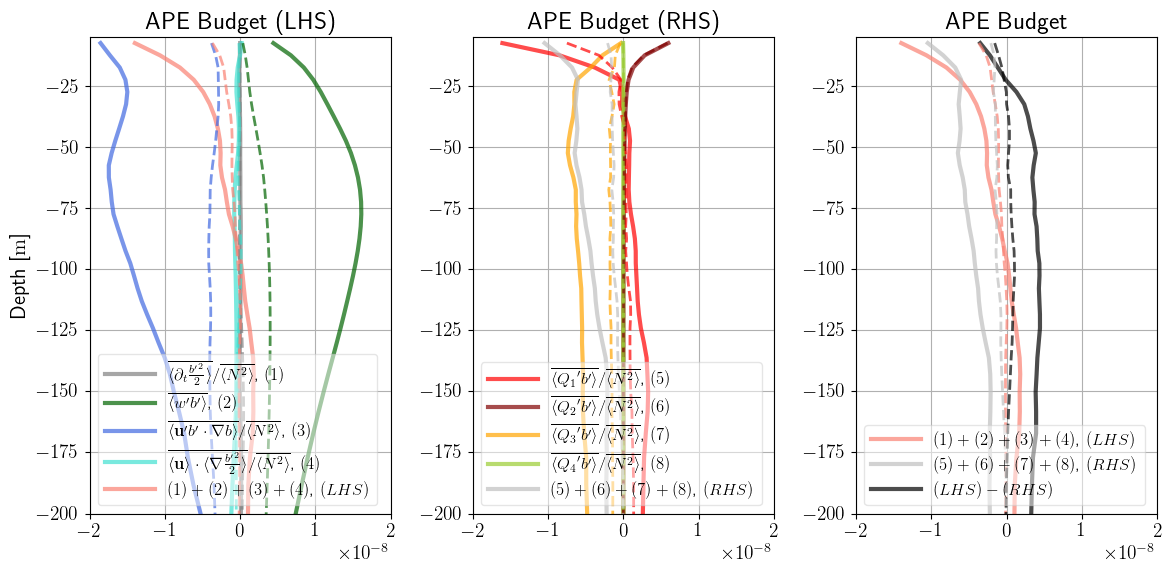

In [58]:
fig = plt.figure(figsize=(12,6), dpi=100, tight_layout=True)
colours = ['grey', 'darkgreen','royalblue','turquoise','salmon','red','maroon', 'orange', 'yellowgreen', 'silver', 'black']

labells = [r'$\overline{\langle  \partial_t\frac{{b^{\prime}}^{2}}{2} \rangle}/ \overline{\langle N^2 \rangle}$, $(1)$' ,
           r'$\overline{\langle w^{\prime}b^{\prime} \rangle}$, $(2)$',
           r'$\overline{\langle \mathbf{u}^{\prime}b^{\prime} \cdot \nabla b \rangle}/\overline{\langle N^2 \rangle}$, $(3)$',
           r'$\overline{\langle \mathbf{u} \rangle \cdot \langle \nabla \frac{{b^{\prime}}^{2}}{2} \rangle}/ \overline{\langle N^2 \rangle}$, $(4)$',
           r'$(1)+ (2)+(3)+(4)$, $(LHS)$ ',
           r'$\overline{\langle {Q_1}^{\prime}b^{\prime} \rangle}/ \overline{\langle N^2 \rangle}$, $(5)$',
           r'$\overline{\langle {Q_2}^{\prime}b^{\prime} \rangle}/ \overline{\langle N^2 \rangle}$, $(6)$',
           r'$\overline{\langle {Q_3}^{\prime}b^{\prime} \rangle}/ \overline{\langle N^2 \rangle}$, $(7)$',
           r'$\overline{\langle {Q_4}^{\prime}b^{\prime} \rangle}/ \overline{\langle N^2 \rangle}$, $(8)$',
           r'$(5)+(6)+(7)+(8)$, $(RHS)$',
           r'$(LHS)-(RHS)$',]

plt.subplot(131)
plt.plot((time_mean_PE_2['2km'].bp2_tend/(2*Nsq0['2km'])).sel(Z=slice(-5,-1000)),
         time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=3, color = colours[0],label=labells[0], alpha=0.7)
plt.plot(time_mean_PE_2['2km'].wpbp.sel(Z=slice(-5,-1000)),
         time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=3, color = colours[1],label=labells[1], alpha=0.7)
plt.plot((time_mean_PE_2['2km'].Upbpgradb/Nsq0['2km']).sel(Z=slice(-5,-1000)),
         time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=3, color = colours[2],label=labells[2], alpha=0.7)
plt.plot((time_mean_PE_2['2km'].Ugradbp2/Nsq0['2km']).sel(Z=slice(-5,-1000)),
         time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=3, color = colours[3],label=labells[3], alpha=0.7)
plt.plot(time_mean_PE_2['2km'].LHS.sel(Z=slice(-5,-1000)),
         time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=3, color = colours[4],label=labells[4], alpha=0.7)

plt.plot((time_mean_PE_2['16km'].bp2_tend/(2*Nsq0['16km'])).sel(Z=slice(-5,-1000)),
         time_mean_PE_2['16km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=2, color = colours[0],linestyle='dashed', alpha=0.7)
plt.plot(time_mean_PE_2['16km'].wpbp.sel(Z=slice(-5,-1000)),
         time_mean_PE_2['16km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=2, color = colours[1],linestyle='dashed', alpha=0.7)
plt.plot((time_mean_PE_2['16km'].Upbpgradb/Nsq0['16km']).sel(Z=slice(-5,-1000)),
         time_mean_PE_2['16km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=2, color = colours[2],linestyle='dashed', alpha=0.7)
plt.plot((time_mean_PE_2['16km'].Ugradbp2/Nsq0['16km']).sel(Z=slice(-5,-1000)),
         time_mean_PE_2['16km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=2, color = colours[3],linestyle='dashed', alpha=0.7)
plt.plot(time_mean_PE_2['16km'].LHS.sel(Z=slice(-5,-1000)),
         time_mean_PE_2['16km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=2, color = colours[4],linestyle='dashed', alpha=0.7)

plt.ylim([-200,-5])
plt.xlim([-2e-8,2e-8])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.title(r'APE Budget (LHS)', fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(132)
plt.plot(((time_mean_PE_2['2km'].bpQ1p )/Nsq0['2km']).sel(Z=slice(-5,-1000)),
         time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=3, color = colours[5],label=labells[5], alpha=0.7)
plt.plot(((time_mean_PE_2['2km'].bpQ2p )/Nsq0['2km']).sel(Z=slice(-5,-1000)),
         time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=3, color = colours[6],label=labells[6], alpha=0.7)
plt.plot(((time_mean_PE_2['2km'].bpQ3p)/Nsq0['2km']).sel(Z=slice(-5,-1000)),
         time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=3, color = colours[7],label=labells[7], alpha=0.7)
plt.plot(((time_mean_PE_2['2km'].bpQ4p )/Nsq0['2km']).sel(Z=slice(-5,-1000)),
         time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=3, color = colours[8],label=labells[8], alpha=0.7)
plt.plot(time_mean_PE_2['2km'].RHS1.sel(Z=slice(-5,-1000)) ,
         time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=3, color = colours[9],label=labells[9], alpha=0.7)

plt.plot(((time_mean_PE_2['16km'].bpQ1p )/Nsq0['16km']).sel(Z=slice(-5,-1000)),
         time_mean_PE_2['16km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=2, color = colours[5],linestyle='dashed', alpha=0.7)
plt.plot(((time_mean_PE_2['16km'].bpQ2p )/Nsq0['16km']).sel(Z=slice(-5,-1000)),
         time_mean_PE_2['16km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=2, color = colours[6],linestyle='dashed', alpha=0.7)
plt.plot(((time_mean_PE_2['16km'].bpQ3p)/Nsq0['16km']).sel(Z=slice(-5,-1000)),
         time_mean_PE_2['16km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=2, color = colours[7],linestyle='dashed', alpha=0.7)
plt.plot(((time_mean_PE_2['16km'].bpQ4p )/Nsq0['16km']).sel(Z=slice(-5,-1000)),
         time_mean_PE_2['16km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=2, color = colours[8],linestyle='dashed', alpha=0.7)
plt.plot(time_mean_PE_2['16km'].RHS1.sel(Z=slice(-5,-1000)) ,
         time_mean_PE_2['16km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=2, color = colours[9],linestyle='dashed', alpha=0.7)

plt.ylim([-200,-5])
plt.xlim([-2e-8,2e-8])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(r'APE Budget (RHS)', fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()


plt.subplot(133)
plt.plot(time_mean_PE_2['2km'].LHS.sel(Z=slice(-5,-1000)),
         time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=3, color = colours[4],label=labells[4], alpha=0.7)
plt.plot(time_mean_PE_2['2km'].RHS1.sel(Z=slice(-5,-1000)) ,
         time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=3, color = colours[9], label = labells[9], alpha=0.7)
plt.plot((time_mean_PE_2['2km'].LHS - time_mean_PE_2['2km'].RHS1).sel(Z=slice(-5,-1000)),
         time_mean_PE_2['2km'].sel(Z=slice(-5,-1000)).Z ,
         linewidth=3, color = colours[10], label = labells[10], alpha=0.7)

plt.plot(time_mean_PE_2['16km'].LHS.sel(Z=slice(-5,-1000)),
         time_mean_PE_2['16km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=2, color = colours[4],linestyle='dashed', alpha=0.7)
plt.plot(time_mean_PE_2['16km'].RHS1.sel(Z=slice(-5,-1000)) ,
         time_mean_PE_2['16km'].sel(Z=slice(-5,-1000)).Z,
         linewidth=2, color = colours[9],linestyle='dashed', alpha=0.7)
plt.plot((time_mean_PE_2['16km'].LHS - time_mean_PE_2['16km'].RHS1).sel(Z=slice(-5,-1000)),
         time_mean_PE_2['16km'].sel(Z=slice(-5,-1000)).Z ,
         linewidth=2, color = colours[10],linestyle='dashed', alpha=0.7)

plt.ylim([-200,-5])
plt.xlim([-2e-8,2e-8])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(r'APE Budget', fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()


(-900.0, -5.0)

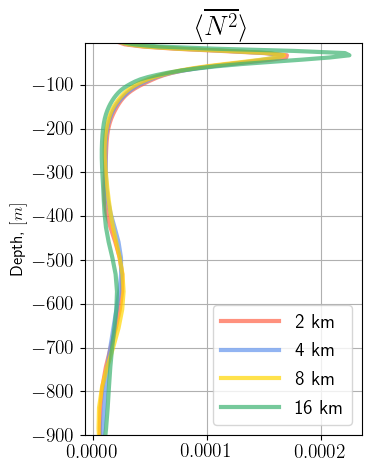

In [28]:
plt.figure(figsize=(4,5), tight_layout=True, dpi=100)
for i, r in enumerate(res):
    plt.plot(Nsq0[r], Nsq0[r].Z, color=colours[r], label = labels[r], linewidth=3, alpha=0.7)
plt.legend(loc=0)
plt.ylabel(r'Depth, $[m]$')
plt.grid()
plt.title(r'$\langle\overline{N^2}\rangle$')
plt.ylim([-900, -5])

(-100.0, -5.0)

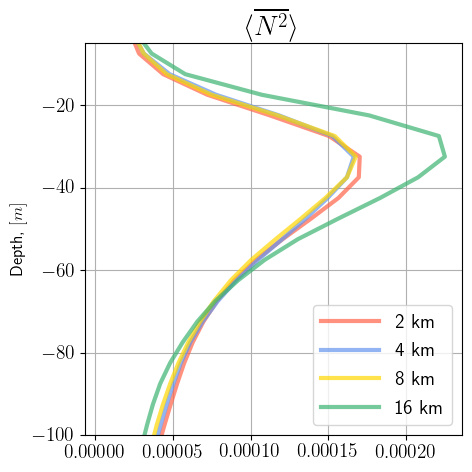

In [29]:
plt.figure(figsize=(5,5), tight_layout=True, dpi=100)
for i, r in enumerate(res):
    plt.plot(Nsq0[r], Nsq0[r].Z, color=colours[r], label = labels[r], linewidth=3, alpha=0.7)
plt.legend(loc=0)
plt.ylabel(r'Depth, $[m]$')
plt.grid()
plt.title(r'$\langle\overline{N^2}\rangle$')
plt.ylim([-100, -5])

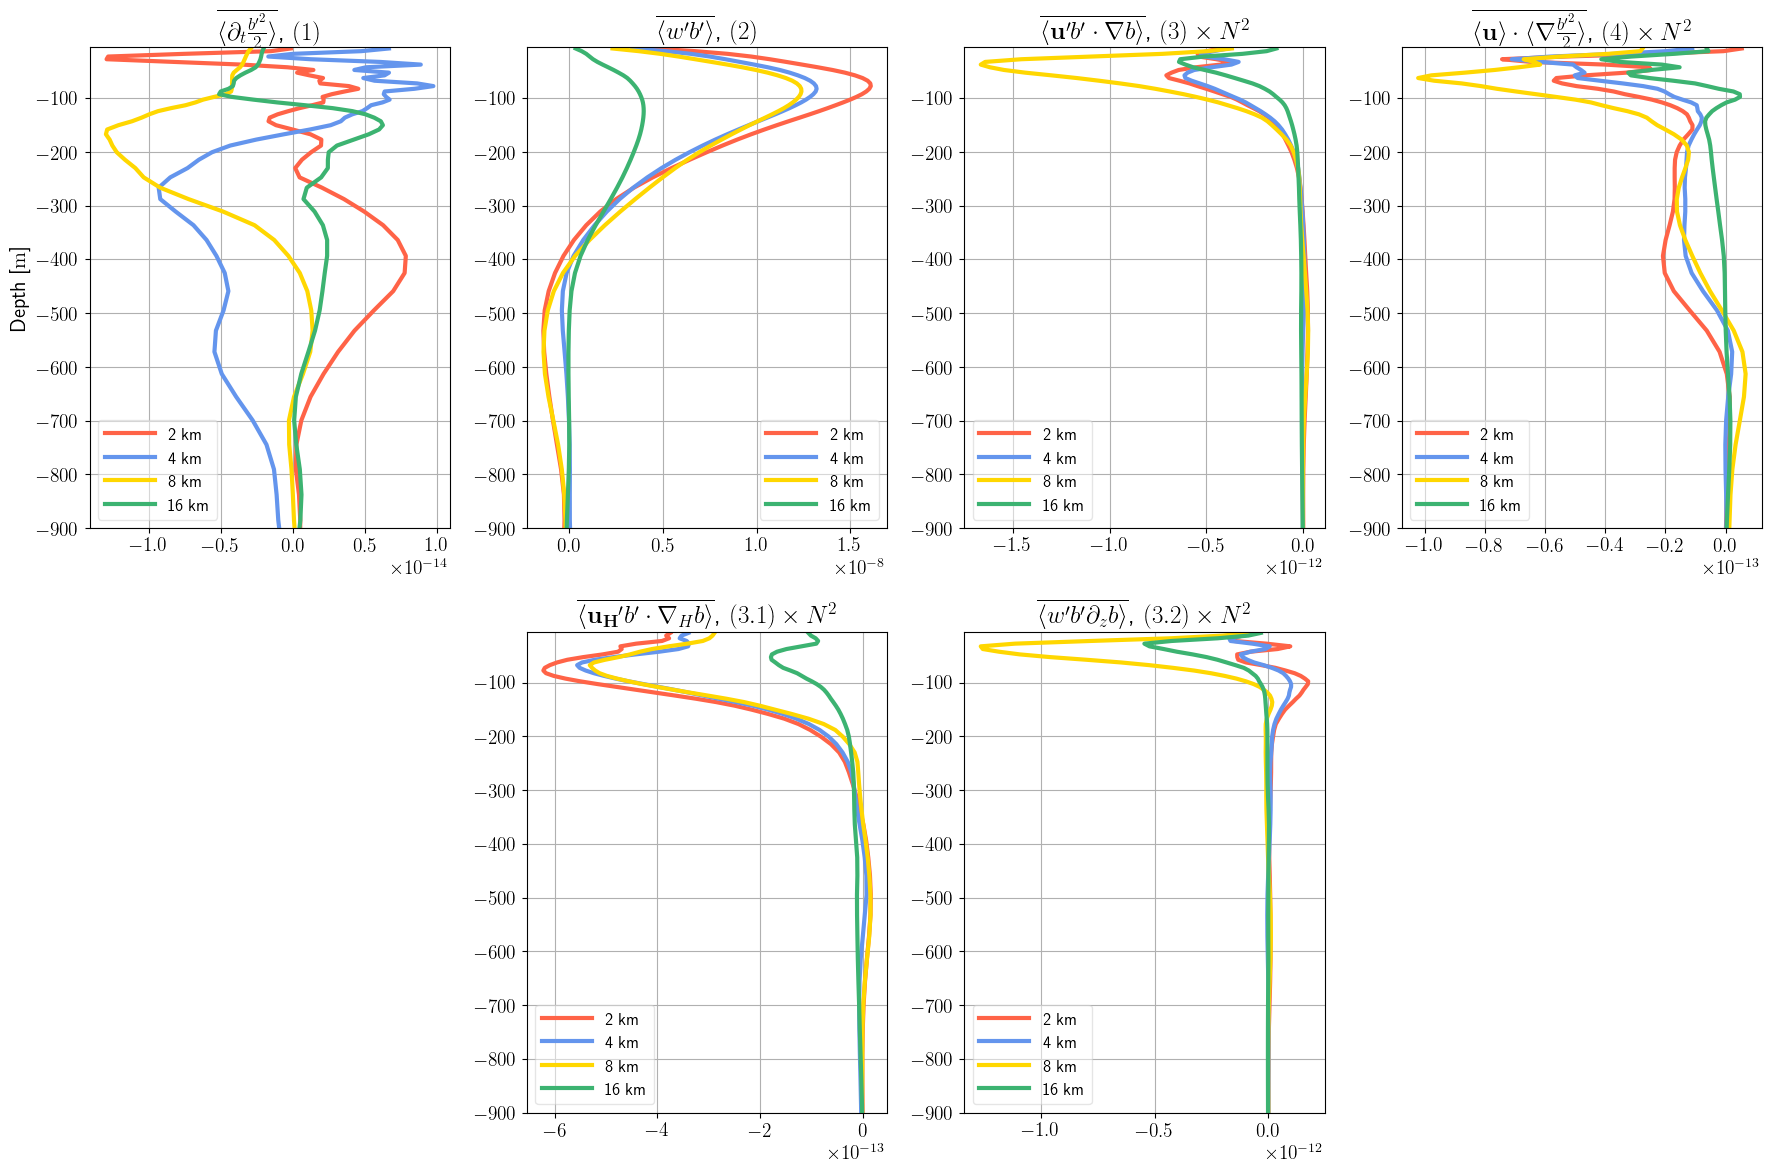

In [30]:
fig = plt.figure(figsize=(18,12), dpi=100, tight_layout=True)
# colours = ['grey', 'darkgreen','royalblue','turquoise','salmon','royalblue', 'red', 'orange']

titles = [r'$\overline{\langle  \partial_t\frac{{b^{\prime}}^{2}}{2} \rangle}$, $(1)$' , 
          r'$\overline{\langle w^{\prime}b^{\prime} \rangle}$, $(2)$', 
          r'$\overline{\langle \mathbf{u}^{\prime}b^{\prime} \cdot \nabla b \rangle}$, $(3)\times N^2$', 
          r'$\overline{\langle \mathbf{u} \rangle \cdot \langle \nabla \frac{{b^{\prime}}^{2}}{2} \rangle}$, $(4) \times N^2$', 
          r'$(1)+(2)+(3)+(4)$',
          r'$\overline{\langle \mathbf{u_{H}}^{\prime}b^{\prime} \cdot \nabla_{H} b \rangle}$, $(3.1) \times N^2$' ,
          r'$\overline{\langle w^{\prime}b^{\prime} \partial_z b \rangle}$, $(3.2) \times N^2$', 
          r'$(1)+(2)+(3.1)+(4)$',
           ]

labels = {'2km': '2 km','4km': '4 km','8km': '8 km','16km': '16 km',}
colours = {'2km': colors[0],'4km': colors[1],'8km': colors[2],'16km': colors[3]}
plt.subplot(241)
for i, r in enumerate(res):
    plt.plot((time_mean_PE[r].bp2_tend/2).sel(Z=slice(-5,-1000)), time_mean_PE[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel(r'Depth [$\mathrm{m}$]', fontsize=15)
plt.title(titles[0], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(242)
for i, r in enumerate(res):
    plt.plot(time_mean_PE[r].wpbp.sel(Z=slice(-5,-1000)), time_mean_PE[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[1], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(243)
for i, r in enumerate(res):
    plt.plot((time_mean_PE[r].Upbpgradb).sel(Z=slice(-5,-1000)), time_mean_PE[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[2], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(244)
for i, r in enumerate(res):
    plt.plot((time_mean_PE[r].Ugradbp2).sel(Z=slice(-5,-1000)), time_mean_PE[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[3], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()



plt.subplot(246)
for i, r in enumerate(res):
    plt.plot((time_mean_PE[r].Upbpgradb_h).sel(Z=slice(-5,-1000)), time_mean_PE[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[5], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()

plt.subplot(247)
for i, r in enumerate(res):
    plt.plot((time_mean_PE[r].Upbpgradb_v).sel(Z=slice(-5,-1000)), time_mean_PE[r].sel(Z=slice(-5,-1000)).Z, linewidth=3, color = colours[r],label=labels[r])
plt.ylim([-900,-5])
# plt.yticks([-200,-400,-600,-800], [r'$200$',r'$400$',r'$600$',r'$800$'] )
plt.ylabel('')
plt.title(titles[6], fontsize=18)
plt.legend(fontsize=12, loc=0, framealpha=0.5)
plt.grid()



In [55]:
from geographiclib.geodesic import Geodesic


ModuleNotFoundError: No module named 'geographiclib'